## Custom Modelling

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [70]:
import pandas as pd

# Read the training dataset
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
# Drop unwanted columns if they exist
columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
Final_Dataset_Provider_Train = Final_Dataset_Provider_Train.drop(
    columns=[col for col in columns_to_drop if col in Final_Dataset_Provider_Train.columns], 
    axis=1
)

# Read the testing dataset
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')
# Drop unwanted columns if they exist
Final_Dataset_Provider_Test = Final_Dataset_Provider_Test.drop(
    columns=[col for col in columns_to_drop if col in Final_Dataset_Provider_Test.columns], 
    axis=1
)


1) Split your whole data into train and test(80-20)



2) Now, in the 80% train set, split the train set into D1 and D2.(50-50).



From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).



Now create 'k' models and train each of these models with each of these k samples.



3) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.



4) Now, using these k predictions, create a new dataset, and for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.



5) Now, for model evaluation, you have can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.



I hope you got it. For base models, you can consider any Tree-based model; you can take the Decision Tree itself. And here, you can tune for the number of base models. The procedure mentioned above requires you to do custom coding. There are no library functions available for this as it is a custom model implementation.

In [71]:
Final_Dataset_Provider_Train.head(2)

Provider  PotentialFraud  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  PRV51001               0                  104640             5340.0   
1  PRV51003               1                  605670            66286.0   

   Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                      30.0            61             0.0   
1                     382.0           617             0.0   

   Inpatient_or_Outpatient  RenalDiseaseIndicator  NoOfMonths_PartACov  ...  \
0                        5                      8                  300  ...   
1                       62                     29                 1560  ...   

   PerProviderClmDiagnosisCode_4_count_ClaimID  \
0                                          297   
1                                         3046   

   PerProviderClmDiagnosisCode_5_count_ClaimID  \
0                                          297   
1                                         4452   

   PerProviderClmDiagnosisCode_6_count_ClaimID  \
0                                          297   
1                                         5556   

   PerProviderDiagnosisGroupCode_count_ClaimID  Gender_0  Gender_1  Race_1  \
0                                          405        16         9      21   
1                                         4972        78        54     107   

   Race_2  Race_3  Race_5  
0       4       0       0  
1      24       0       1  

[2 rows x 247 columns]

In [72]:
Final_Dataset_Provider_Train.shape, Final_Dataset_Provider_Test.shape

((5410, 247), (1353, 246))

#### Split your whole data into train and test(80-20)

In [73]:
# Split your whole data into train and test(80-20)
from sklearn.model_selection import train_test_split
Final_Dataset_Provider_Tr, Final_Dataset_Provider_val = train_test_split(Final_Dataset_Provider_Train, test_size=0.2,
                               random_state=42,stratify=Final_Dataset_Provider_Train['PotentialFraud'])
Final_Dataset_Provider_Tr.shape, Final_Dataset_Provider_val.shape

((4328, 247), (1082, 247))

In [74]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Tr.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Tr['PotentialFraud']
x_train.shape, y_train.shape

((4328, 245), (4328,))

In [75]:
# prepare test data
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [76]:
# Seperate dependent and independent variables
x_validation_provider_labels = Final_Dataset_Provider_val[['Provider','PotentialFraud']]
x_validation = Final_Dataset_Provider_val.drop(columns=['Provider','PotentialFraud'],axis=1)
y_validation = Final_Dataset_Provider_val['PotentialFraud']
x_validation.shape, y_validation.shape

((1082, 245), (1082,))

In [77]:
from sklearn.preprocessing import StandardScaler
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_tr = standard_scaler.transform(x_train)
x_val = standard_scaler.transform(x_validation)
x_test_std = standard_scaler.transform(x_test)

# convert pandas.core.series.Series to numpy.ndarray
y_tr = y_train.to_numpy()
y_val = y_validation.to_numpy()

In [78]:
x_val.shape, y_val.shape

((1082, 245), (1082,))

#### Now, in the 80% train set, split the train set into D1 and D2.(50-50)

In [79]:
# Now, in the 80% train set, split the train set into D1 and D2.(50-50)
x_d1, x_d2, y_d1, y_d2 = train_test_split(x_tr, y_tr, test_size=0.5,random_state=42,stratify=y_tr)
x_d1.shape, x_d2.shape, y_d1.shape, y_d2.shape

((2164, 245), (2164, 245), (2164,), (2164,))

In [80]:
from sklearn.metrics import roc_curve, auc , f1_score
import matplotlib.pyplot as plt
def pred_prob(clf, data):
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(visible=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [81]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    # plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [82]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

#### Define a function to randomly sample data from dataset

In [83]:
# define a function to randomly sample data from dataset
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
import numpy as np
def row_col_sampling(x, y):
    total_row_count = x.shape[0]
    total_col_count = x.shape[1]
    # in sampled data i want to keep minimum 40% to maximum 60% number of rows
    sampled_row_count_min = round(total_row_count * 0.4)
    sampled_row_count_max = round(total_row_count * 0.6)
    # in a single dataset the rows should be unique, so setting "replace=False"
    sampled_row_indices = np.random.choice(total_row_count, np.random.randint(sampled_row_count_min,
                                                                              sampled_row_count_max),replace=False)
    sampled_row_indices = np.sort(sampled_row_indices)
    
    sampled_col_count_min = round(total_col_count * 0.4)
    sampled_col_count_max = round(total_col_count * 0.6)
    sampled_col_indices = np.random.choice(total_col_count, np.random.randint(sampled_col_count_min,
                                                                              sampled_col_count_max),replace=False)
    sampled_col_indices = np.sort(sampled_col_indices)
    # now select the sampled rows and columns from the input data
    
    #print(len(sampled_row_indices), len(sampled_col_indices))
    x_sampled = x[sampled_row_indices[:,None], sampled_col_indices]
    y_sampled = y[sampled_row_indices]
    #print(x_sampled.shape)
    
    return x_sampled, y_sampled, sampled_row_indices, sampled_col_indices

#### Function to create k sampled dataset

In [84]:
def create_k_dataset(x_tr, x_te, y_tr, y_te, k):
    x_tr_list = []
    y_tr_list = []
    x_te_list = []
    # y_te_list = []
    sampled_col_indices_list = []
    for i in range(k):
        x_sampled, y_sampled, sampled_row_indices, sampled_col_indices = row_col_sampling(x_tr, y_tr)
        x_tr_list.append(x_sampled)
        y_tr_list.append(y_sampled)
        x_te_list.append(x_te[:,sampled_col_indices])
        # y_te_list.append(y_te)
        sampled_col_indices_list.append(sampled_col_indices)
    return x_tr_list, y_tr_list, x_te_list, y_te, sampled_col_indices_list

#### Function to train k sampled dataset using decision tree, then create data for meta model

## Base Learner - DecisionTreeClassifier

In [85]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 50, min_samples_split = 100)
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9375574025292439
Test AUC =  0.9498289278469131


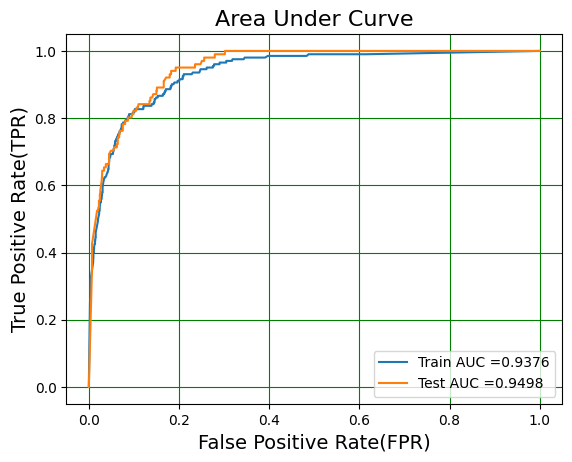

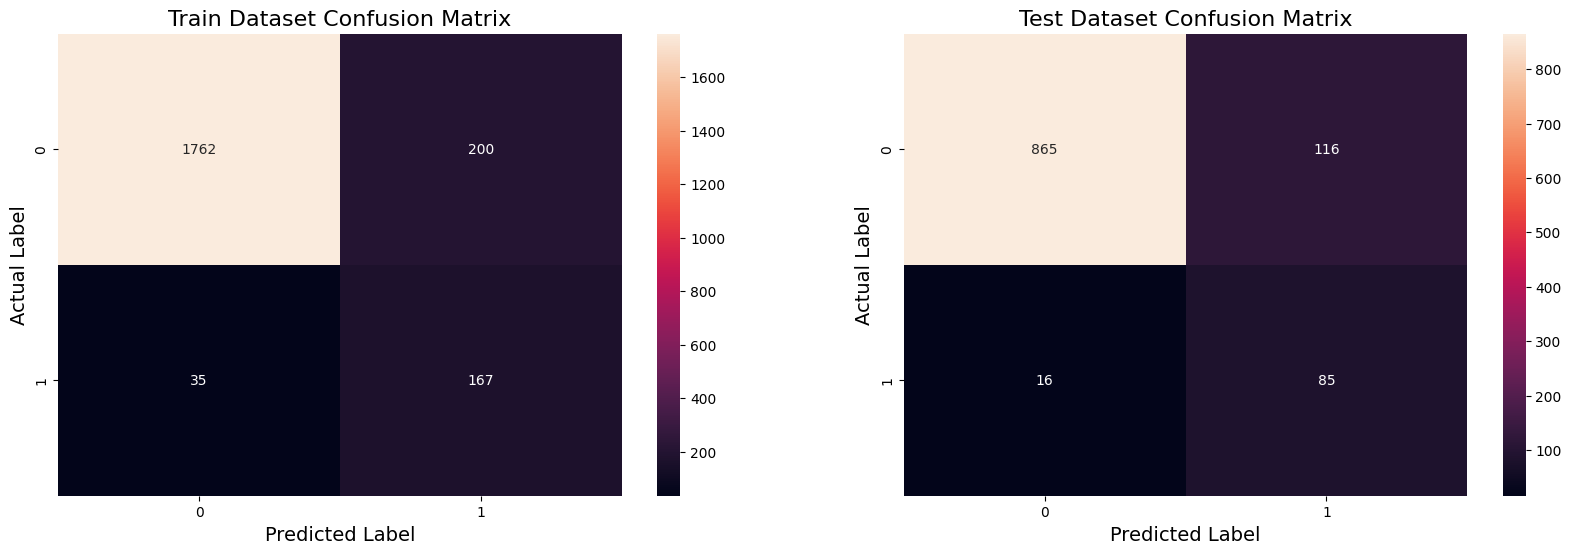

Best Threshold = 0.1134
Model AUC is : 0.9498
Model F1 Score is : 0.5629
						Number of base learners =  20
Train AUC =  0.9375321706482573
Test AUC =  0.9508180175815747


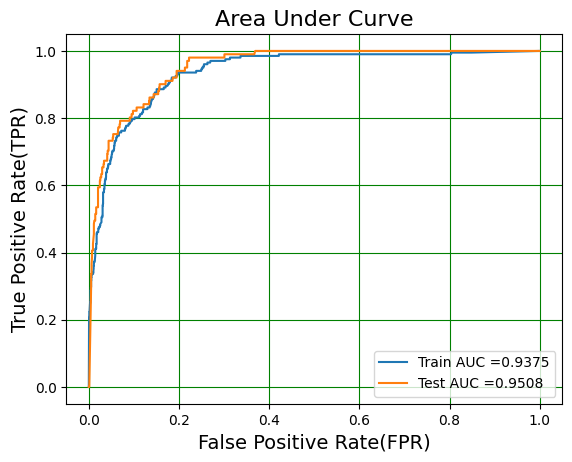

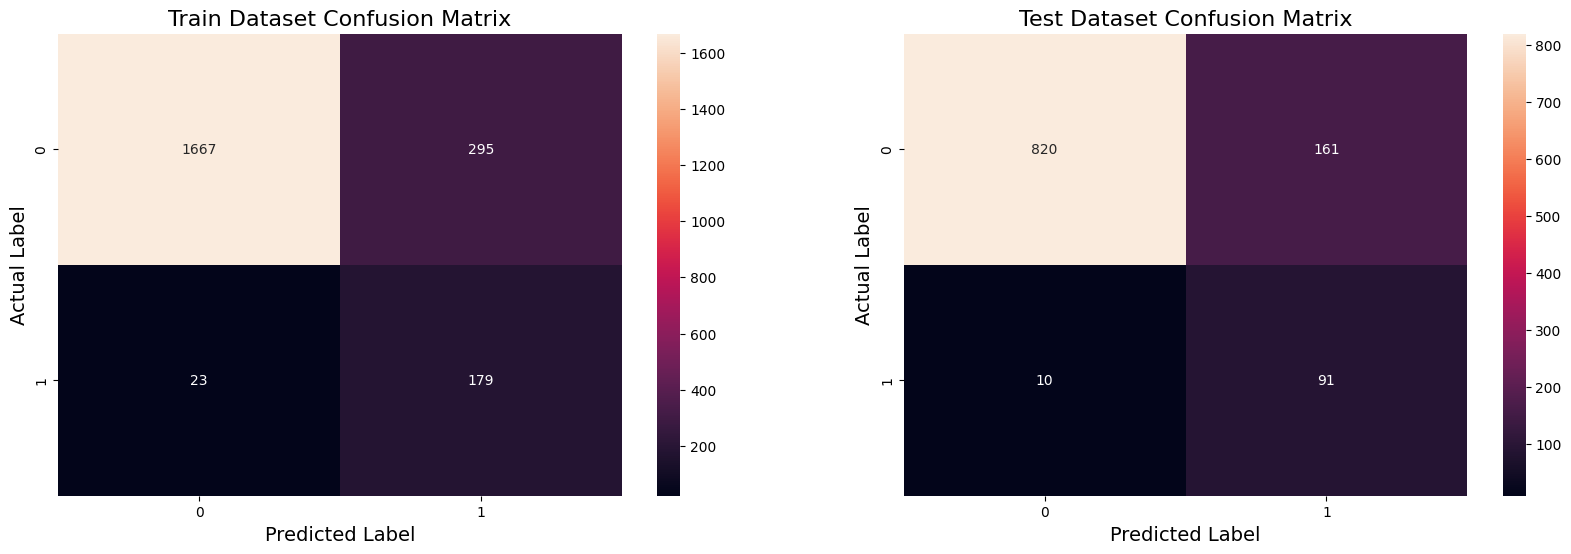

Best Threshold = 0.1100
Model AUC is : 0.9508
Model F1 Score is : 0.5156
						Number of base learners =  50
Train AUC =  0.9406255992571734
Test AUC =  0.9526750840221636


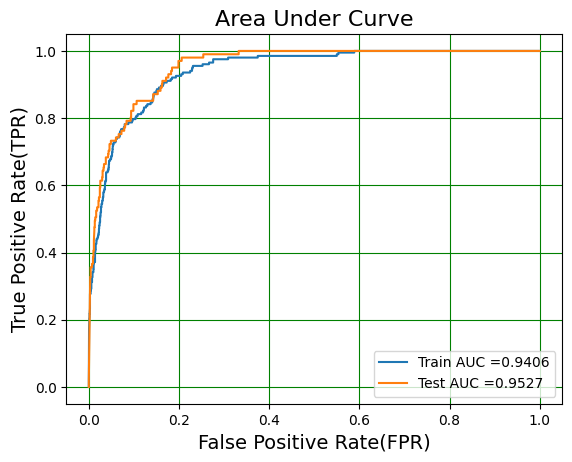

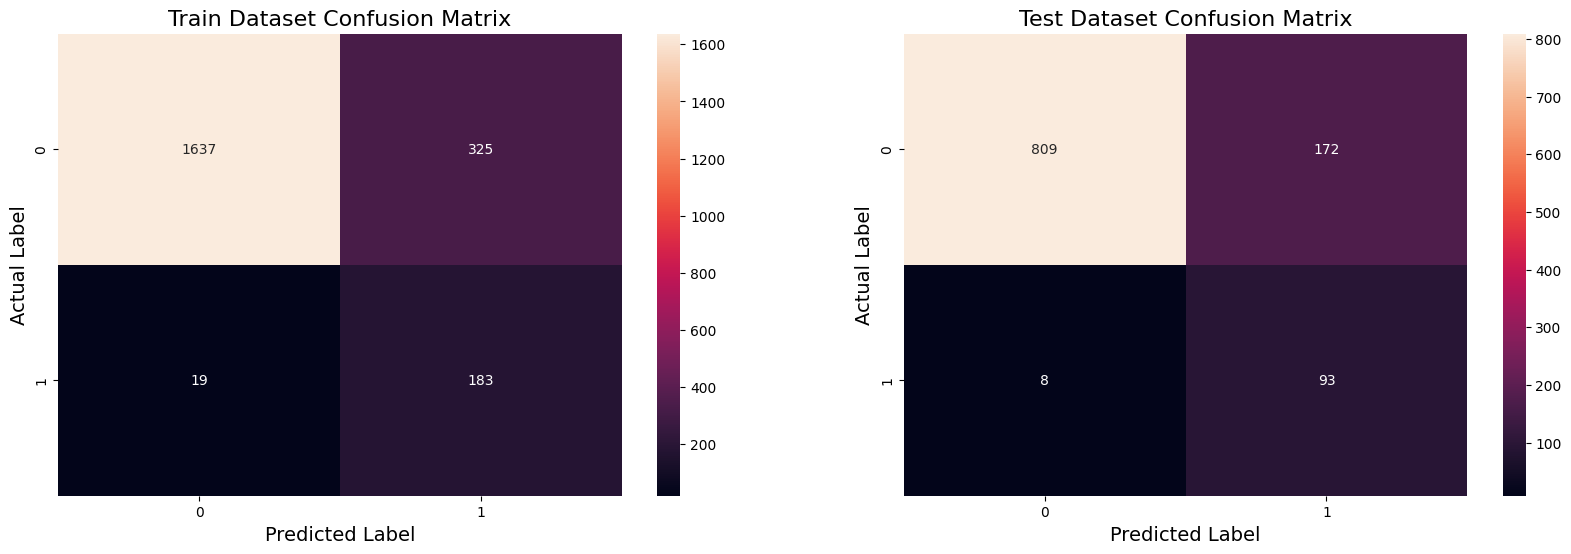

Best Threshold = 0.1020
Model AUC is : 0.9527
Model F1 Score is : 0.5082
						Number of base learners =  80
Train AUC =  0.9397475297988516
Test AUC =  0.9522915594311725


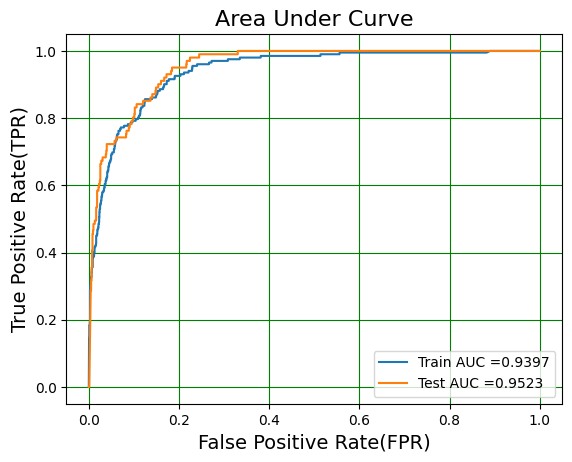

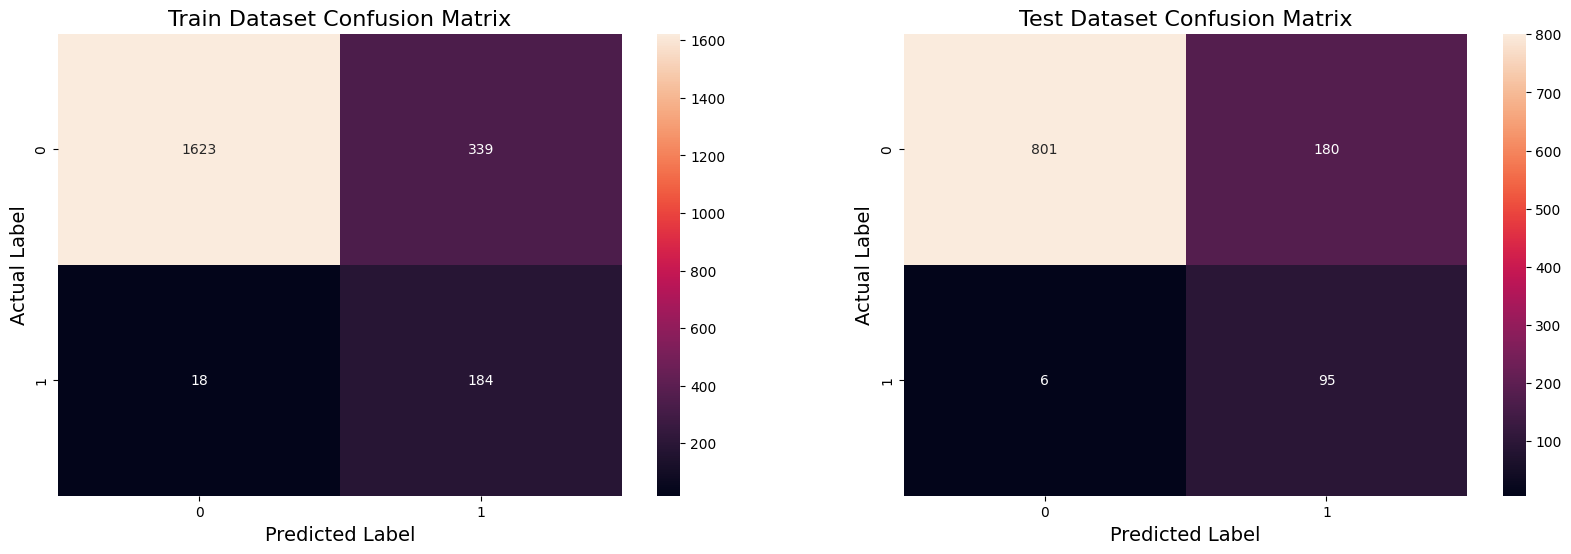

Best Threshold = 0.0925
Model AUC is : 0.9523
Model F1 Score is : 0.5053
						Number of base learners =  100
Train AUC =  0.9427261533492799
Test AUC =  0.9527810579223059


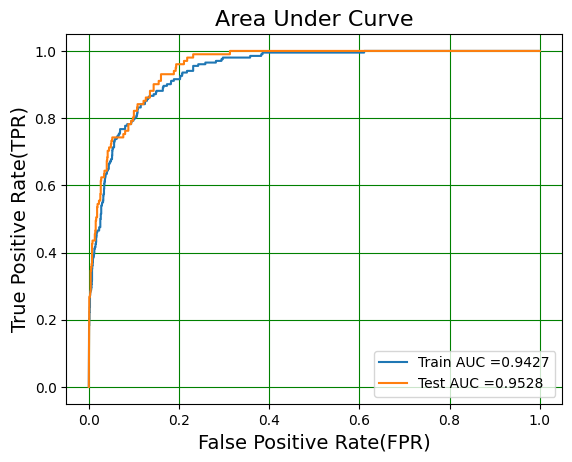

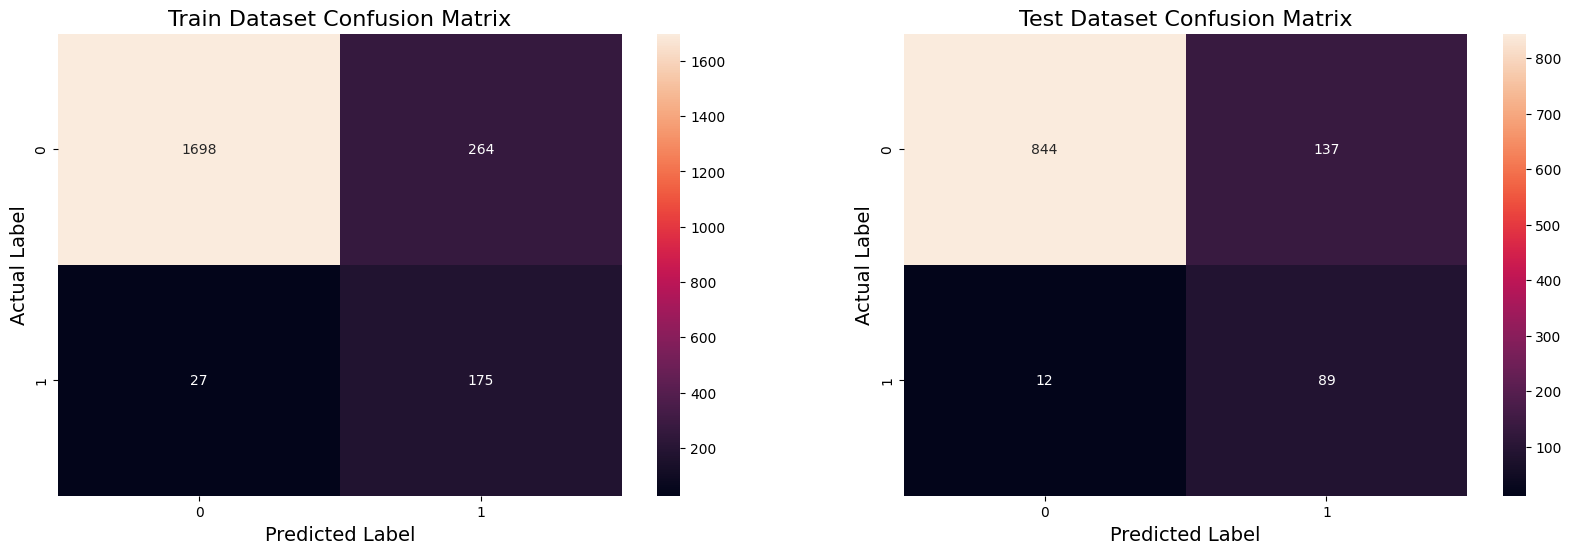

Best Threshold = 0.1138
Model AUC is : 0.9528
Model F1 Score is : 0.5443
						Number of base learners =  150
Train AUC =  0.9416802918823992
Test AUC =  0.9528062898032923


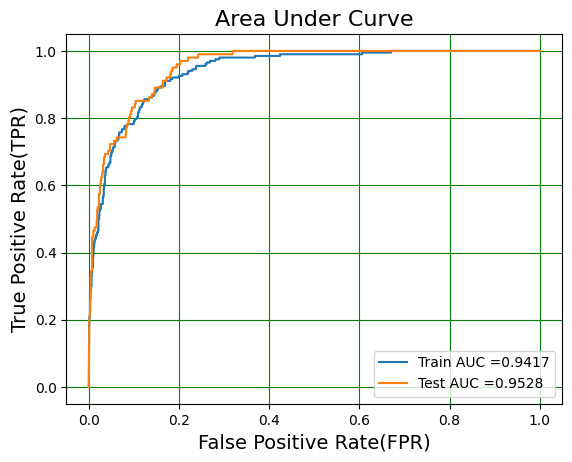

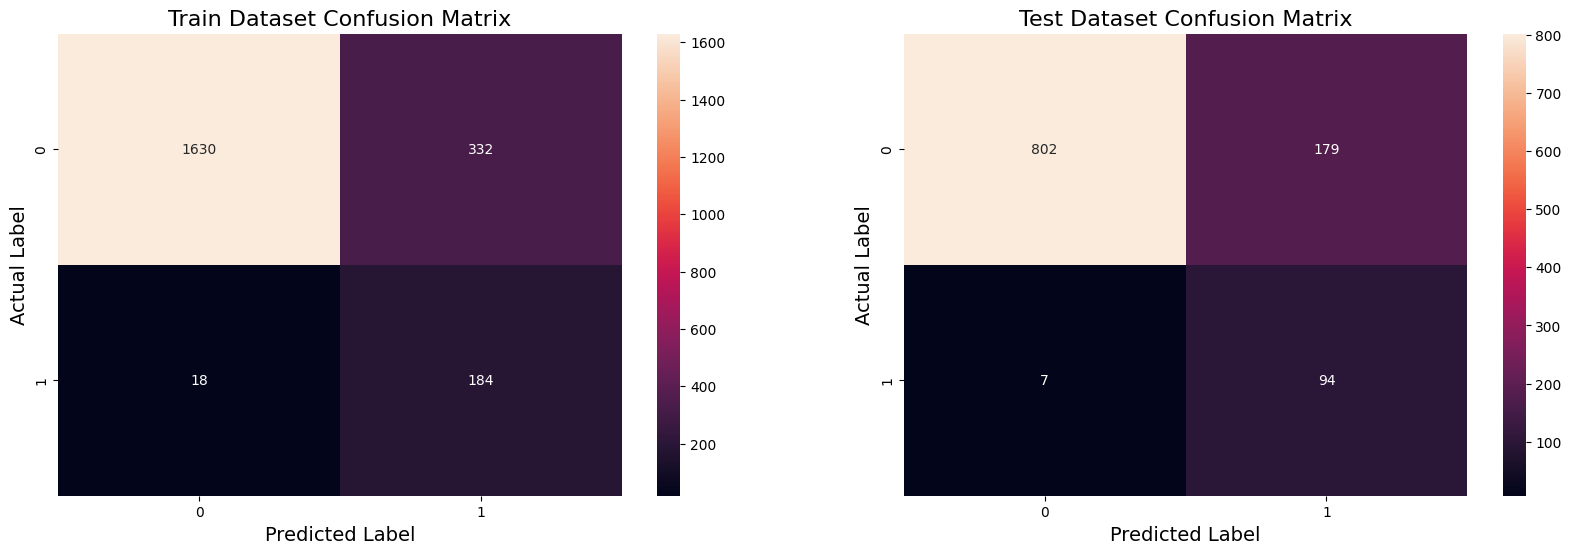

Best Threshold = 0.0839
Model AUC is : 0.9528
Model F1 Score is : 0.5027
						Number of base learners =  175
Train AUC =  0.9412904593211614
Test AUC =  0.9535581998566829


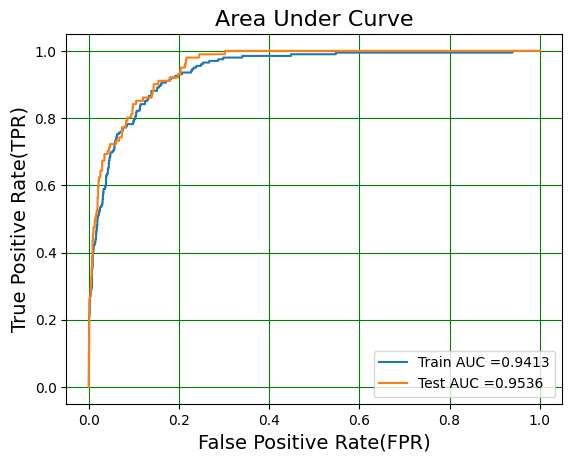

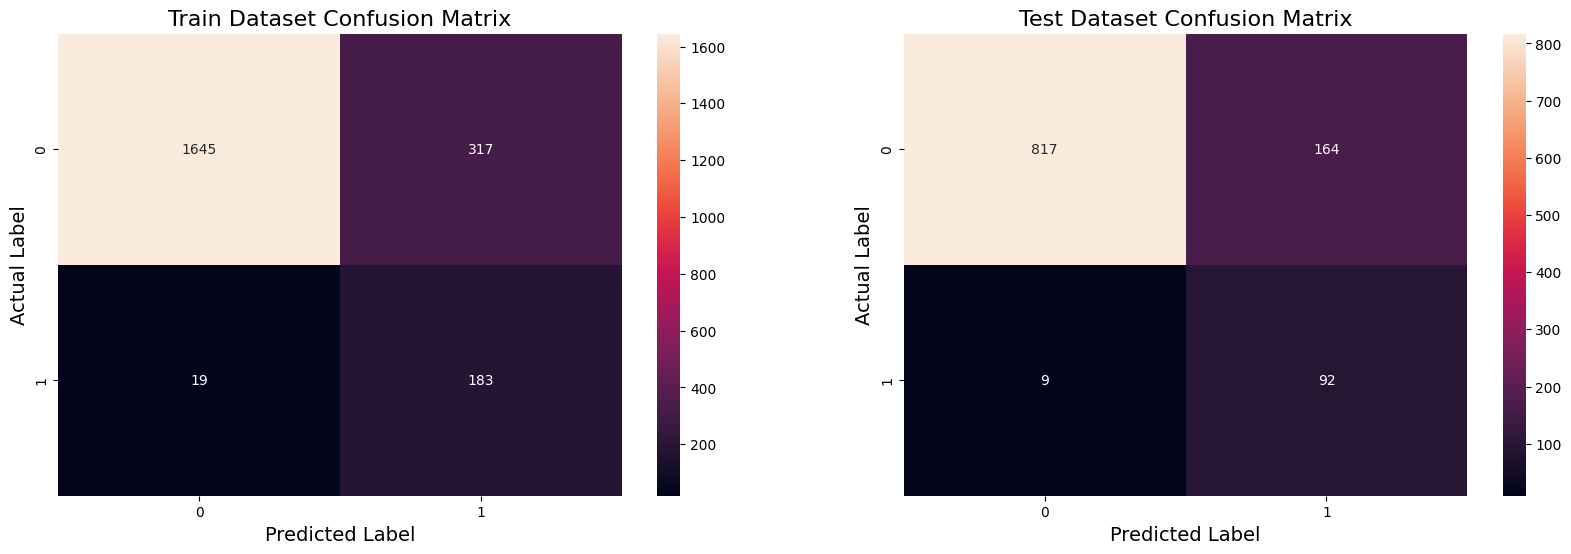

Best Threshold = 0.0889
Model AUC is : 0.9536
Model F1 Score is : 0.5154
						Number of base learners =  200
Train AUC =  0.9414115723498955
Test AUC =  0.952382394202723


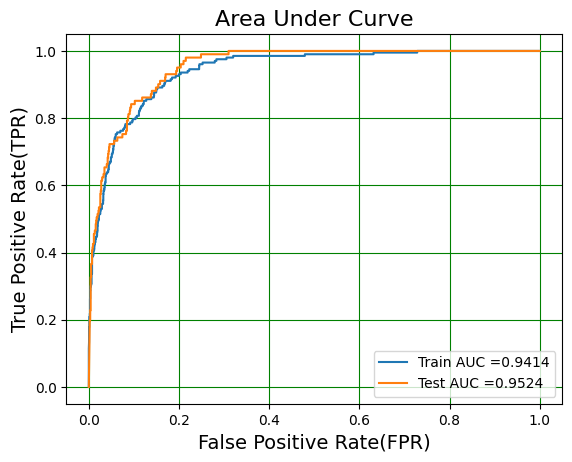

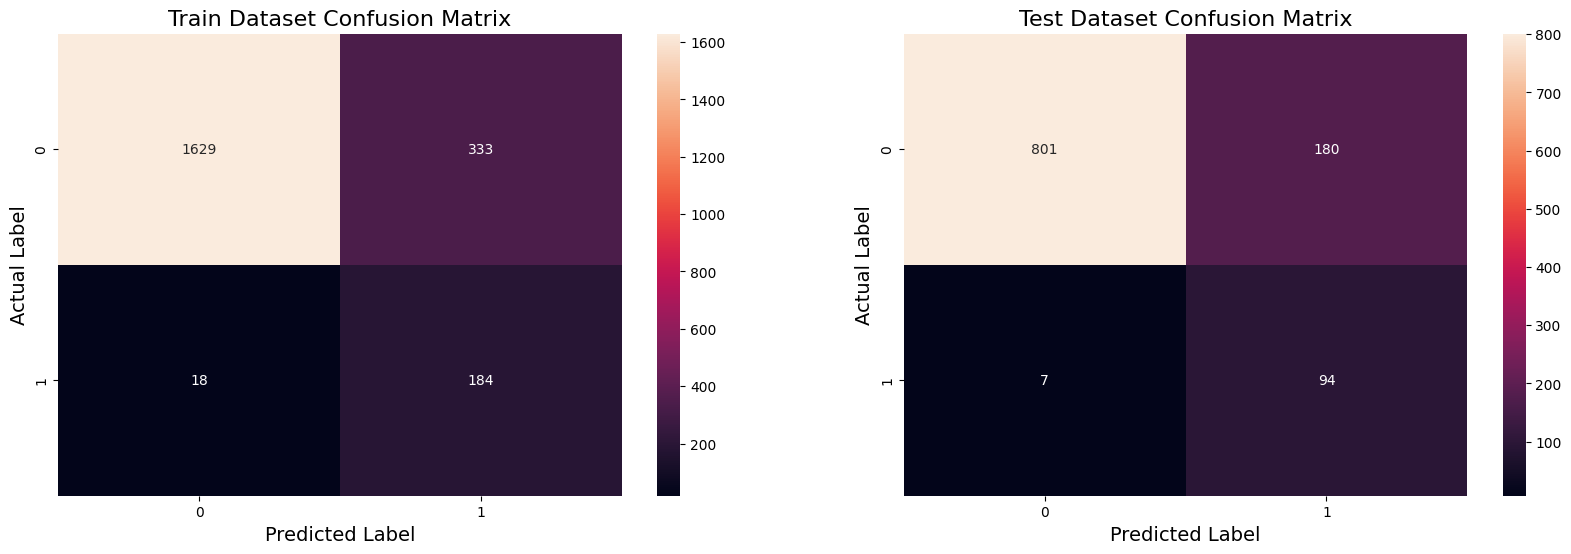

Best Threshold = 0.0789
Model AUC is : 0.9524
Model F1 Score is : 0.5013


In [86]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [87]:
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["No of DT", "Meta Model", "AUC", "F1 Score"]
table.append_row(["10", "Logistic Regression", "0.9462", "0.5000"])
table.append_row(["20", "Logistic Regression", "0.9515", "0.5215"])
table.append_row(["50", "Logistic Regression", "0.9508", "0.5121"])
table.append_row(["80", "Logistic Regression", "0.9526", "0.5028"])
table.append_row(["100", "Logistic Regression", "0.9524", "0.5314"])
table.append_row(["150", "Logistic Regression", "0.9538", "0.4987"])
table.append_row(["175", "Logistic Regression", "0.9527", "0.5110"])
table.append_row(["200", "Logistic Regression", "0.9521", "0.5306"])
print(table)

+----------+---------------------+-------+----------+
| No of DT |     Meta Model      |  AUC  | F1 Score |
+----------+---------------------+-------+----------+
|    10    | Logistic Regression | 0.946 |   0.5    |
+----------+---------------------+-------+----------+
|    20    | Logistic Regression | 0.952 |  0.521   |
+----------+---------------------+-------+----------+
|    50    | Logistic Regression | 0.951 |  0.512   |
+----------+---------------------+-------+----------+
|    80    | Logistic Regression | 0.953 |  0.503   |
+----------+---------------------+-------+----------+
|   100    | Logistic Regression | 0.952 |  0.531   |
+----------+---------------------+-------+----------+
|   150    | Logistic Regression | 0.954 |  0.499   |
+----------+---------------------+-------+----------+
|   175    | Logistic Regression | 0.953 |  0.511   |
+----------+---------------------+-------+----------+
|   200    | Logistic Regression | 0.952 |  0.531   |
+----------+----------------

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Observation:

If we look only at AUC and F1 Score, meta model is working best with 20 base learners. But in our case False Negative(Predicted not Fraud, but actually it is fraud) also a main factor. If we take False negative into consideration, model is working best with 50 base learners. 

In [88]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [89]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

### Now, train different meta model on new created dataset

### Logistic Regression

In [90]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kapil\AppDat

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [91]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.001, 'penalty': 'l2'}
roc_auc_score : 0.9399104213925377


Train AUC =  0.9442198807036666
Test AUC =  0.9531797216418889


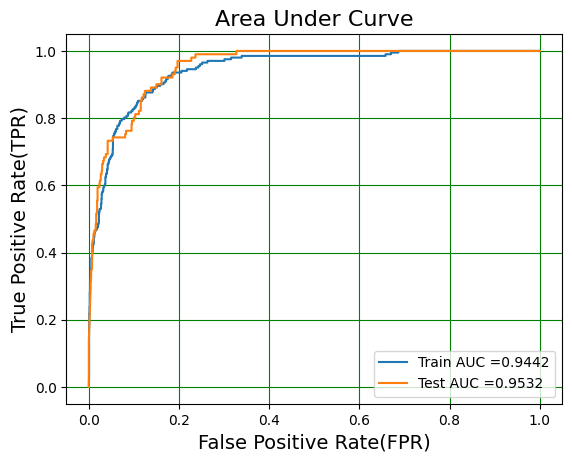

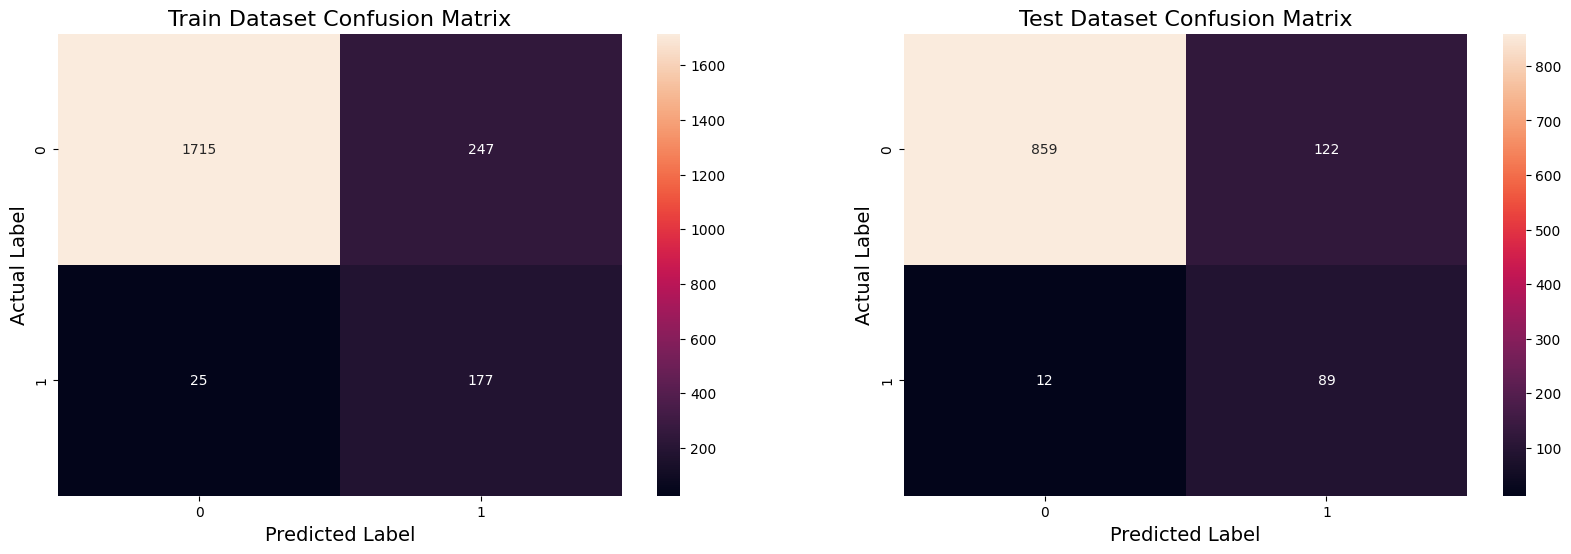

Best Threshold = 0.1179
Model AUC is : 0.9532
Model F1 Score is : 0.5705


In [92]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [93]:
from beautifultable import BeautifulTable
combined_table = BeautifulTable()
combined_table.column_headers= ["Model Combination", "No of base Learners", "AUC", "F1 Score"]
combined_table.append_row(["DT + LR", "50", "0.9525", "0.5443"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Decision Tree

In [94]:
# find best parameters for Decision Tree
decisiontree = DecisionTreeClassifier()

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_meta_model, y_te_d2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [95]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 150}
roc_auc_score : 0.9260246384906597


Train AUC =  0.9504748640001615
Test AUC =  0.9303347765969256


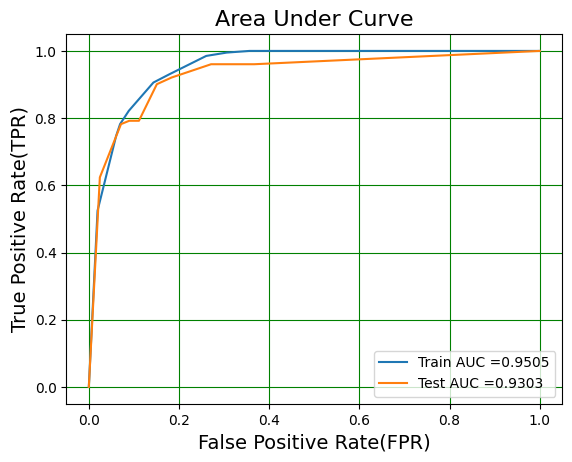

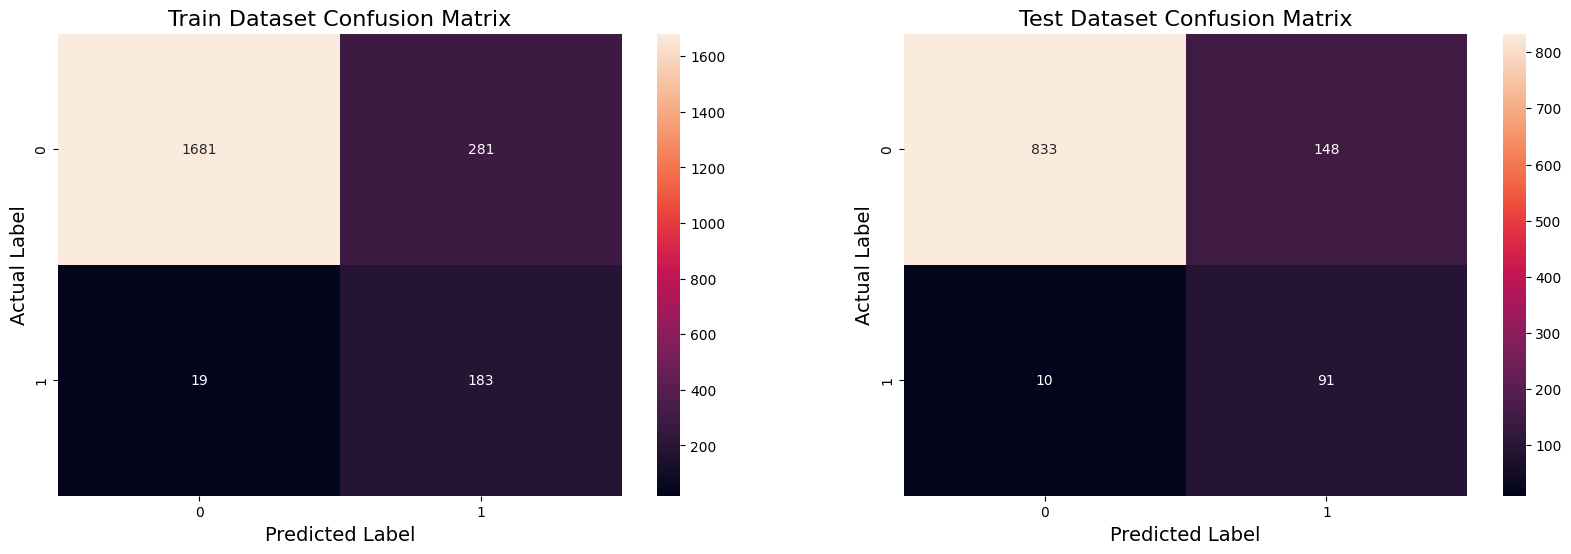

Best Threshold = 0.1371
Model AUC is : 0.9303
Model F1 Score is : 0.5353


In [96]:
decision_tree = DecisionTreeClassifier(criterion = 'entropy' ,max_depth = 5, min_samples_split = 150)
decision_tree.fit(x_tr_meta_model, y_te_d2)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [97]:
combined_table.append_row(["DT + DT", "50", "0.9141", "0.5000"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Support Vector Classifier

In [98]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [99]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l1'}
roc_auc_score : 0.9295723688376858


In [100]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

CalibratedClassifierCV(estimator=LinearSVC(C=0.5))

Train AUC =  0.947016834710994
Test AUC =  0.9453780240409363


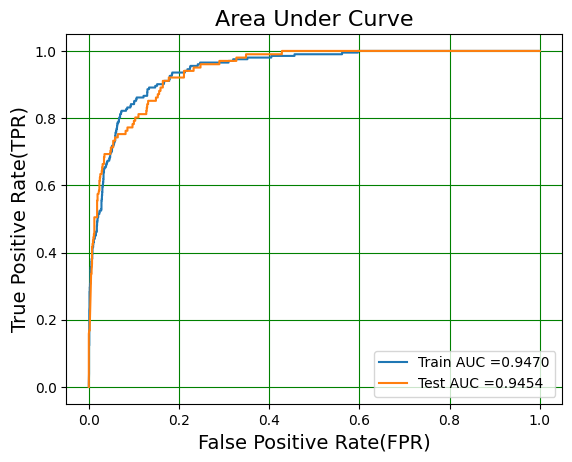

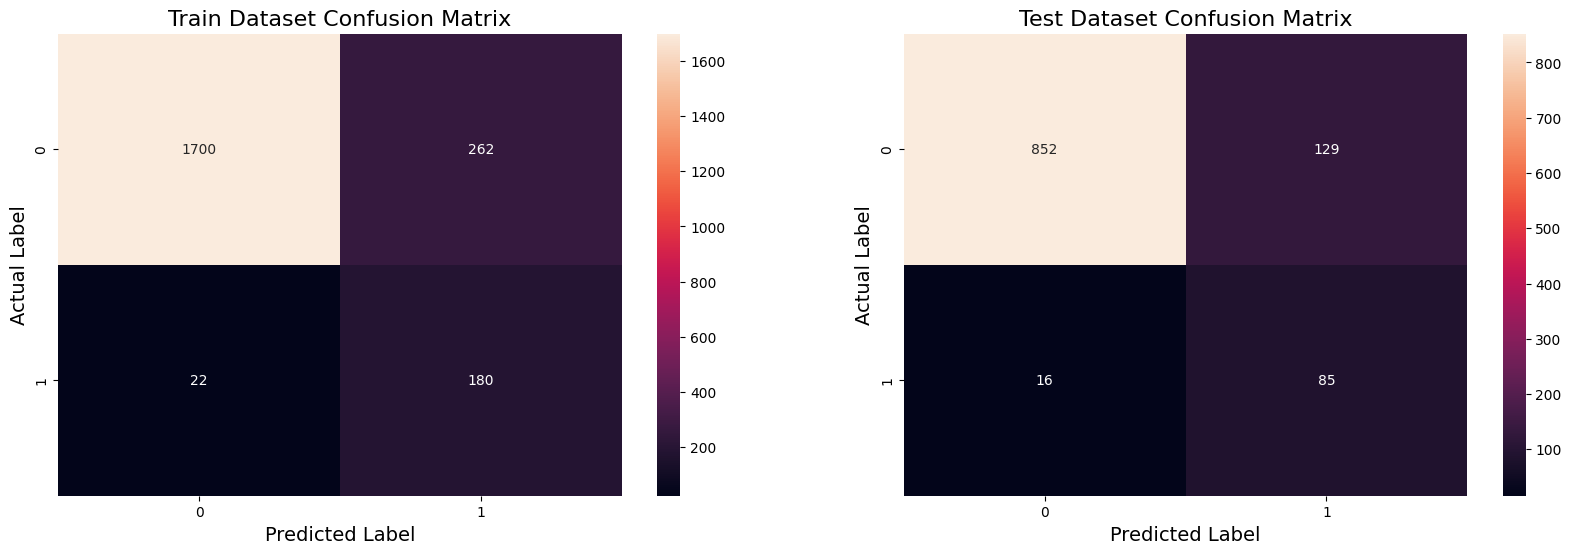

Best Threshold = 0.0957
Model AUC is : 0.9454
Model F1 Score is : 0.5397


In [101]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [102]:
combined_table.append_row(["DT + SVC", "50", "0.9424", "0.5030"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Random Forest

In [103]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [104]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 8}
roc_auc_score : 0.9349465913250425


In [105]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=400,
                       random_state=42)

Train AUC =  0.9648986687659591
Test AUC =  0.9535733389852746


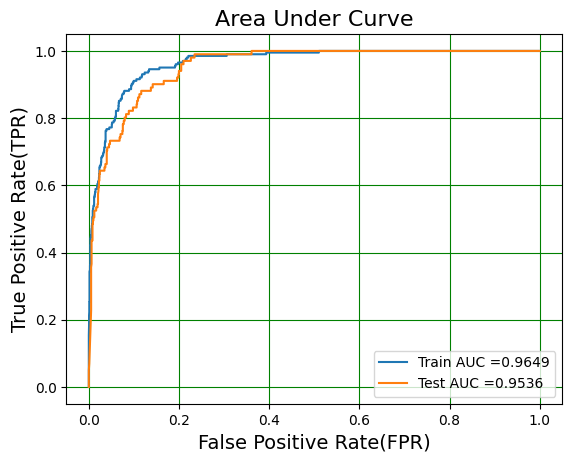

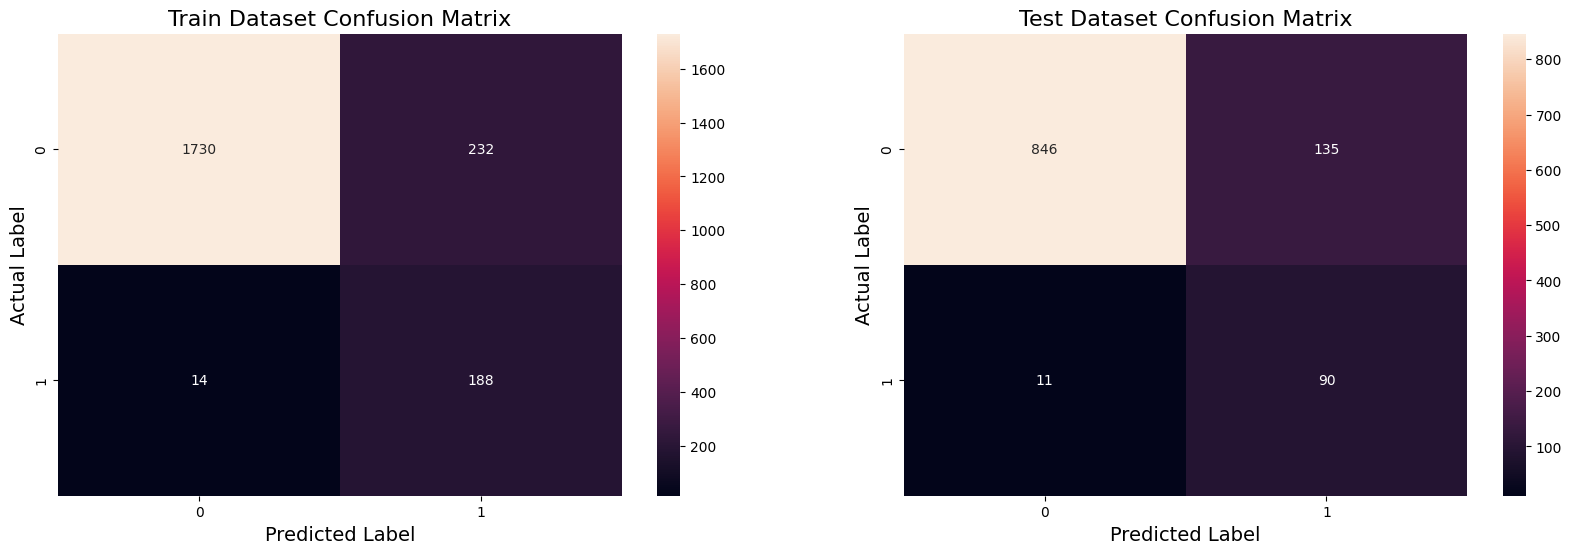

Best Threshold = 0.1142
Model AUC is : 0.9536
Model F1 Score is : 0.5521


In [106]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [107]:
combined_table.append_row(["DT + RF", "50", "0.9553", "0.5511"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## BaseLearner - LogisticRegression

In [108]:
# LogisticRegression
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = LogisticRegression(C=0.001,penalty="l2")
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9735998829240722
Test AUC =  0.9442880067823297


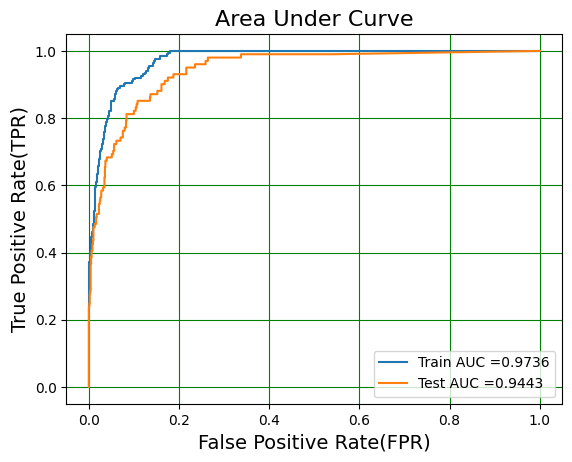

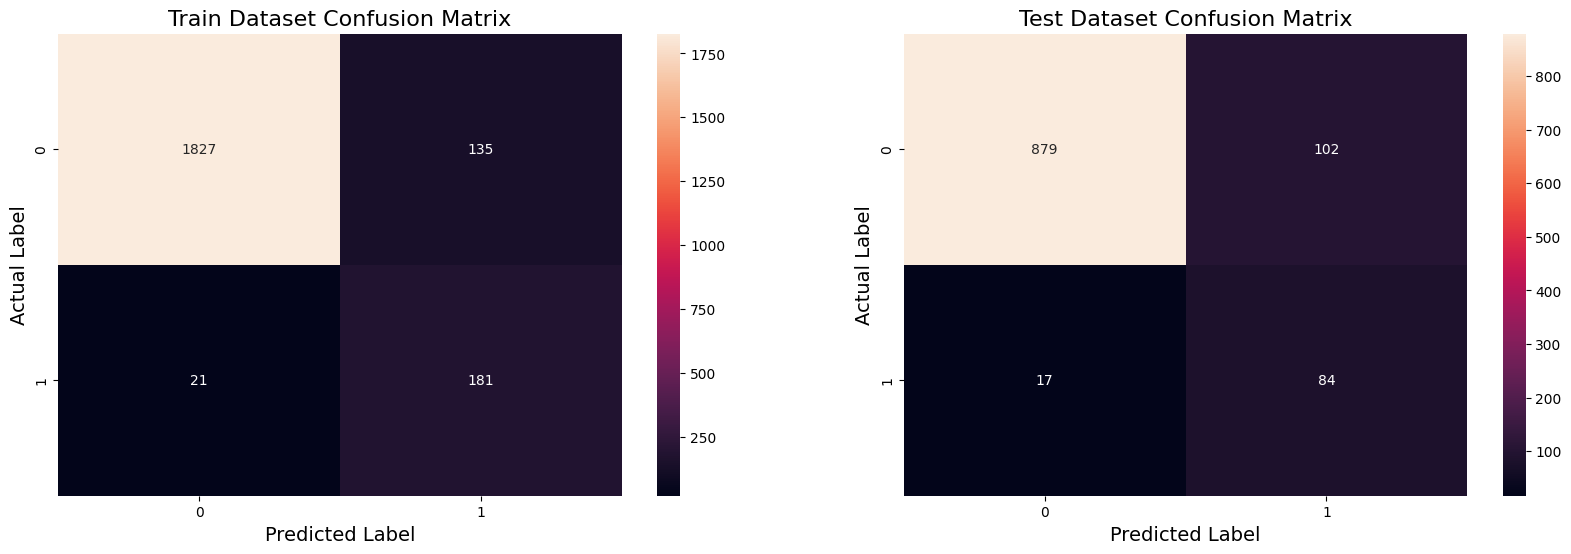

Best Threshold = 0.1929
Model AUC is : 0.9443
Model F1 Score is : 0.5854
						Number of base learners =  20
Train AUC =  0.9743694552941533
Test AUC =  0.9435916068671087


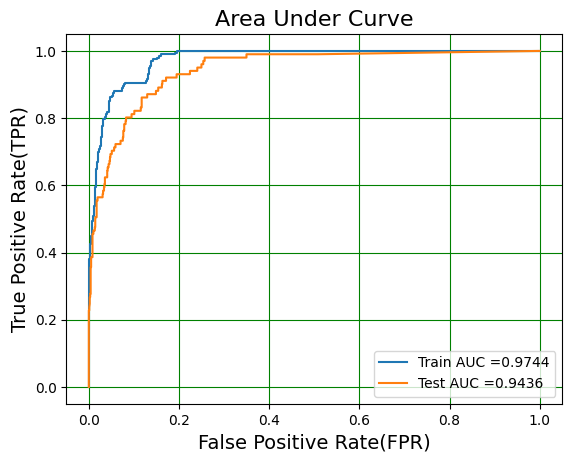

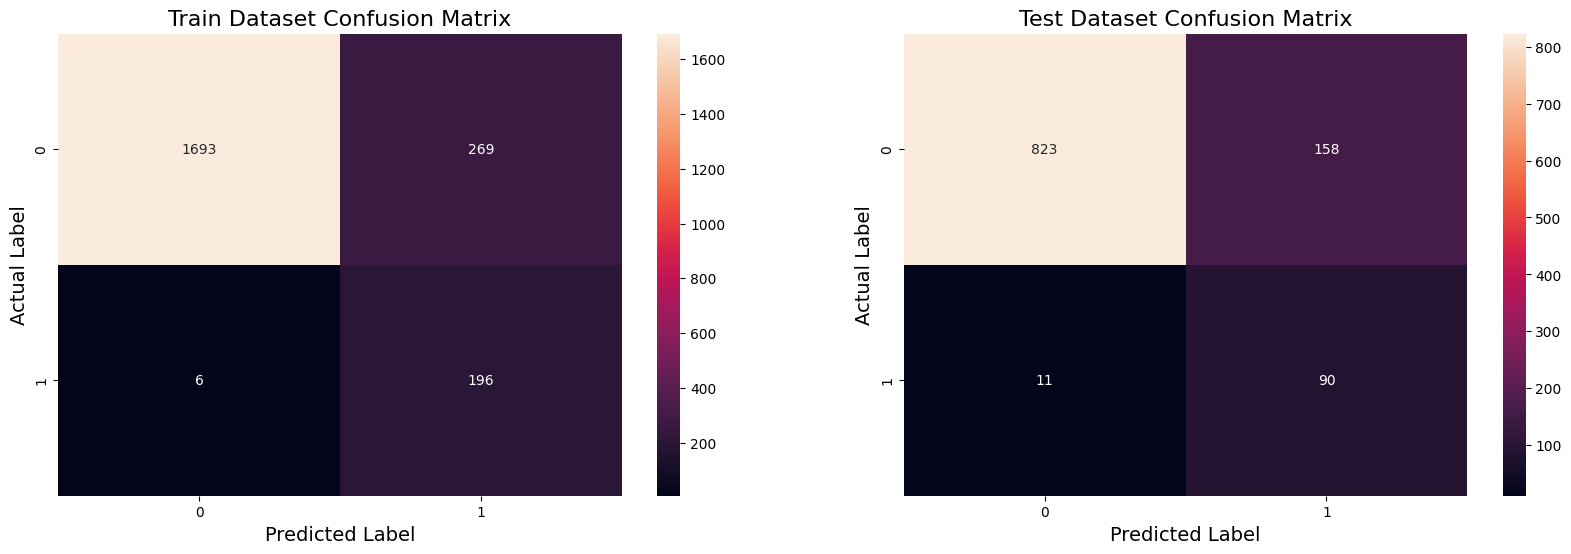

Best Threshold = 0.1093
Model AUC is : 0.9436
Model F1 Score is : 0.5158
						Number of base learners =  50
Train AUC =  0.9756764667292418
Test AUC =  0.9441265227440175


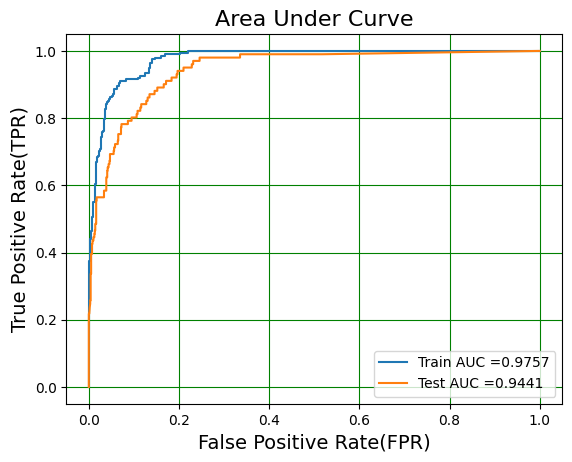

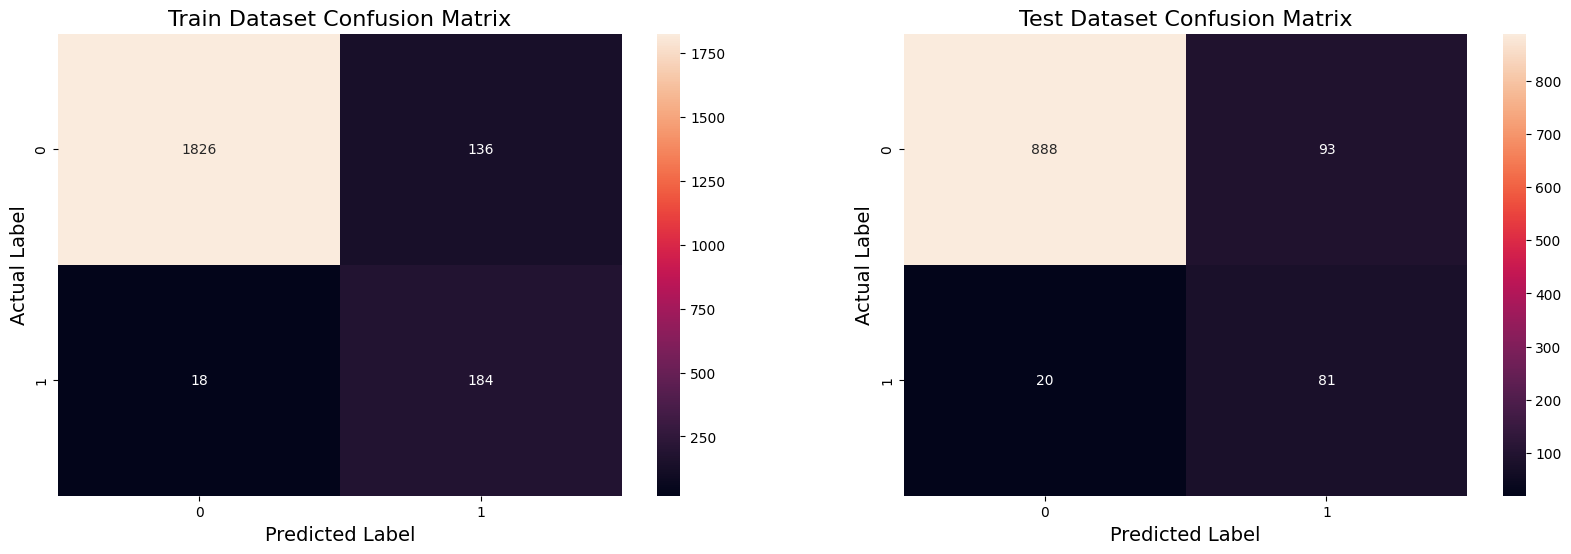

Best Threshold = 0.1883
Model AUC is : 0.9441
Model F1 Score is : 0.5891
						Number of base learners =  80
Train AUC =  0.9764182840302379
Test AUC =  0.9443737951776829


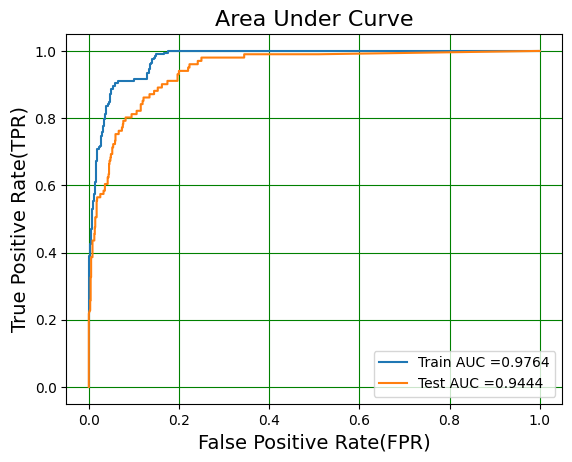

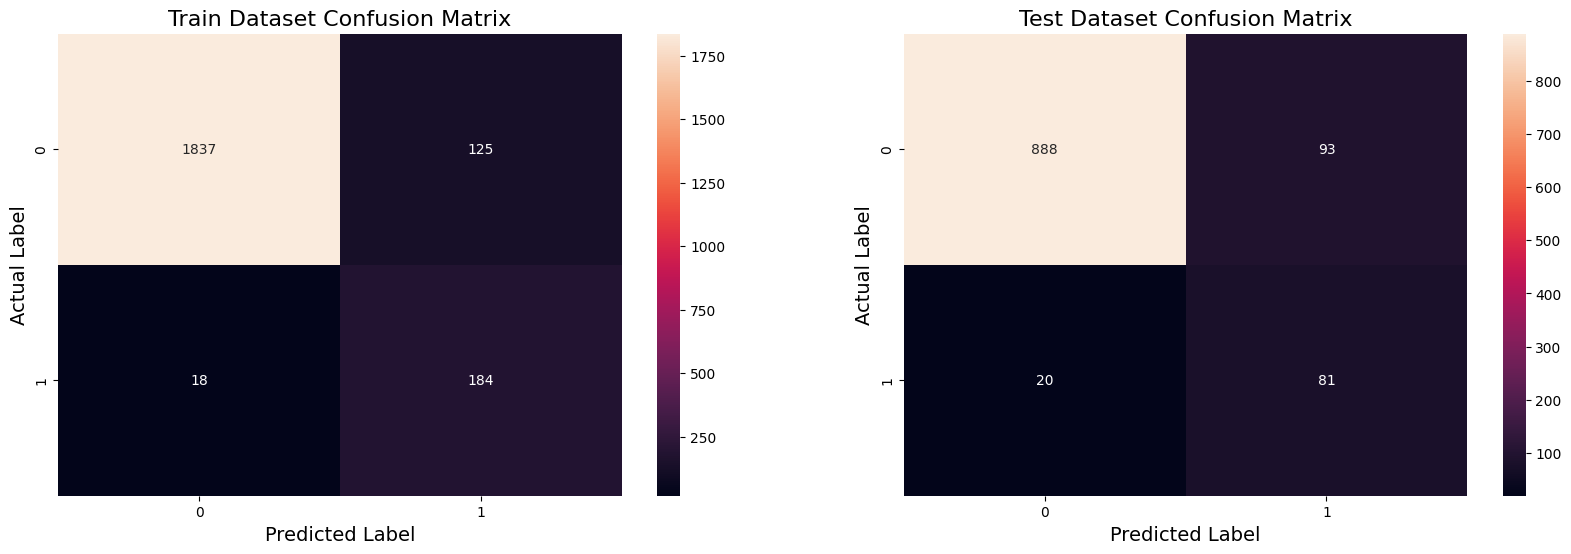

Best Threshold = 0.1890
Model AUC is : 0.9444
Model F1 Score is : 0.5891
						Number of base learners =  100
Train AUC =  0.9774830694078581
Test AUC =  0.9441366154964119


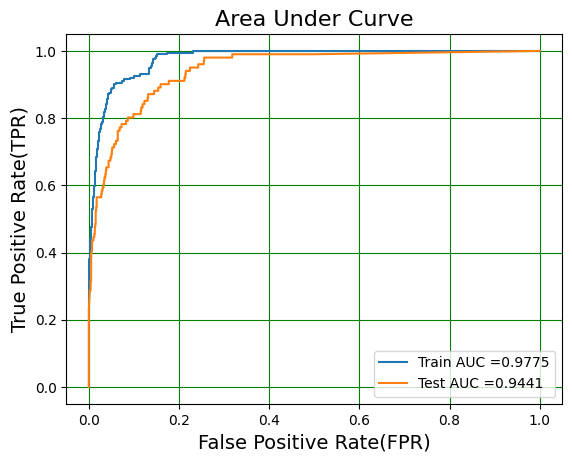

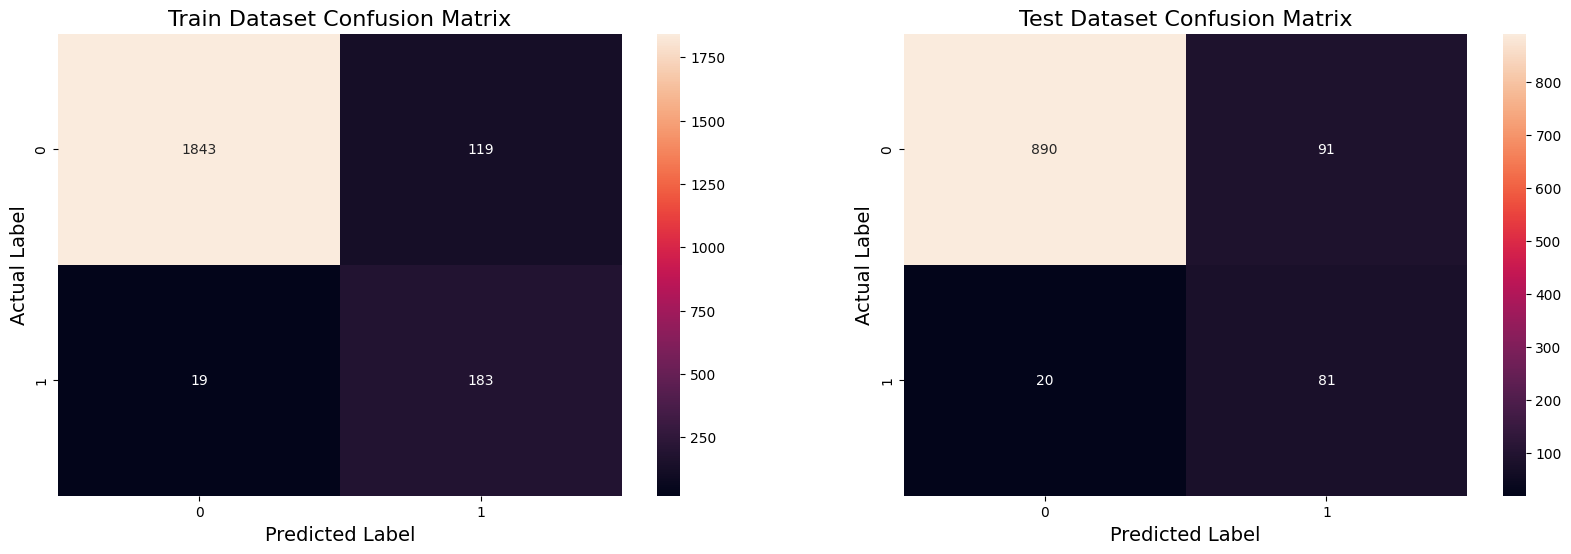

Best Threshold = 0.1985
Model AUC is : 0.9441
Model F1 Score is : 0.5934
						Number of base learners =  150
Train AUC =  0.97828796641132
Test AUC =  0.9438893430627467


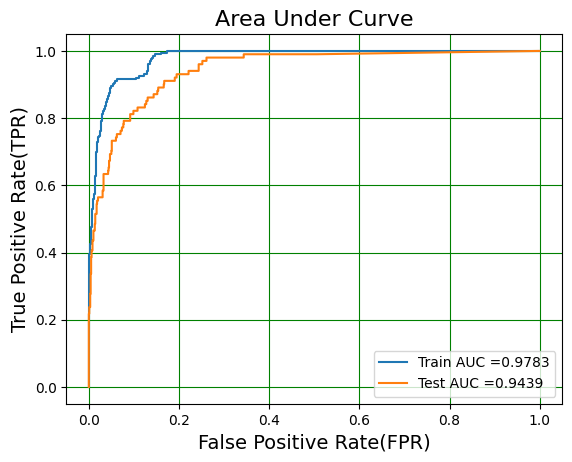

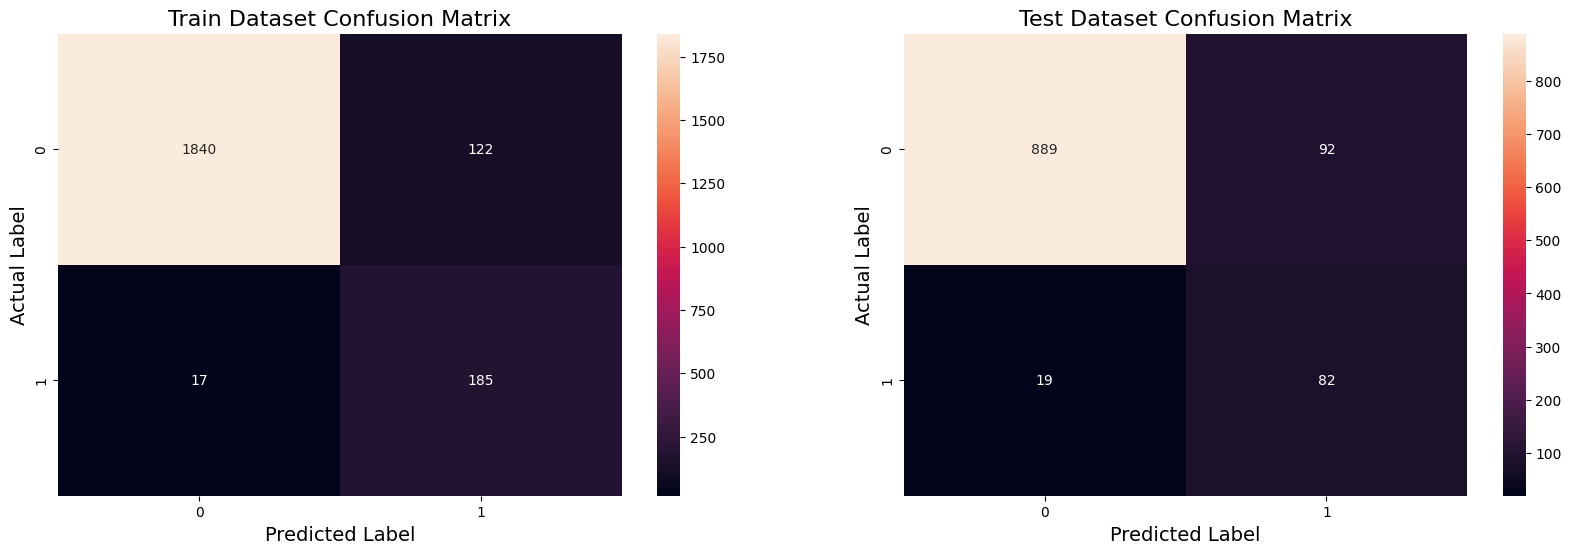

Best Threshold = 0.1919
Model AUC is : 0.9439
Model F1 Score is : 0.5964
						Number of base learners =  175
Train AUC =  0.9779372432656109
Test AUC =  0.9464024384089785


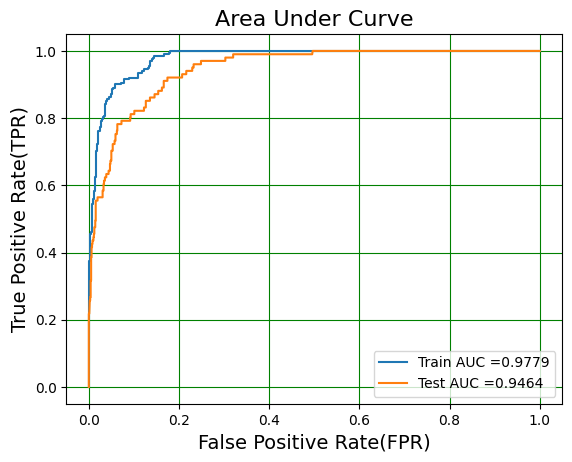

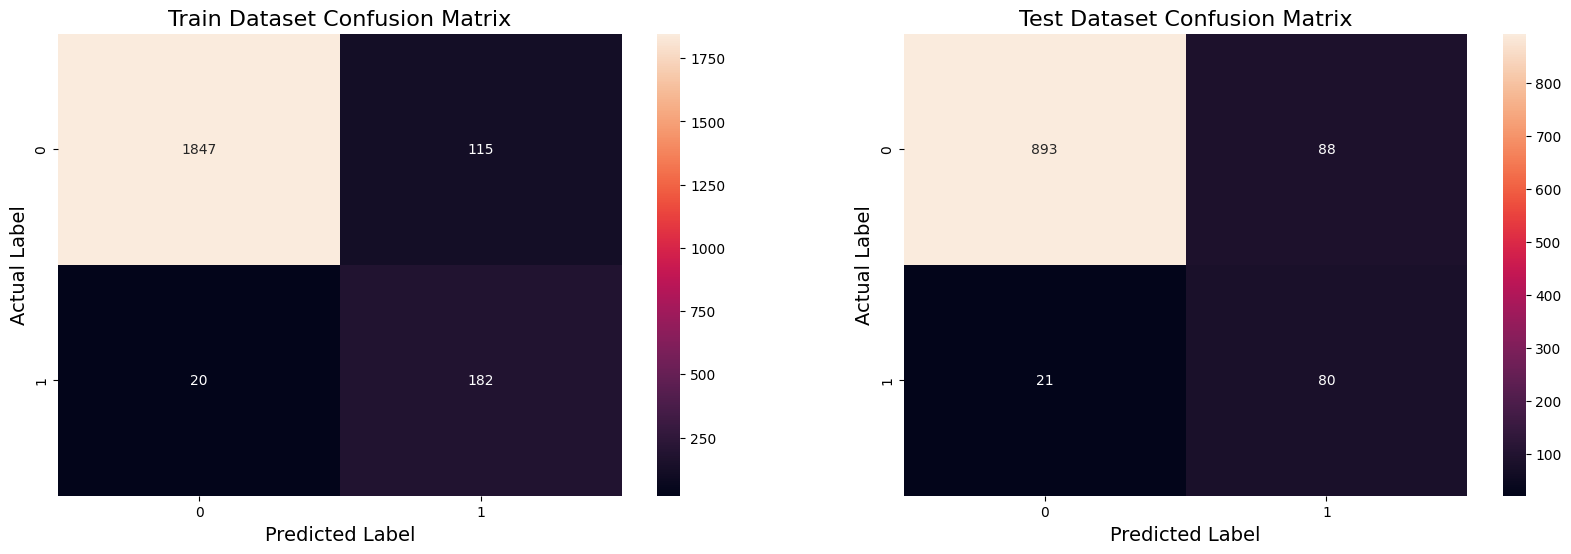

Best Threshold = 0.2002
Model AUC is : 0.9464
Model F1 Score is : 0.5948
						Number of base learners =  200
Train AUC =  0.9788632532978069
Test AUC =  0.9450045922023393


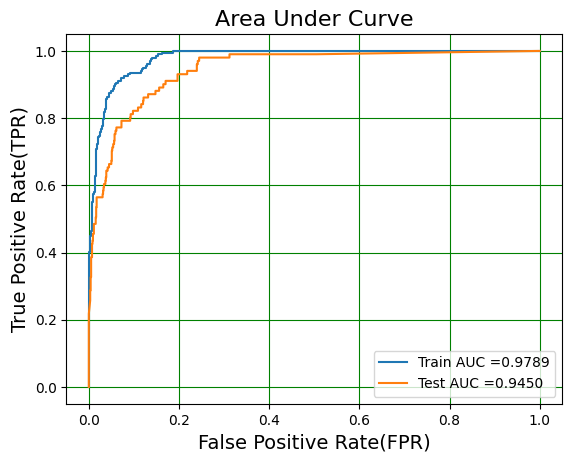

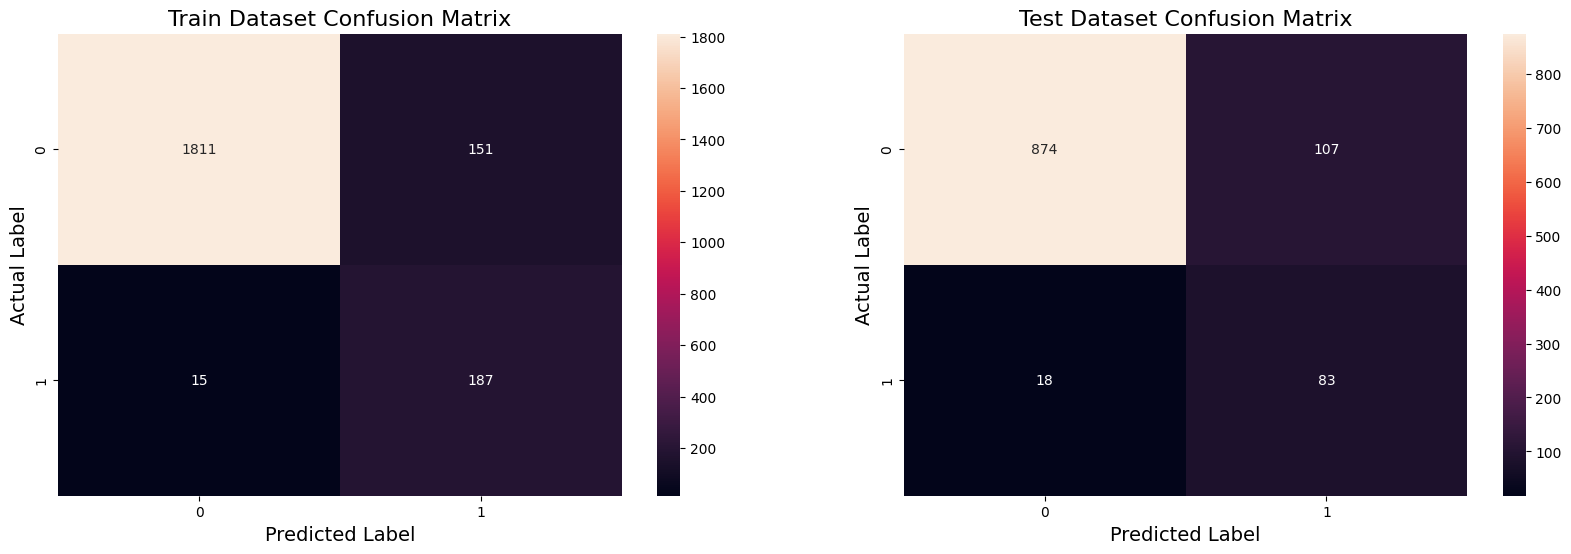

Best Threshold = 0.1746
Model AUC is : 0.9450
Model F1 Score is : 0.5704


In [109]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (RandomForestClassifier regression) using train and validation data from meta model to decide best k
    random_forest = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_features='sqrt', max_depth=5, random_state=42)
    random_forest.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = random_forest.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Number of base learns, k = 80 working best when base learner is logistic regression. Now tune the meta model.

In [175]:
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["No of DT", "Meta Model", "AUC", "F1 Score"]
table.append_row(["10", "Random Forest", "0.9443", "0.5854"])
table.append_row(["20", "Random Forest", "0.9436", "0.5158"])
table.append_row(["50", "Random Forest", "0.9441", "0.5891"])
table.append_row(["80", "Random Forest", "0.9444", "0.5891"])
table.append_row(["100", "Random Forest", "0.9441", "0.5934"])
table.append_row(["150", "Random Forest", "0.9439", "0.5964"])
table.append_row(["175", "Random Forest", "0.9464", "0.5948"])
table.append_row(["200", "Random Forest", "0.9450", "0.5704"])

print(table)

+----------+---------------+-------+----------+
| No of DT |  Meta Model   |  AUC  | F1 Score |
+----------+---------------+-------+----------+
|    10    | Random Forest | 0.944 |  0.585   |
+----------+---------------+-------+----------+
|    20    | Random Forest | 0.944 |  0.516   |
+----------+---------------+-------+----------+
|    50    | Random Forest | 0.944 |  0.589   |
+----------+---------------+-------+----------+
|    80    | Random Forest | 0.944 |  0.589   |
+----------+---------------+-------+----------+
|   100    | Random Forest | 0.944 |  0.593   |
+----------+---------------+-------+----------+
|   150    | Random Forest | 0.944 |  0.596   |
+----------+---------------+-------+----------+
|   175    | Random Forest | 0.946 |  0.595   |
+----------+---------------+-------+----------+
|   200    | Random Forest | 0.945 |   0.57   |
+----------+---------------+-------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


#### Meta model = Random Forest

In [111]:
# create 80 sampled dataset
k = 80
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [112]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [113]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [114]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 5}
roc_auc_score : 0.9317705337115297


In [115]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9753106044549409
Test AUC =  0.9433443344334433


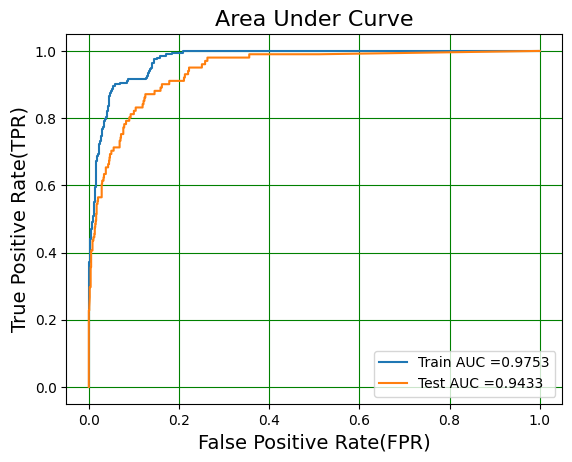

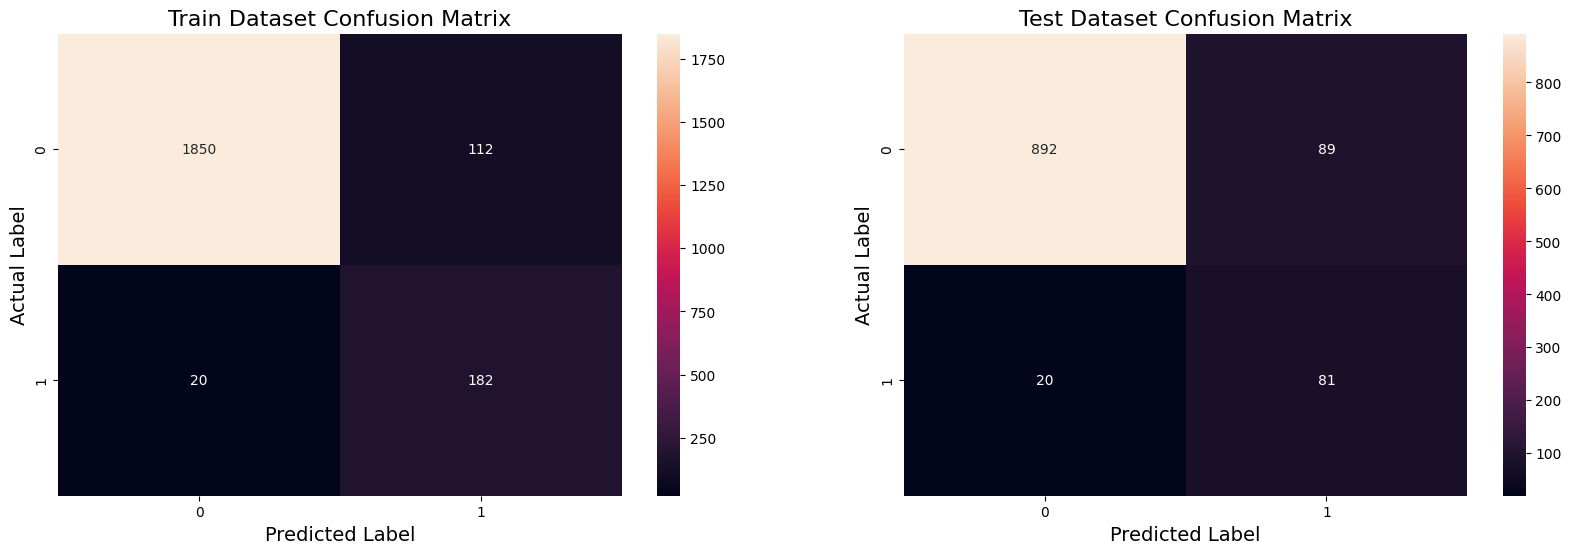

Best Threshold = 0.2049
Model AUC is : 0.9433
Model F1 Score is : 0.5978


In [116]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [117]:
combined_table.append_row(["LR + RF", "80", "0.9453", "0.6226"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


#### MetaModel - SVC

In [118]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [119]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l1'}
roc_auc_score : 0.9338492147929737


In [120]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9333070921771076
Test AUC =  0.9473562035102594


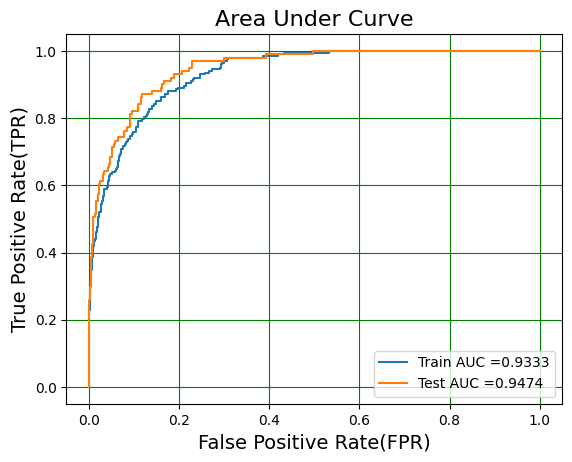

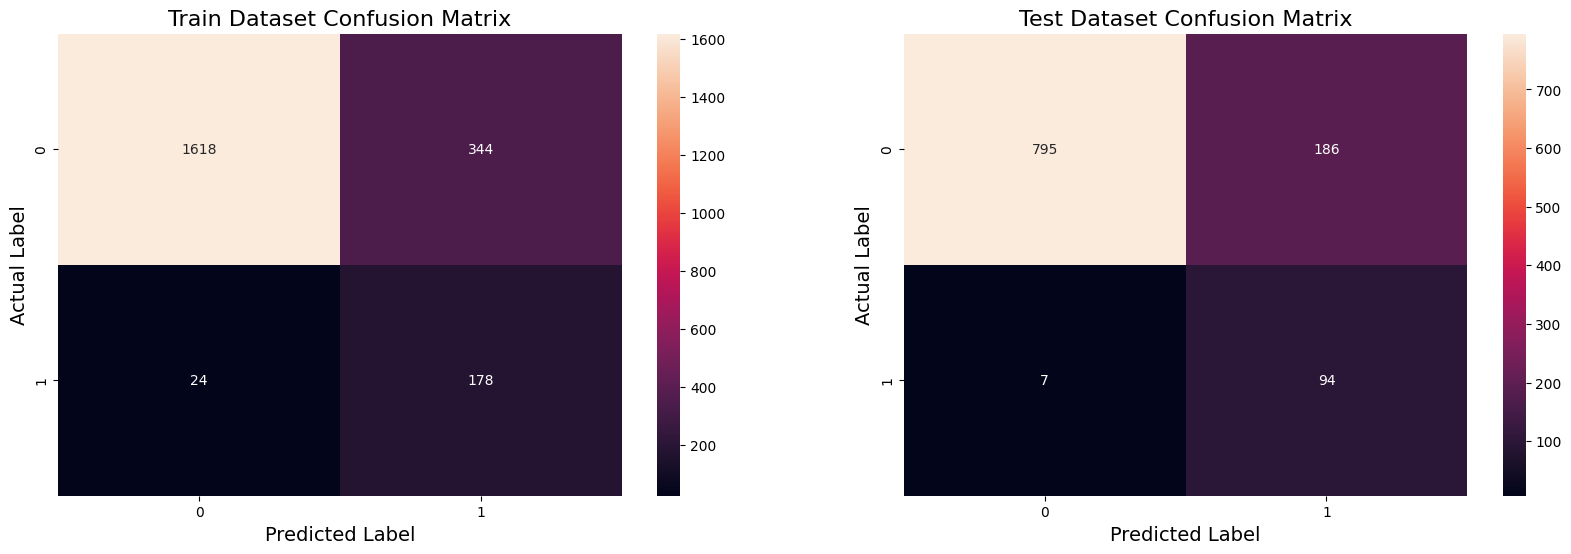

Best Threshold = 0.0548
Model AUC is : 0.9474
Model F1 Score is : 0.4934


In [121]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [122]:
combined_table.append_row(["LR + SVC", "80", "0.9485", "0.5303"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+


c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## BaseLearner - SVM with Linear Kernel

In [123]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='linear')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9386966219557735
Test AUC =  0.9619099524631363


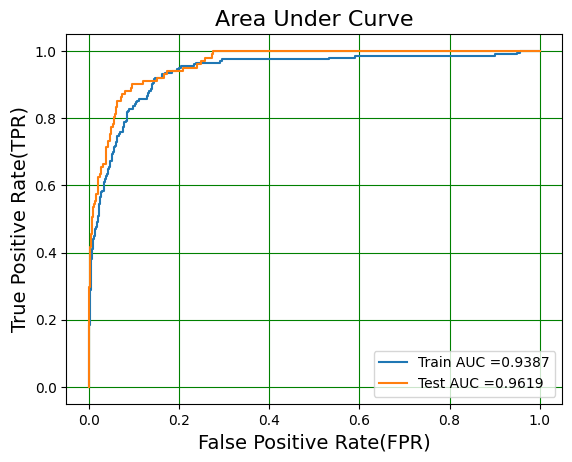

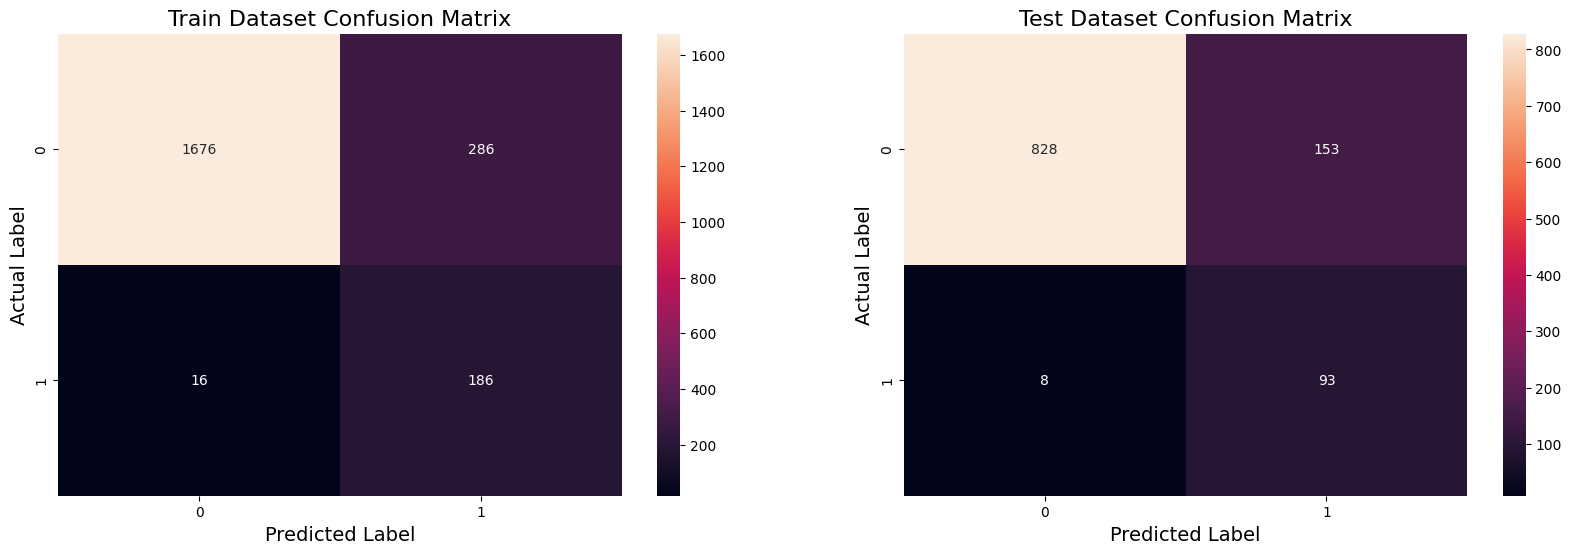

Best Threshold = 0.0933
Model AUC is : 0.9619
Model F1 Score is : 0.5360
						Number of base learners =  20
Train AUC =  0.9358984063543969
Test AUC =  0.9621118075110263


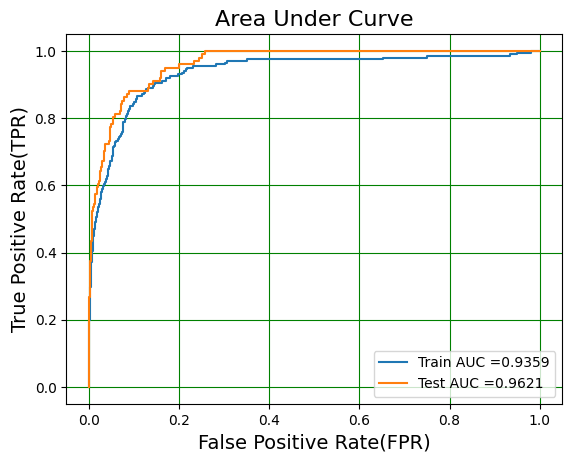

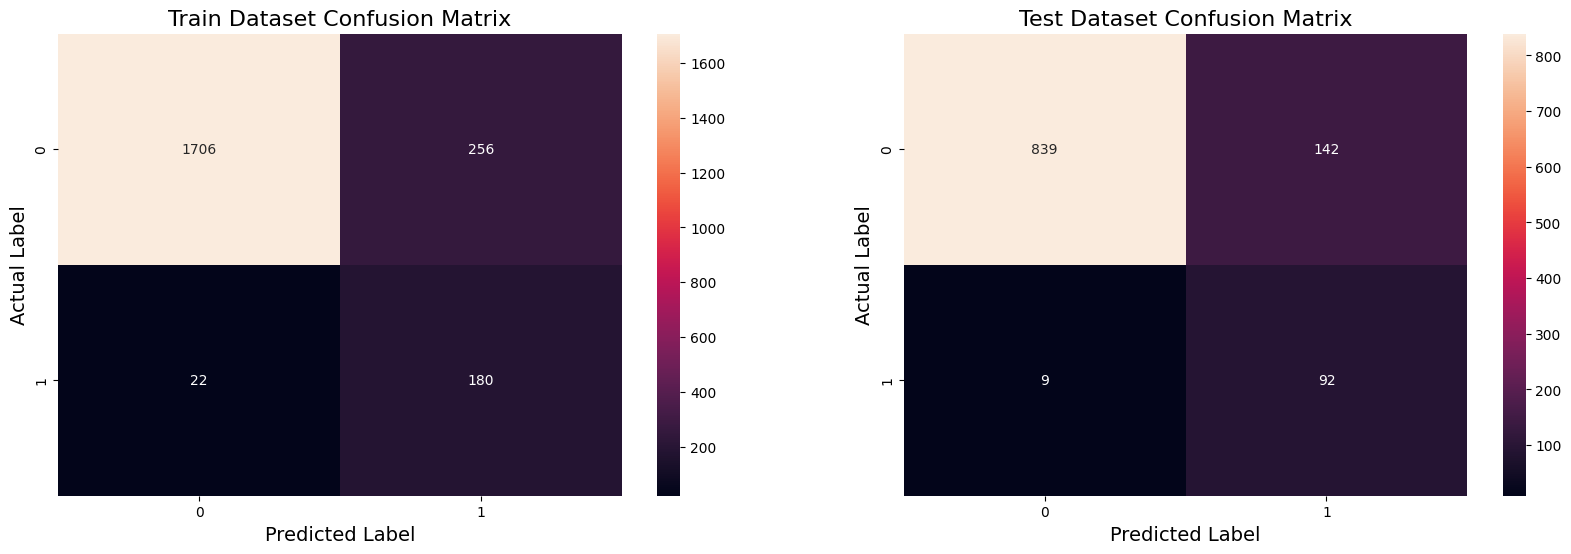

Best Threshold = 0.0931
Model AUC is : 0.9621
Model F1 Score is : 0.5493
						Number of base learners =  50
Train AUC =  0.9372760670562469
Test AUC =  0.9619806017298977


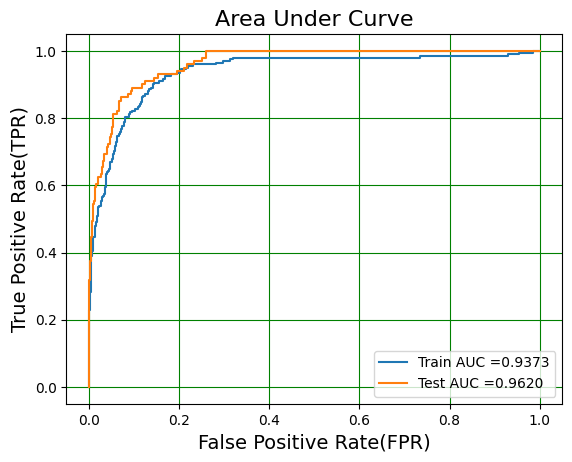

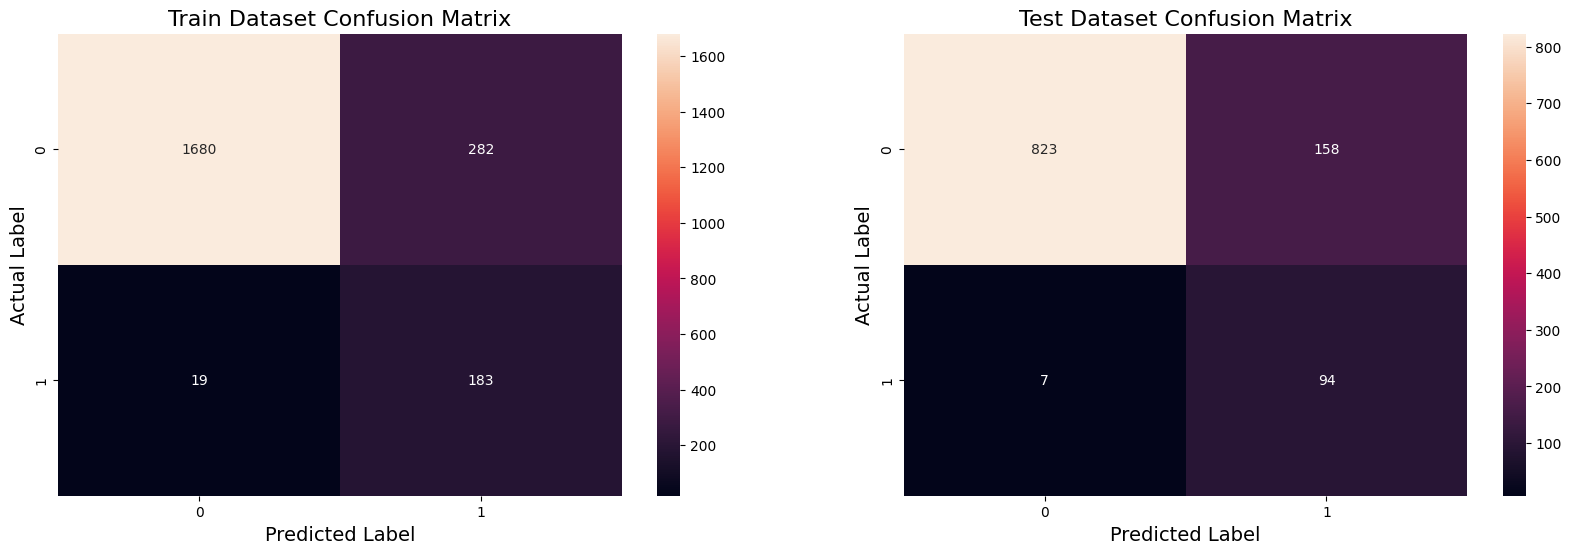

Best Threshold = 0.0928
Model AUC is : 0.9620
Model F1 Score is : 0.5326
						Number of base learners =  80
Train AUC =  0.9391558421897236
Test AUC =  0.9634844218366792


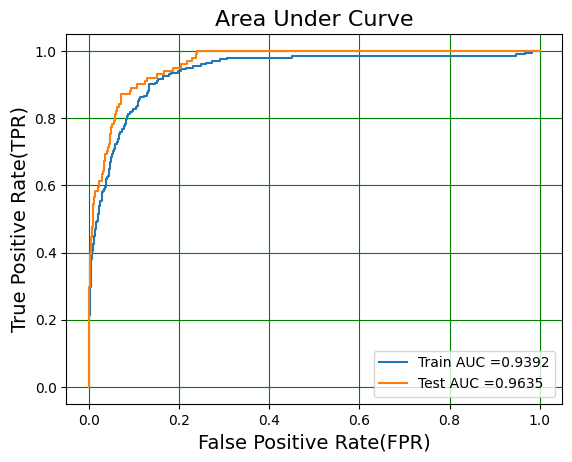

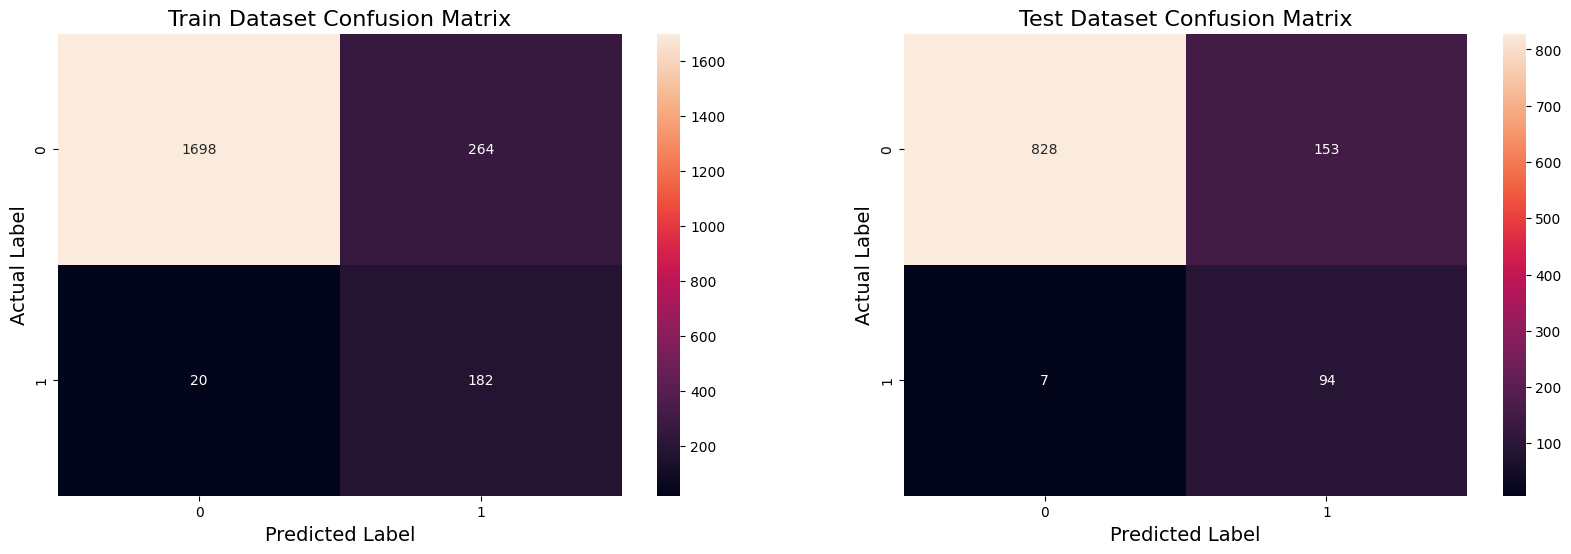

Best Threshold = 0.0925
Model AUC is : 0.9635
Model F1 Score is : 0.5402
						Number of base learners =  100
Train AUC =  0.9377125785973092
Test AUC =  0.9630403407313208


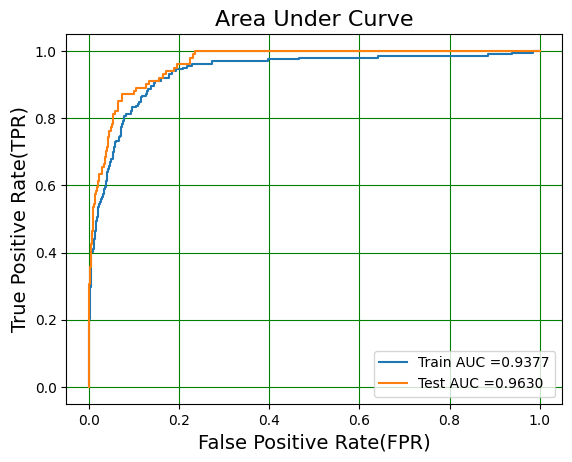

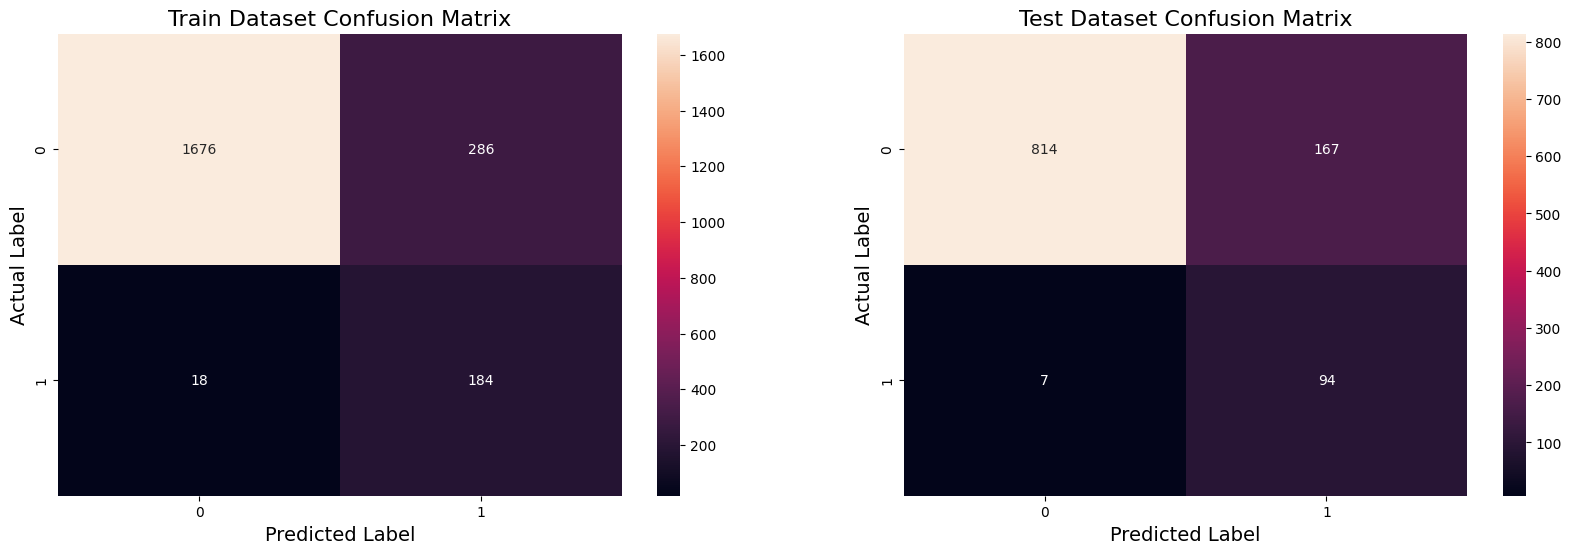

Best Threshold = 0.0921
Model AUC is : 0.9630
Model F1 Score is : 0.5193
						Number of base learners =  150
Train AUC =  0.9393980682471917
Test AUC =  0.9627577436642747


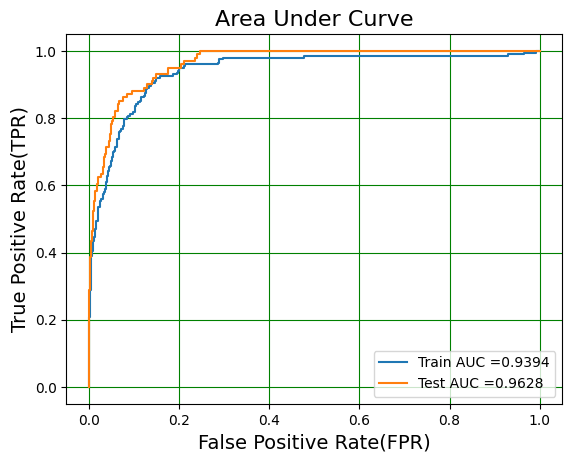

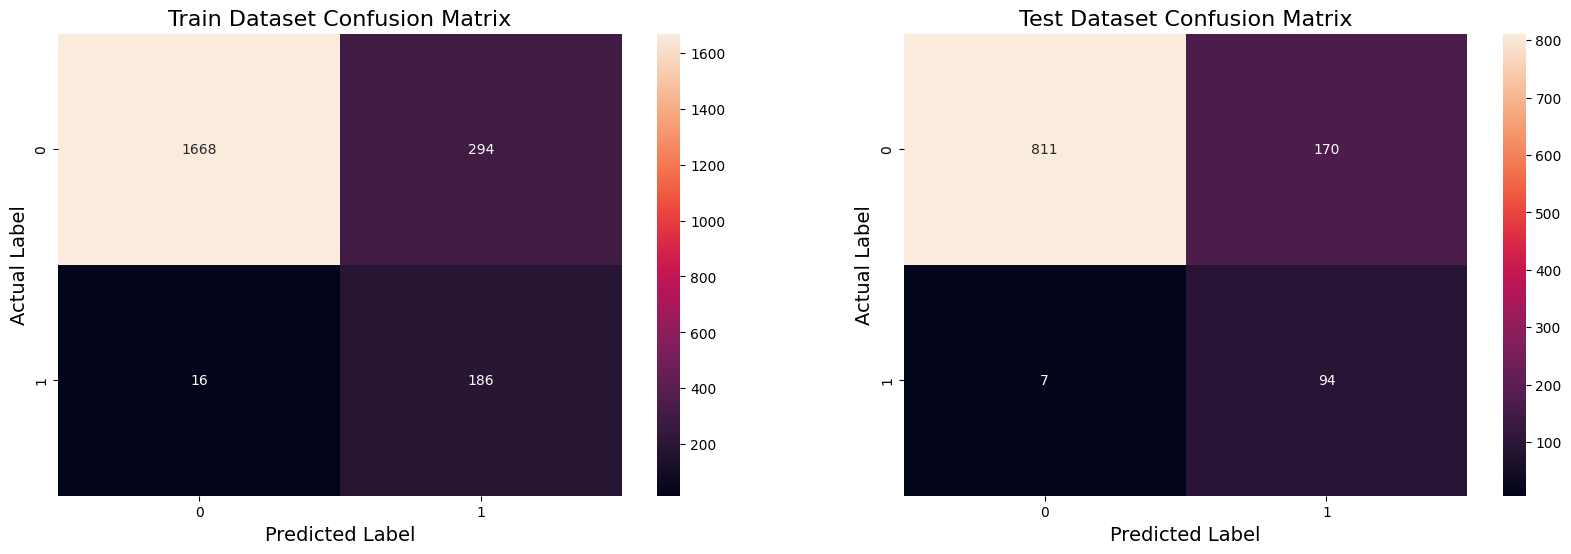

Best Threshold = 0.0913
Model AUC is : 0.9628
Model F1 Score is : 0.5151
						Number of base learners =  175
Train AUC =  0.9384316872054178
Test AUC =  0.9622732915493384


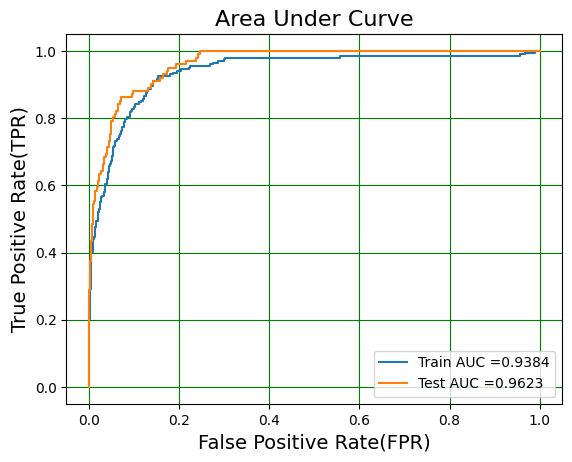

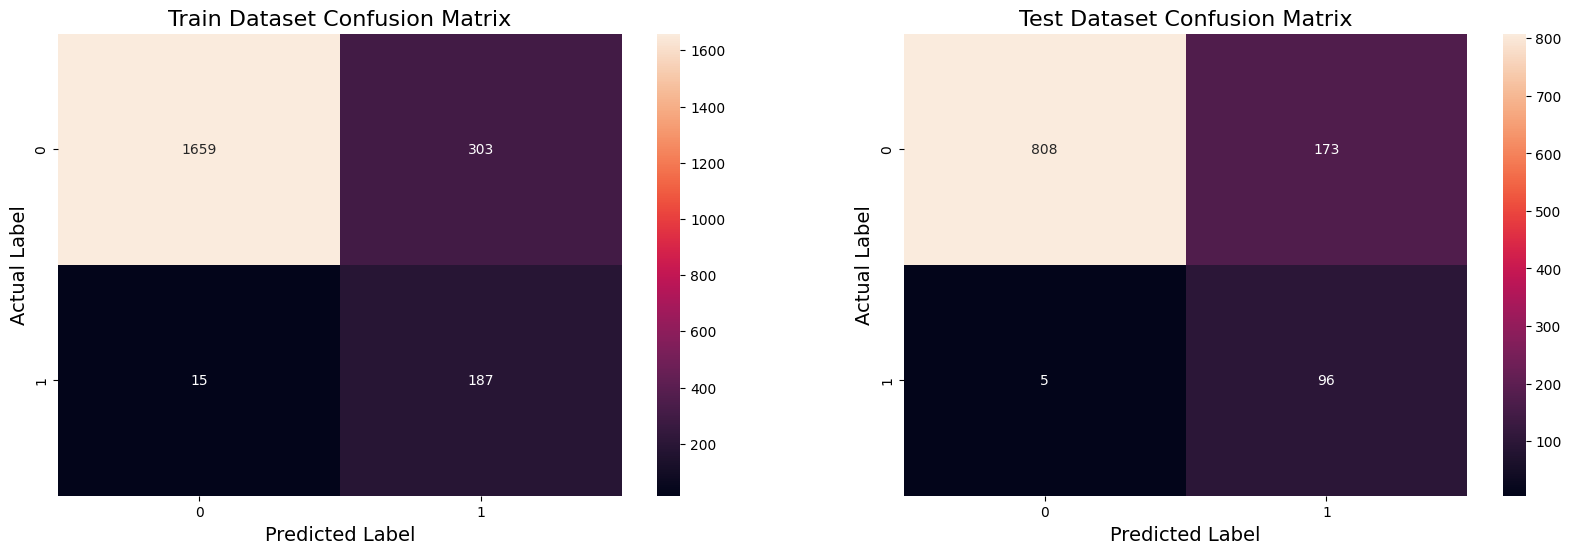

Best Threshold = 0.0910
Model AUC is : 0.9623
Model F1 Score is : 0.5189
						Number of base learners =  200
Train AUC =  0.9390372523490881
Test AUC =  0.9626971871499077


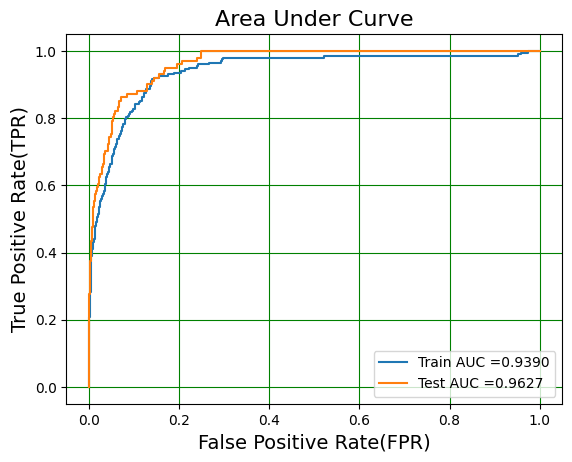

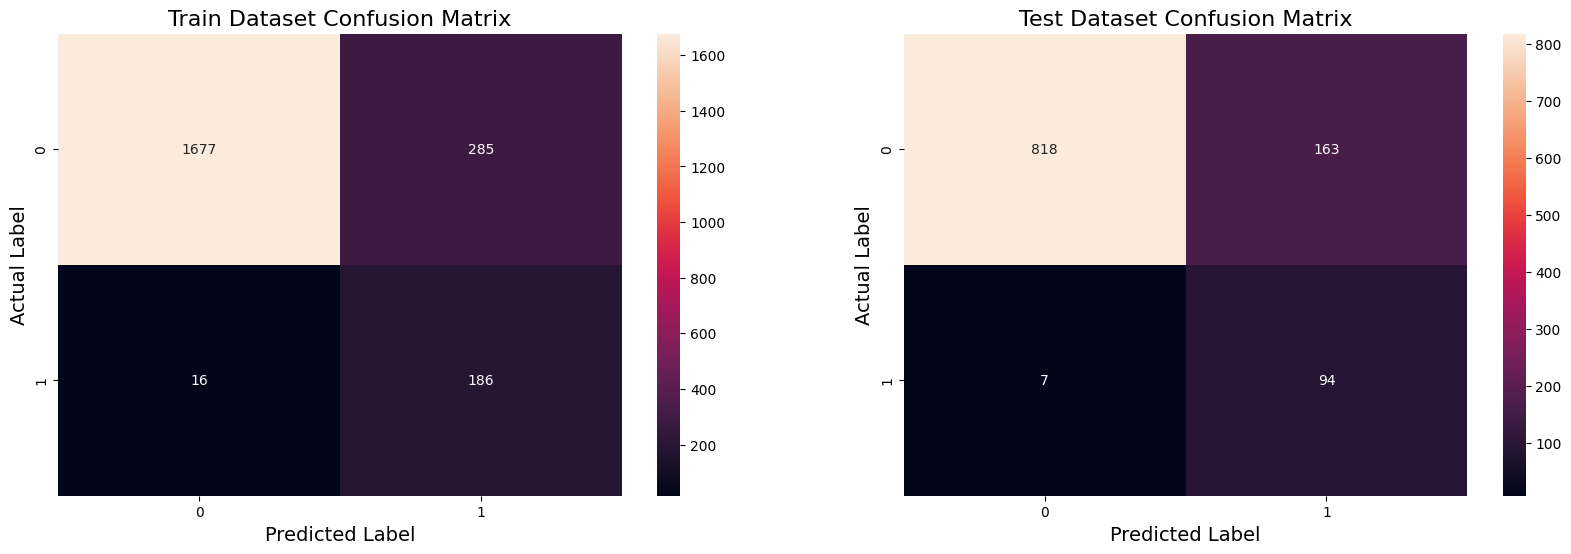

Best Threshold = 0.0907
Model AUC is : 0.9627
Model F1 Score is : 0.5251


In [176]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.0001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Model is working best when number of base learners, k = 50 when base learner is SVM with linear kernel.

In [181]:
table.column_headers= ["No of DT", "Meta Model", "AUC", "F1 Score"]
table.clear()
table.append_row(["10", "SVM with Linear Kernel", "0.9619", "0.5360"])
table.append_row(["20", "SVM with Linear Kernel", "0.9621", "0.5493"])
table.append_row(["50", "SVM with Linear Kernel", "0.9620", "0.5326"])
table.append_row(["80", "SVM with Linear Kernel", "0.9635", "0.5402"])
table.append_row(["100", "SVM with Linear Kernel", "0.9630", "0.5193"])
table.append_row(["150", "SVM with Linear Kernel", "0.9628", "0.5151"])
table.append_row(["175", "SVM with Linear Kernel", "0.9623", "0.5189"])
table.append_row(["200", "SVM with Linear Kernel", "0.9627", "0.5251"])
print(table)

+----------+------------------------+-------+----------+
| No of DT |       Meta Model       |  AUC  | F1 Score |
+----------+------------------------+-------+----------+
|    10    | SVM with Linear Kernel | 0.962 |  0.536   |
+----------+------------------------+-------+----------+
|    20    | SVM with Linear Kernel | 0.962 |  0.549   |
+----------+------------------------+-------+----------+
|    50    | SVM with Linear Kernel | 0.962 |  0.533   |
+----------+------------------------+-------+----------+
|    80    | SVM with Linear Kernel | 0.964 |   0.54   |
+----------+------------------------+-------+----------+
|   100    | SVM with Linear Kernel | 0.963 |  0.519   |
+----------+------------------------+-------+----------+
|   150    | SVM with Linear Kernel | 0.963 |  0.515   |
+----------+------------------------+-------+----------+
|   175    | SVM with Linear Kernel | 0.962 |  0.519   |
+----------+------------------------+-------+----------+
|   200    | SVM with Linear Ke

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


Now use k=50 and different meta model.

#### Meta Model = LogisticRegression

In [125]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [126]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [127]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kapil\AppDat

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [128]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9384325536675291


Train AUC =  0.9393728363662056
Test AUC =  0.963242195779211


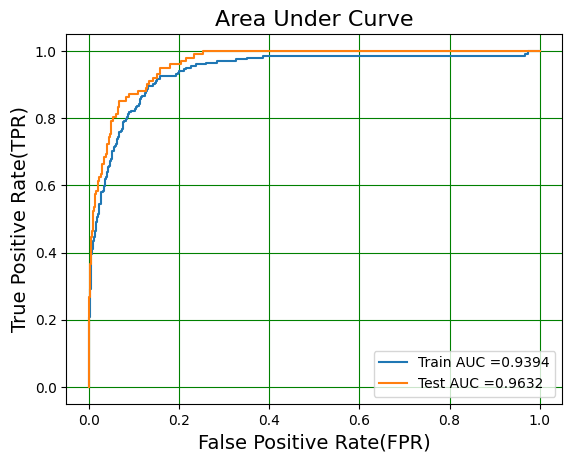

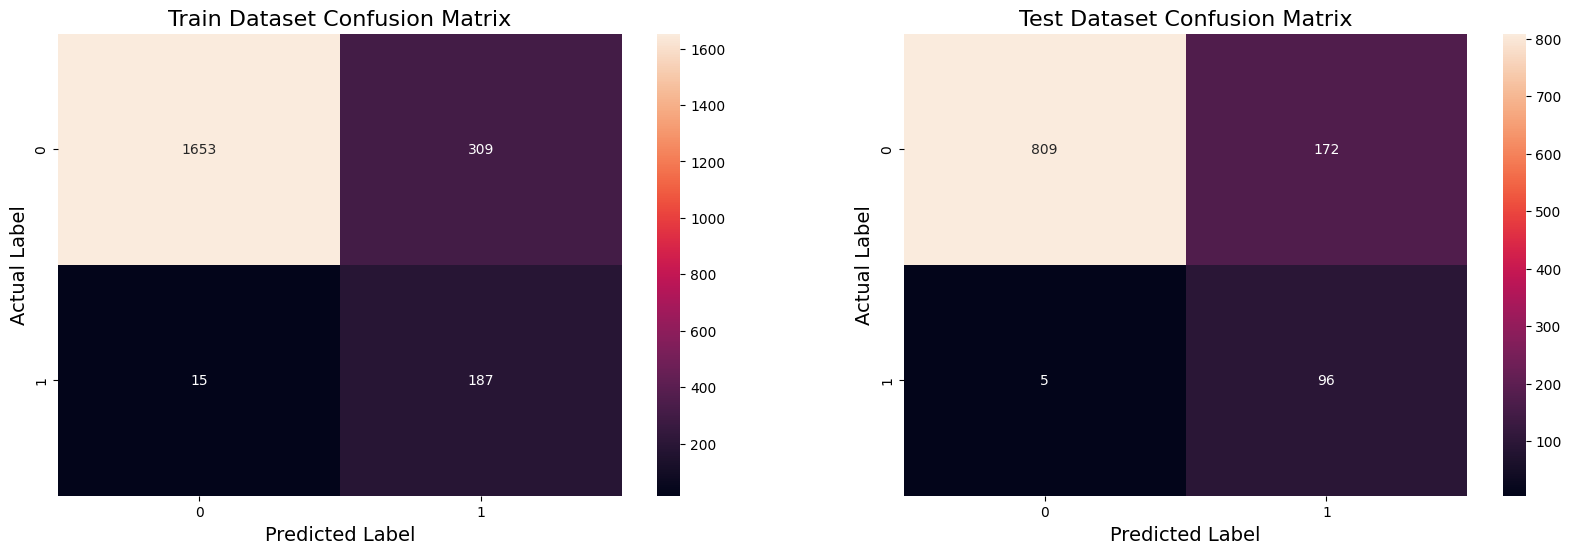

Best Threshold = 0.0521
Model AUC is : 0.9632
Model F1 Score is : 0.5203


In [129]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [130]:
combined_table.append_row(["SVM(Linear) + LR", "50", "0.9629", "0.5418"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


#### Meta Model - Random Forest

In [131]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [132]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 5}
roc_auc_score : 0.9419488534102898


In [133]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9797640314490165
Test AUC =  0.9630706189885044


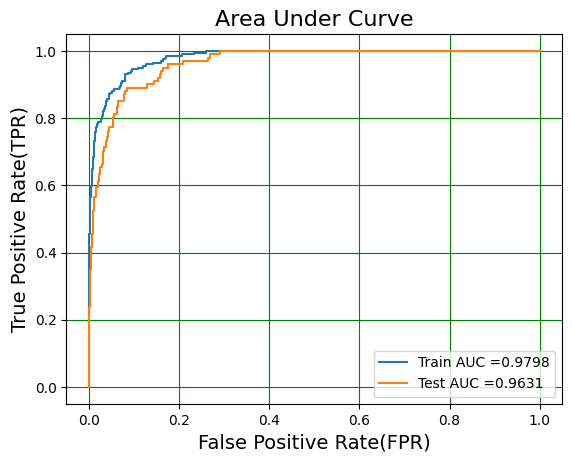

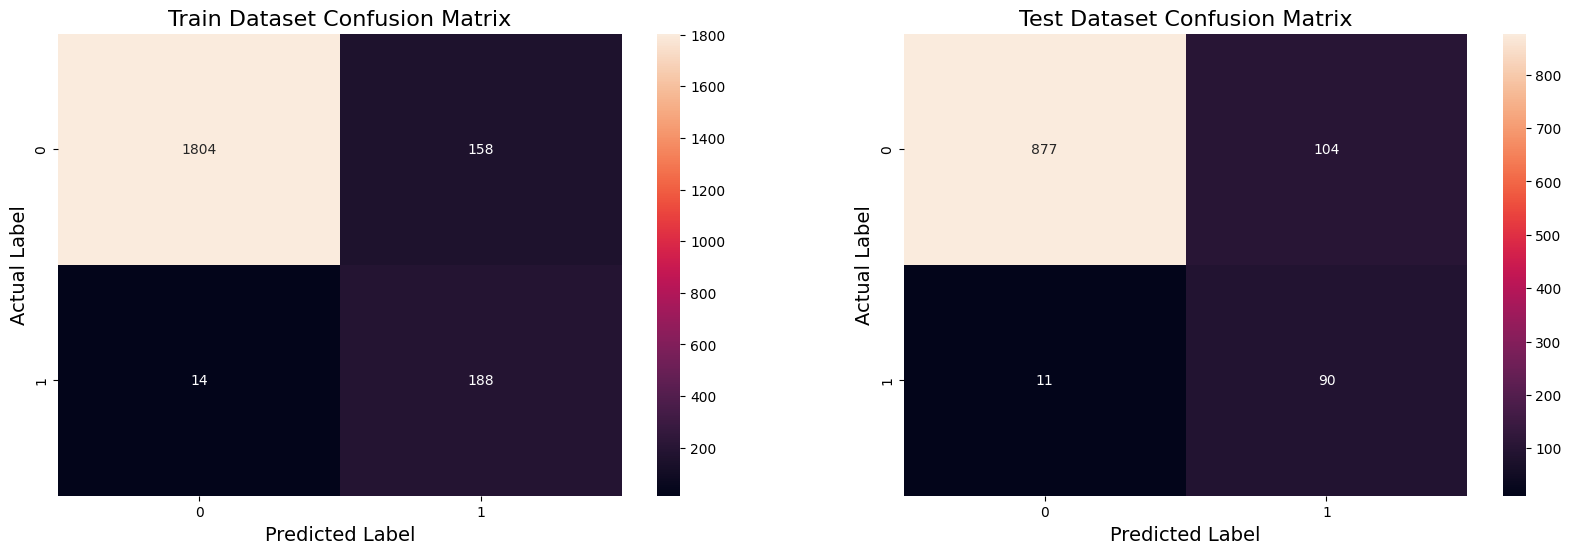

Best Threshold = 0.1629
Model AUC is : 0.9631
Model F1 Score is : 0.6102


In [134]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [135]:
combined_table.append_row(["SVM(Linear) + RF", "50", "0.9630", "0.6207"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## BaseLearner - SVM with rbf Kernel

In [136]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='rbf')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9335240863535896
Test AUC =  0.9592656513357758


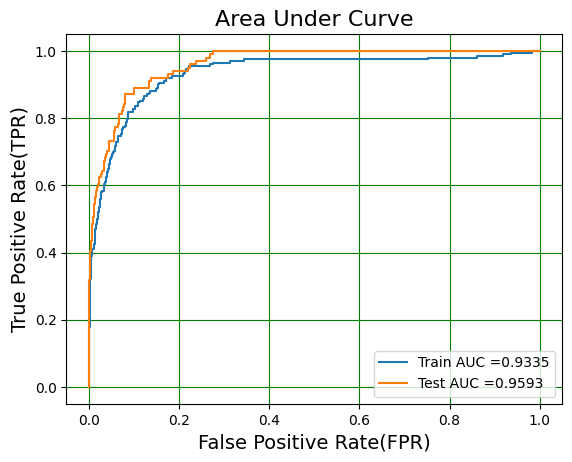

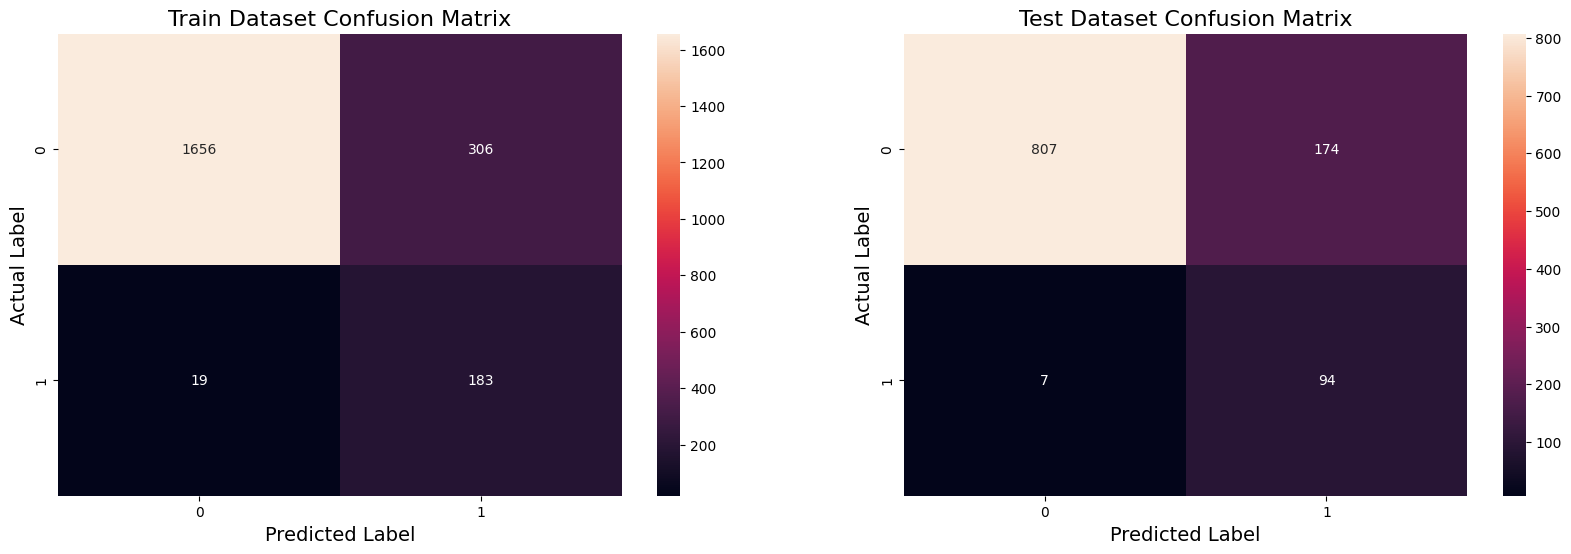

Best Threshold = 0.0921
Model AUC is : 0.9593
Model F1 Score is : 0.5095
						Number of base learners =  20
Train AUC =  0.9374627829755452
Test AUC =  0.9634743290842847


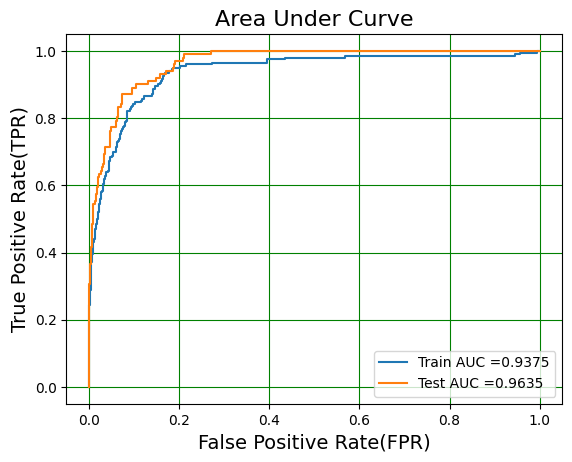

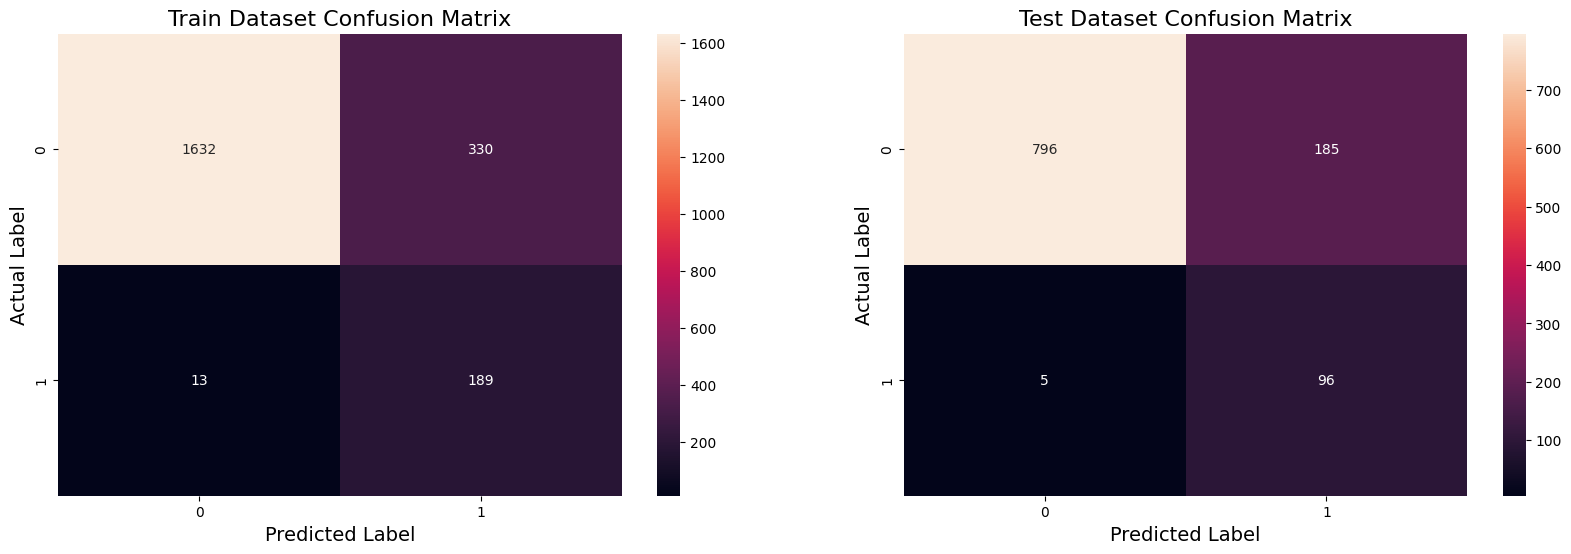

Best Threshold = 0.0902
Model AUC is : 0.9635
Model F1 Score is : 0.5026
						Number of base learners =  50
Train AUC =  0.9392895711589508
Test AUC =  0.962384311825678


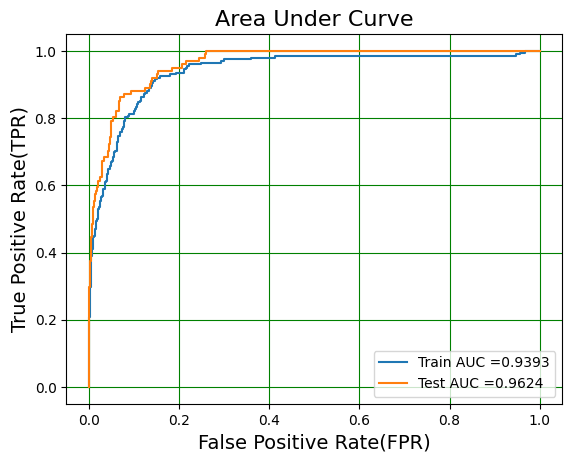

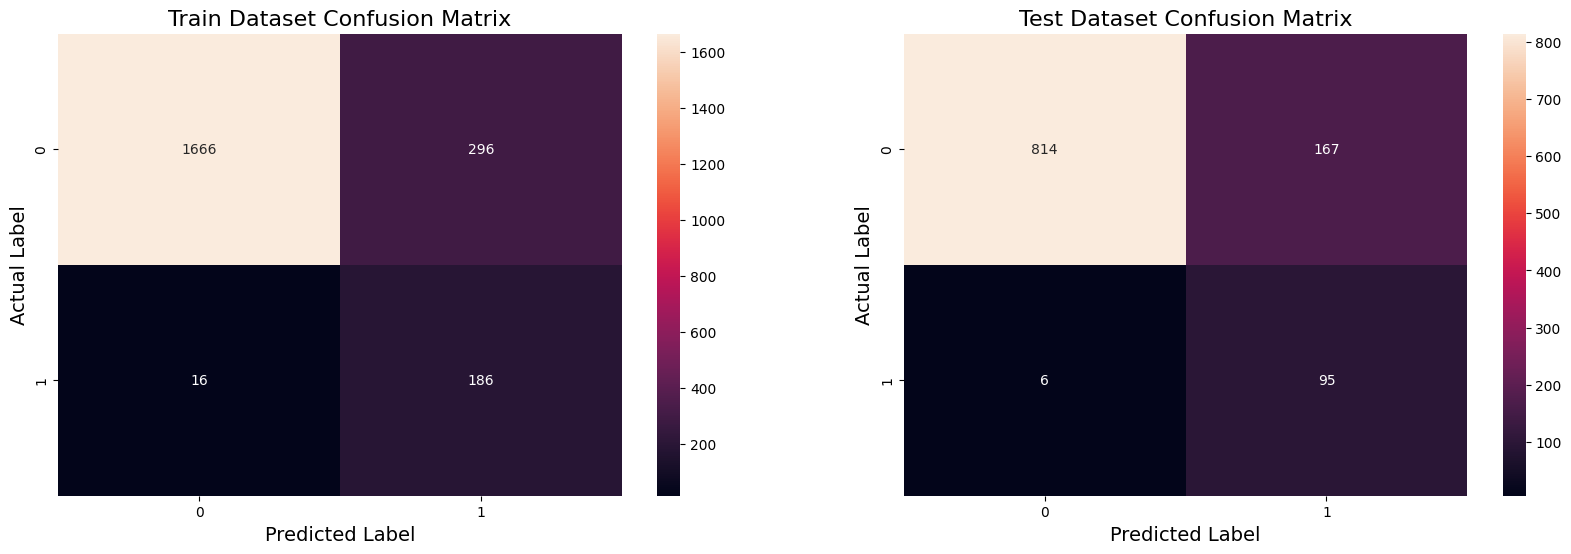

Best Threshold = 0.0853
Model AUC is : 0.9624
Model F1 Score is : 0.5234
						Number of base learners =  80
Train AUC =  0.9388278277369021
Test AUC =  0.9638174826656978


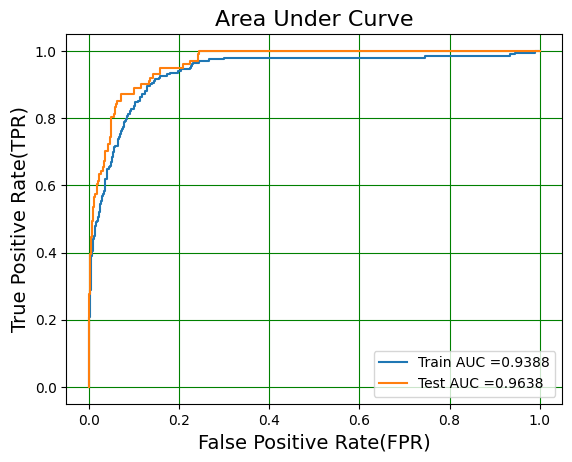

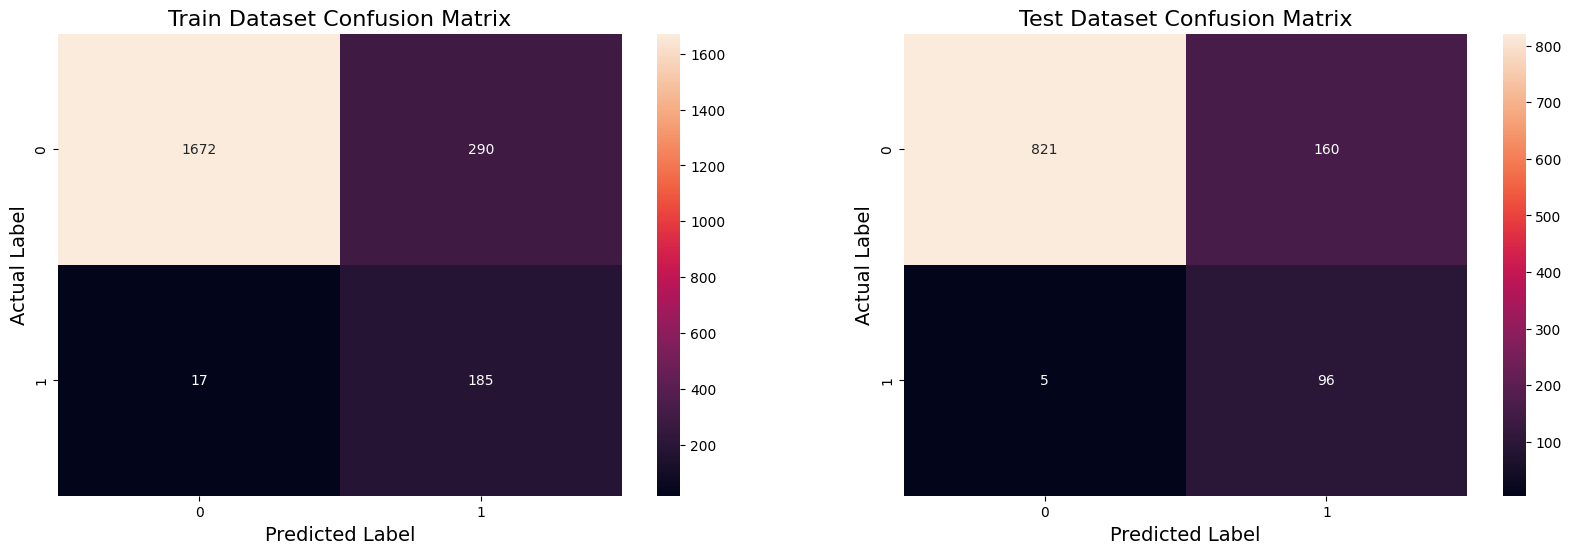

Best Threshold = 0.0822
Model AUC is : 0.9638
Model F1 Score is : 0.5378
						Number of base learners =  100
Train AUC =  0.9394258233162767
Test AUC =  0.9629192277025866


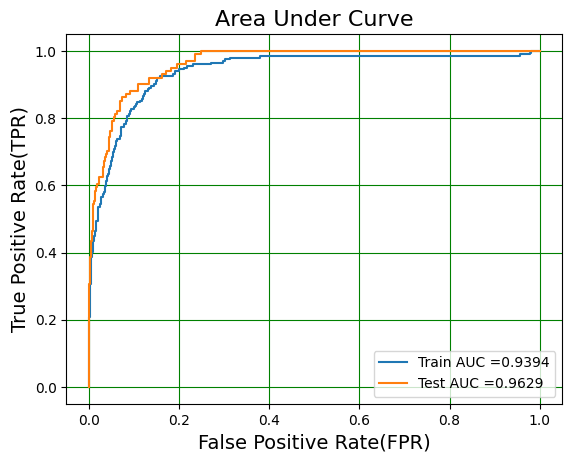

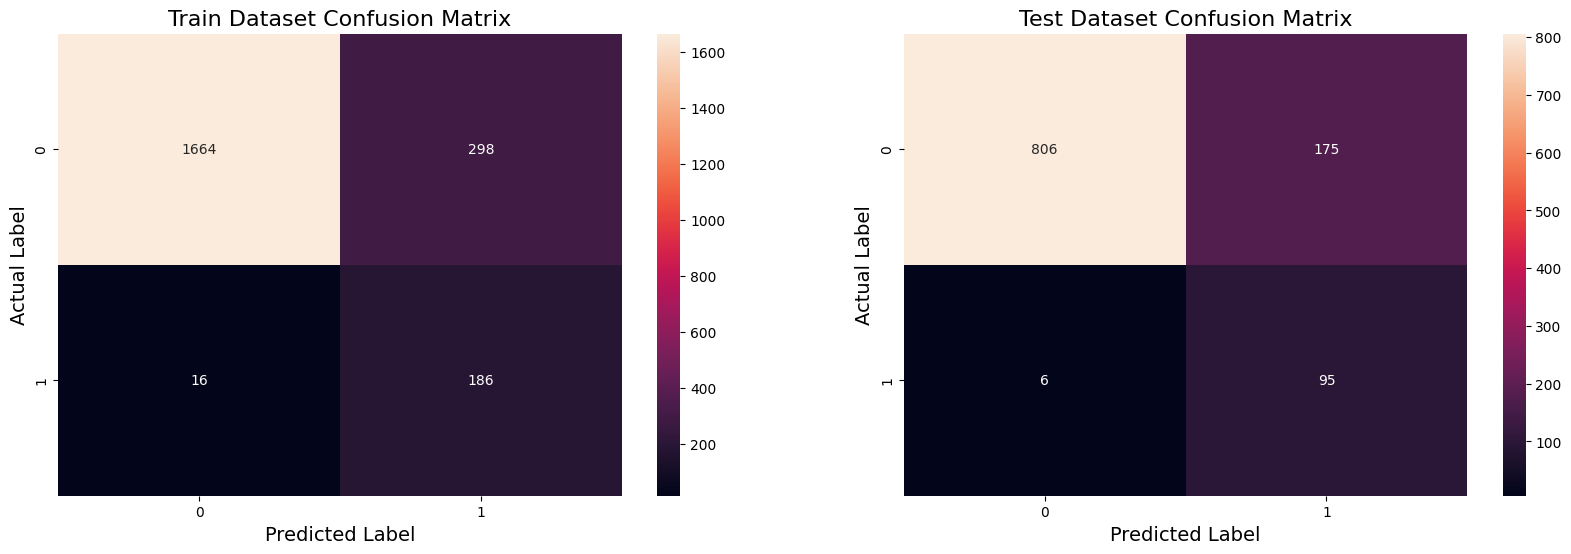

Best Threshold = 0.0792
Model AUC is : 0.9629
Model F1 Score is : 0.5121
						Number of base learners =  150
Train AUC =  0.9392567697136686
Test AUC =  0.9627779291690638


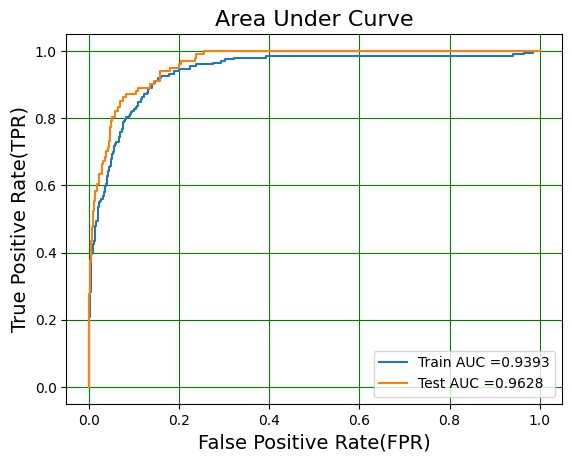

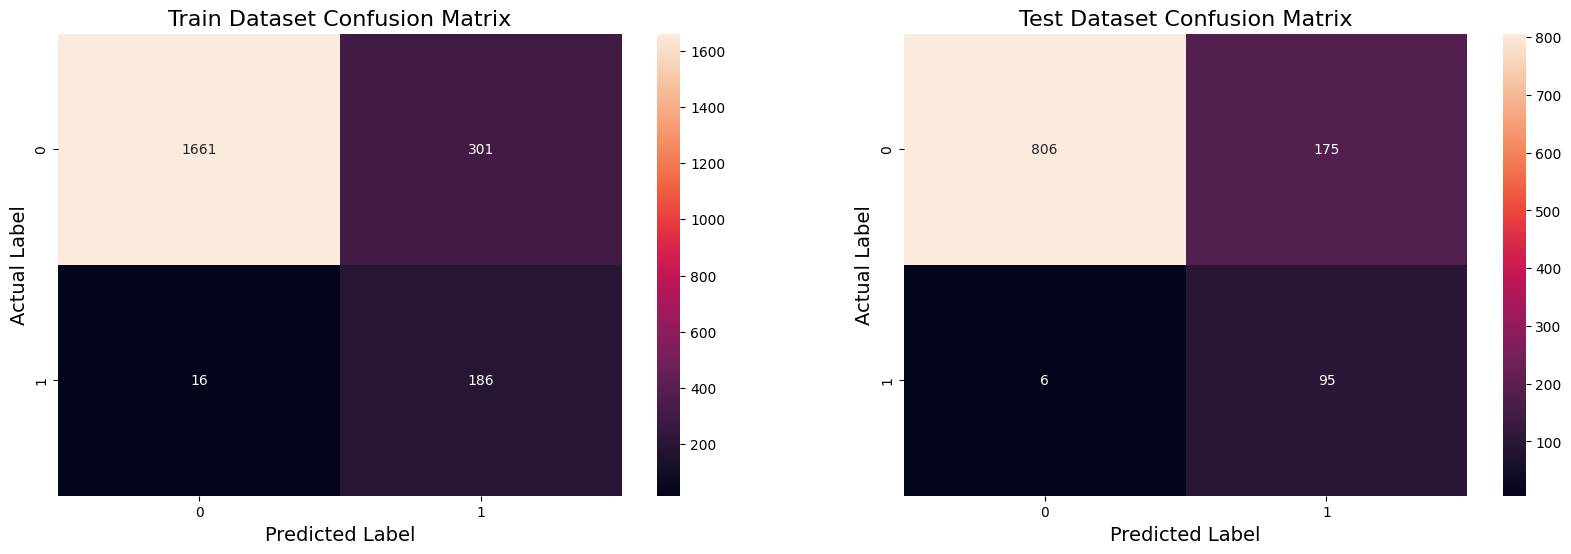

Best Threshold = 0.0751
Model AUC is : 0.9628
Model F1 Score is : 0.5121
						Number of base learners =  175
Train AUC =  0.9386108335604203
Test AUC =  0.9626568161403296


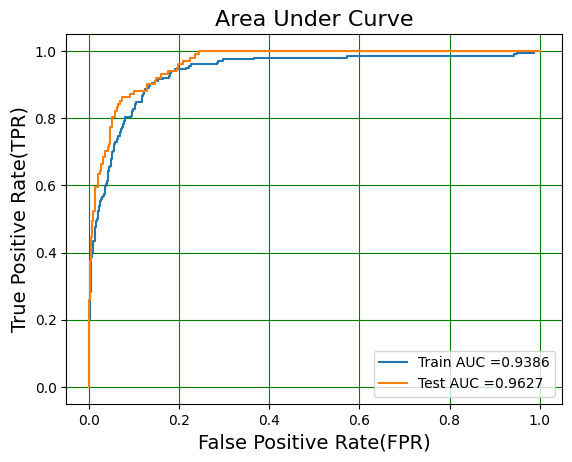

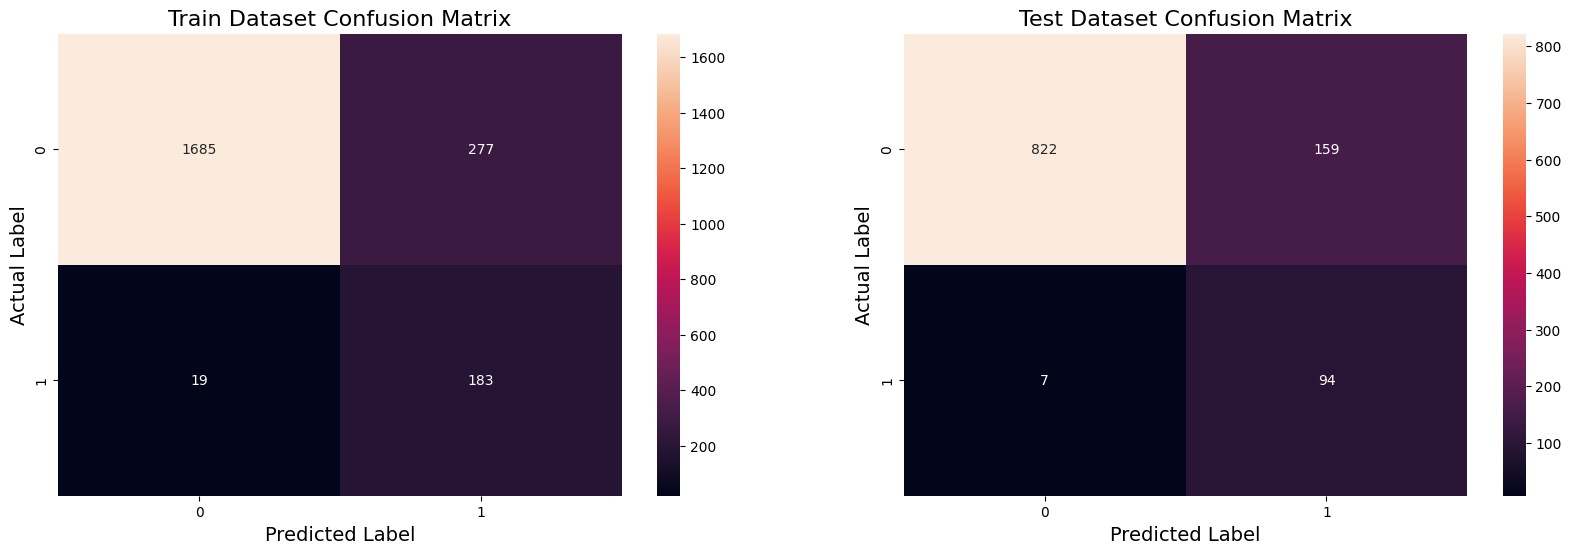

Best Threshold = 0.0739
Model AUC is : 0.9627
Model F1 Score is : 0.5311
						Number of base learners =  200
Train AUC =  0.9384771045911932
Test AUC =  0.9626467233879351


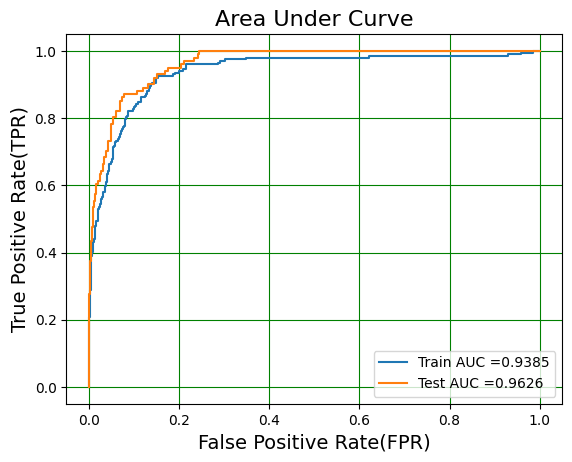

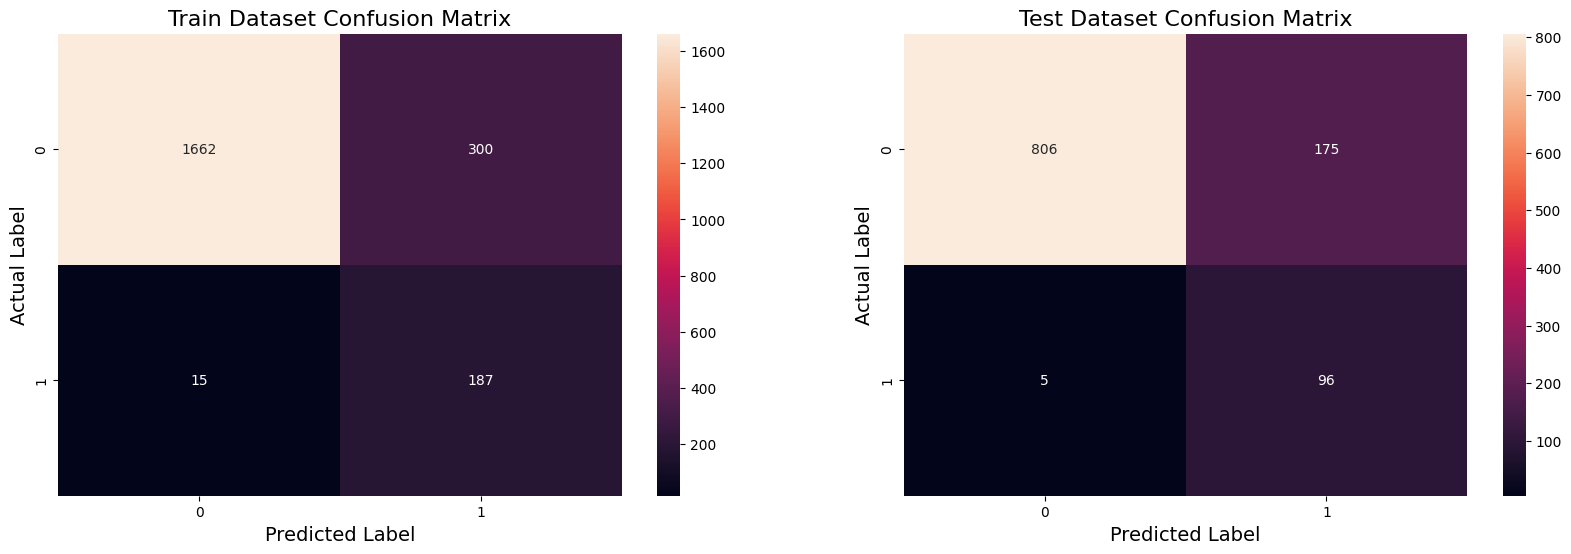

Best Threshold = 0.0723
Model AUC is : 0.9626
Model F1 Score is : 0.5161


In [177]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [183]:
table.column_headers= ["No of DT", "Meta Model", "AUC", "F1 Score"]
table.clear()
table.append_row(["10", "SVM with RBF Kernel", "0.9593", "0.5095"])
table.append_row(["20", "SVM with RBF Kernel", "0.9635", "0.5026"])
table.append_row(["50", "SVM with RBF Kernel", "0.9624", "0.5234"])
table.append_row(["80", "SVM with RBF Kernel", "0.9638", "0.5378"])
table.append_row(["100", "SVM with RBF Kernel", "0.9629", "0.5121"])
table.append_row(["150", "SVM with RBF Kernel", "0.9628", "0.5121"])
table.append_row(["175", "SVM with RBF Kernel", "0.9627", "0.5311"])
table.append_row(["200", "SVM with RBF Kernel", "0.9626", "0.5161"])
print(table)

+----------+---------------------+-------+----------+
| No of DT |     Meta Model      |  AUC  | F1 Score |
+----------+---------------------+-------+----------+
|    10    | SVM with RBF Kernel | 0.959 |  0.509   |
+----------+---------------------+-------+----------+
|    20    | SVM with RBF Kernel | 0.964 |  0.503   |
+----------+---------------------+-------+----------+
|    50    | SVM with RBF Kernel | 0.962 |  0.523   |
+----------+---------------------+-------+----------+
|    80    | SVM with RBF Kernel | 0.964 |  0.538   |
+----------+---------------------+-------+----------+
|   100    | SVM with RBF Kernel | 0.963 |  0.512   |
+----------+---------------------+-------+----------+
|   150    | SVM with RBF Kernel | 0.963 |  0.512   |
+----------+---------------------+-------+----------+
|   175    | SVM with RBF Kernel | 0.963 |  0.531   |
+----------+---------------------+-------+----------+
|   200    | SVM with RBF Kernel | 0.963 |  0.516   |
+----------+----------------

All the models are not performing good. Still it is working comperatively better whrn k =50.

#### Meta Model = LogisticRegression

In [138]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [139]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [140]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kapil\AppDat

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [141]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 100.0, 'penalty': 'l2'}
roc_auc_score : 0.8583158951068791


Train AUC =  0.8620875849052796
Test AUC =  0.8905340075291932


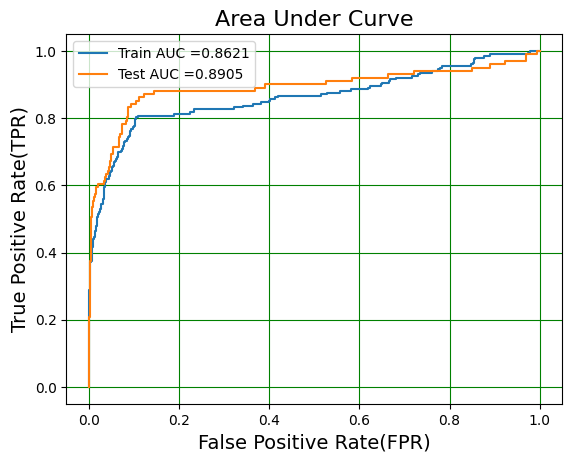

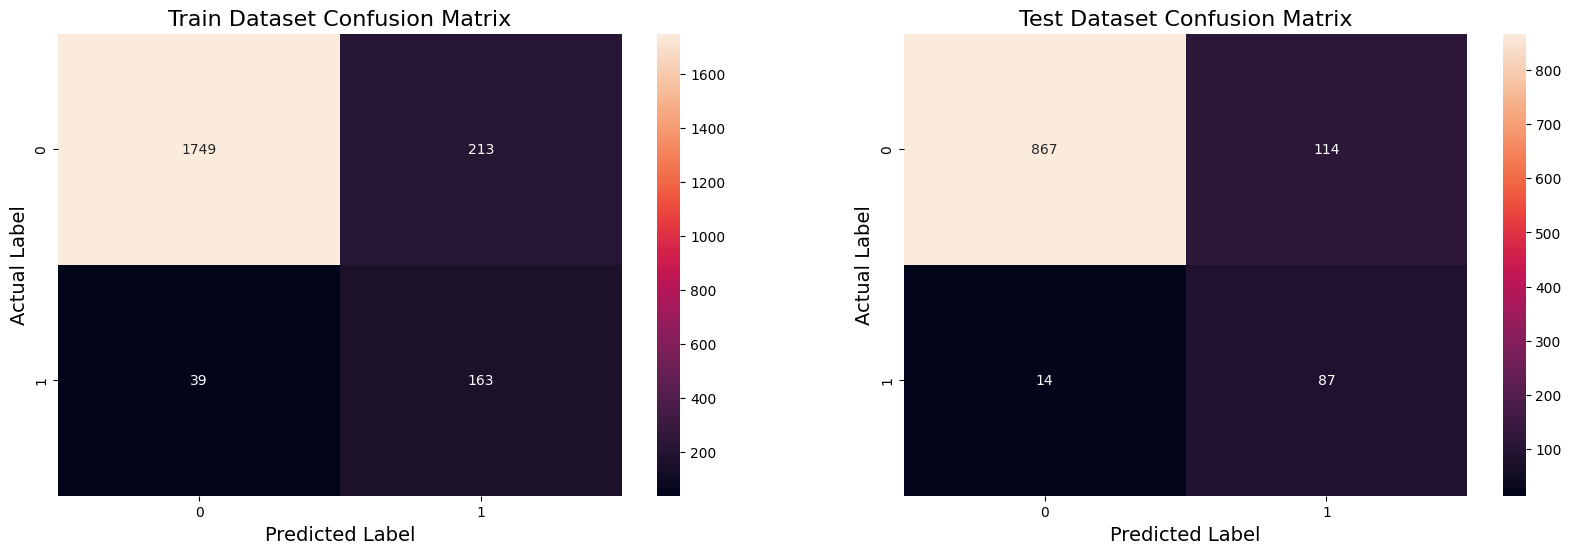

Best Threshold = 0.0483
Model AUC is : 0.8905
Model F1 Score is : 0.5762


In [142]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=10.0, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [143]:
combined_table.append_row(["SVM(rbf) + LR", "50", "0.9134", "0.5669"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


#### Meta Model - Random Forest

In [144]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [145]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 20}
roc_auc_score : 0.9321039253068569


In [146]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9718386976312309
Test AUC =  0.9491981308222566


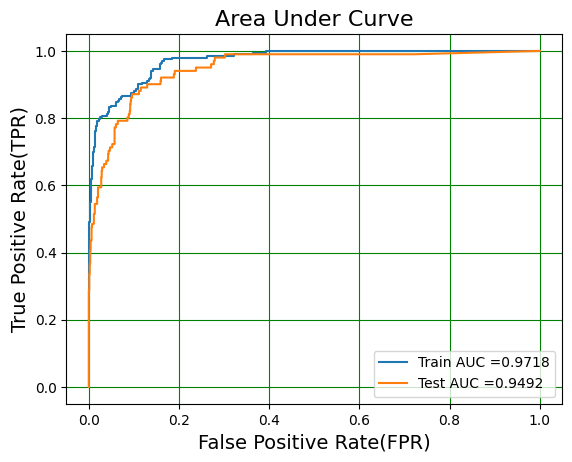

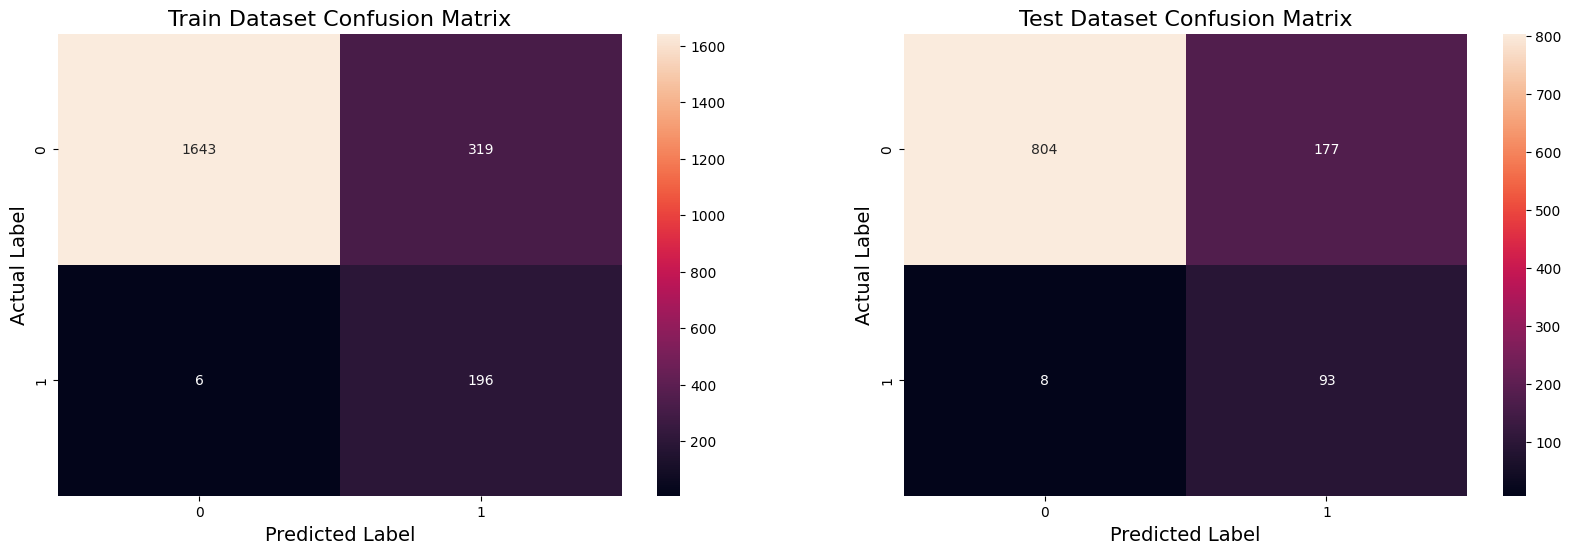

Best Threshold = 0.0546
Model AUC is : 0.9492
Model F1 Score is : 0.5013


In [147]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [148]:
combined_table.append_row(["SVM(rbf) + RF", "50", "0.9456", "0.4831"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## BaseLearner - XGBClassifier

In [149]:
from xgboost import XGBClassifier
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = XGBClassifier(learning_rate=0.1, max_delta_step=0, max_depth=10)
        # base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9380380698620321
Test AUC =  0.9556827242357263


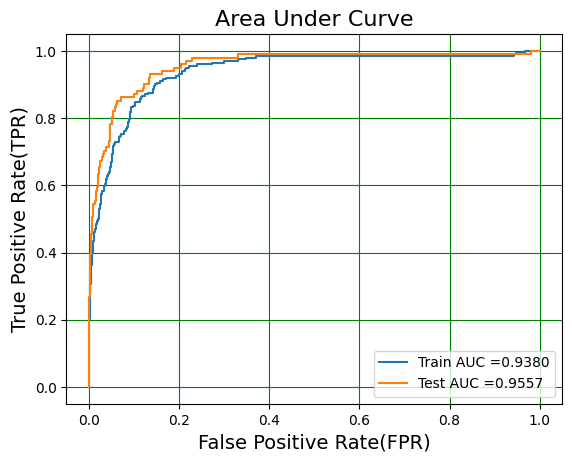

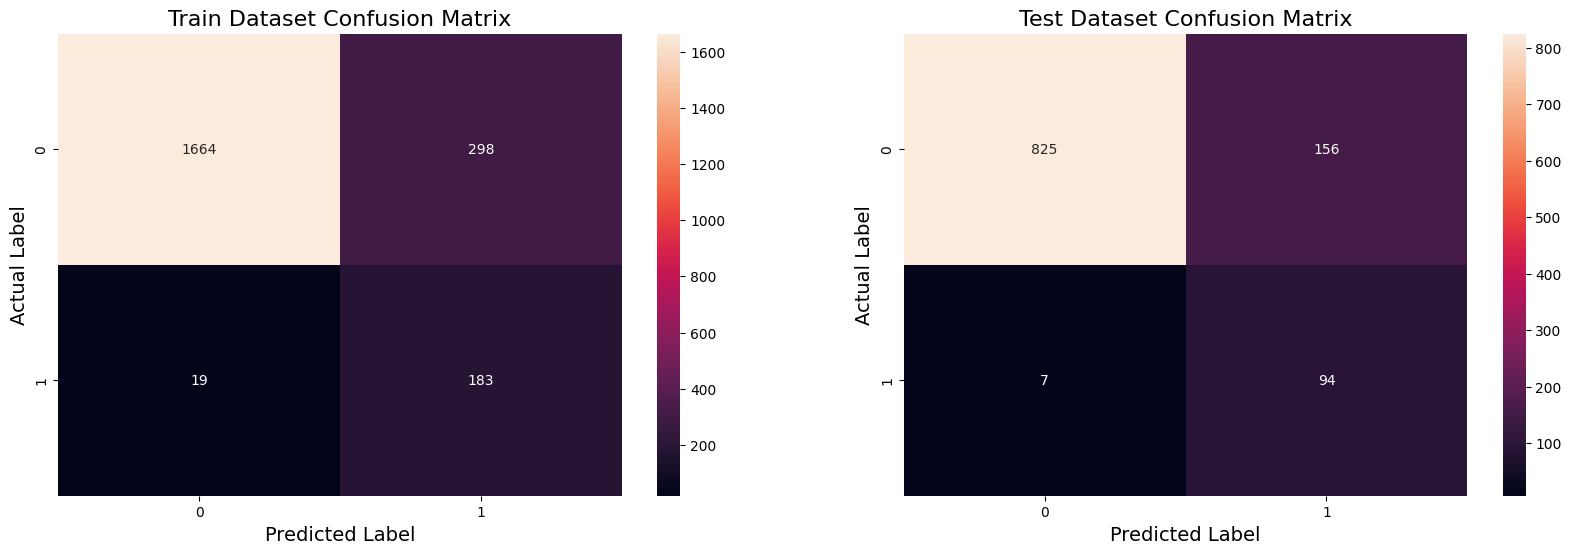

Best Threshold = 0.0921
Model AUC is : 0.9557
Model F1 Score is : 0.5356
						Number of base learners =  20
Train AUC =  0.938179368395555
Test AUC =  0.9630605262361098


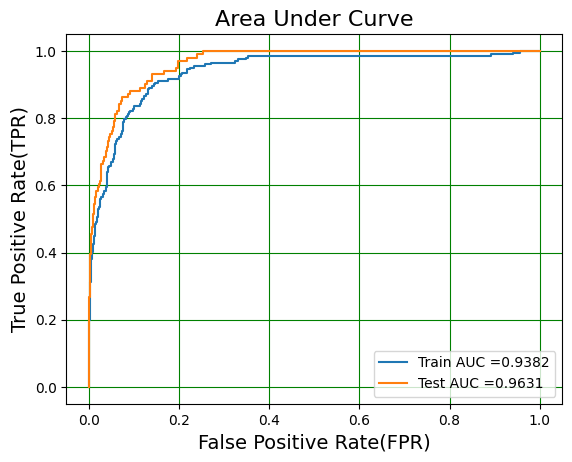

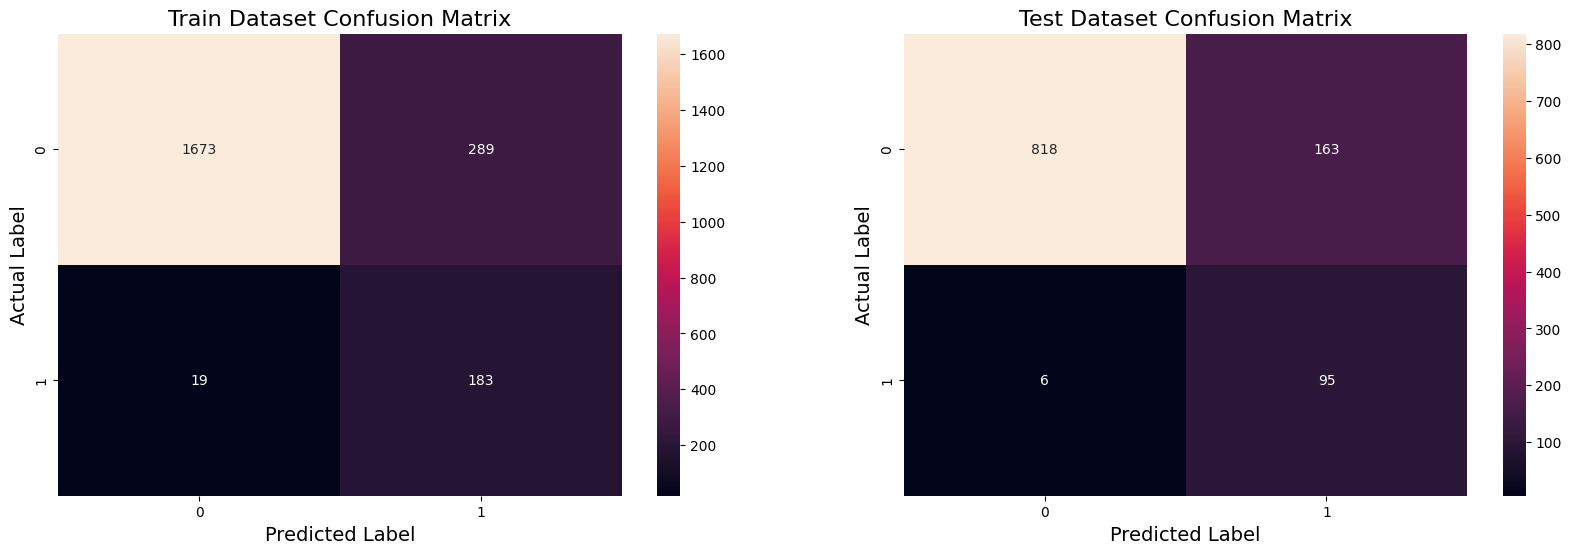

Best Threshold = 0.0908
Model AUC is : 0.9631
Model F1 Score is : 0.5292
						Number of base learners =  50
Train AUC =  0.939012020468102
Test AUC =  0.9631311755028713


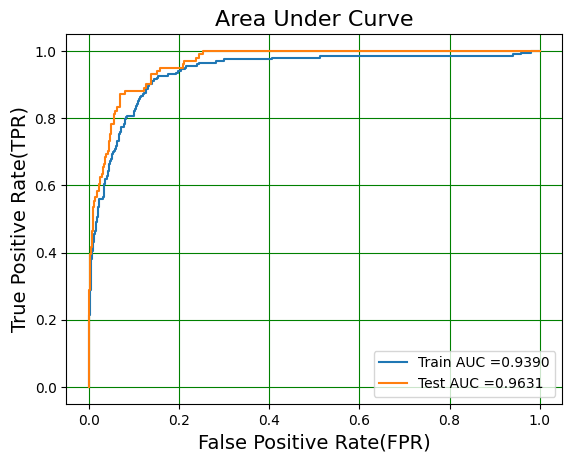

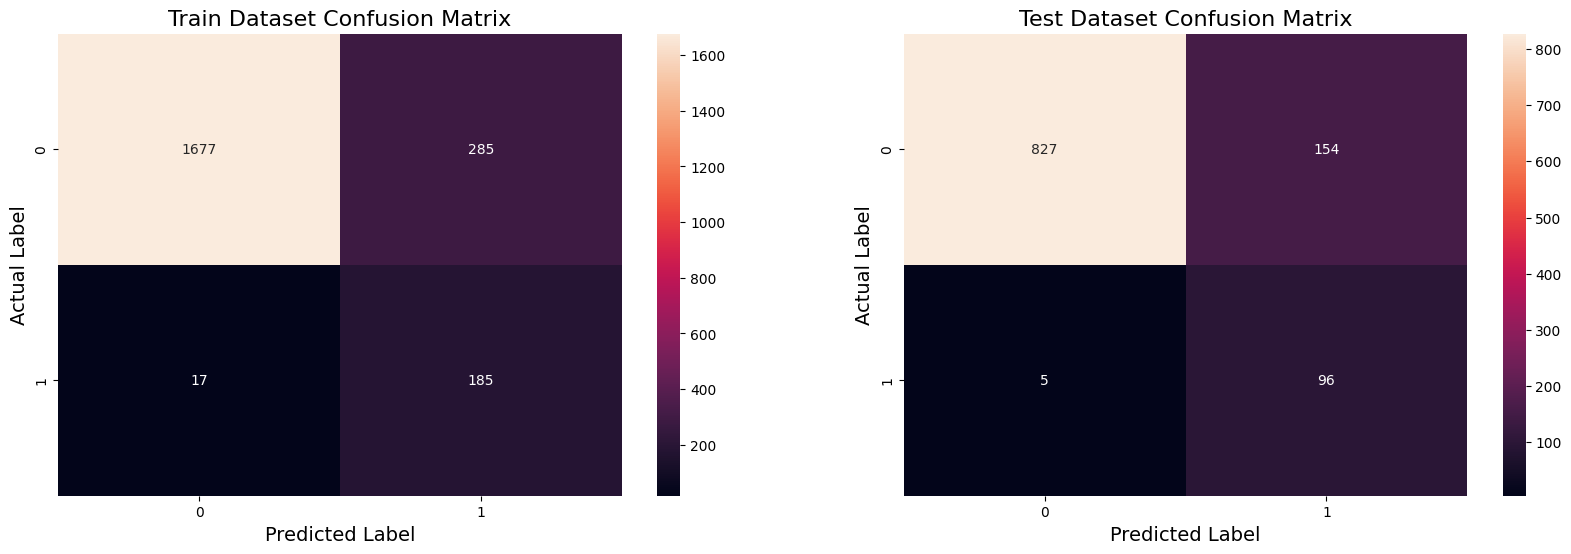

Best Threshold = 0.0859
Model AUC is : 0.9631
Model F1 Score is : 0.5470
						Number of base learners =  80
Train AUC =  0.9398169174715636
Test AUC =  0.9653515810296626


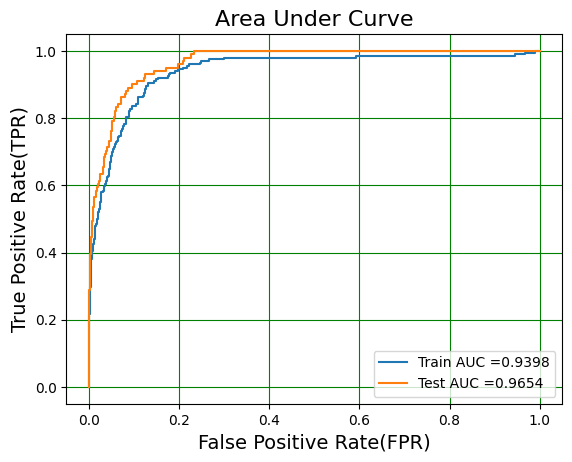

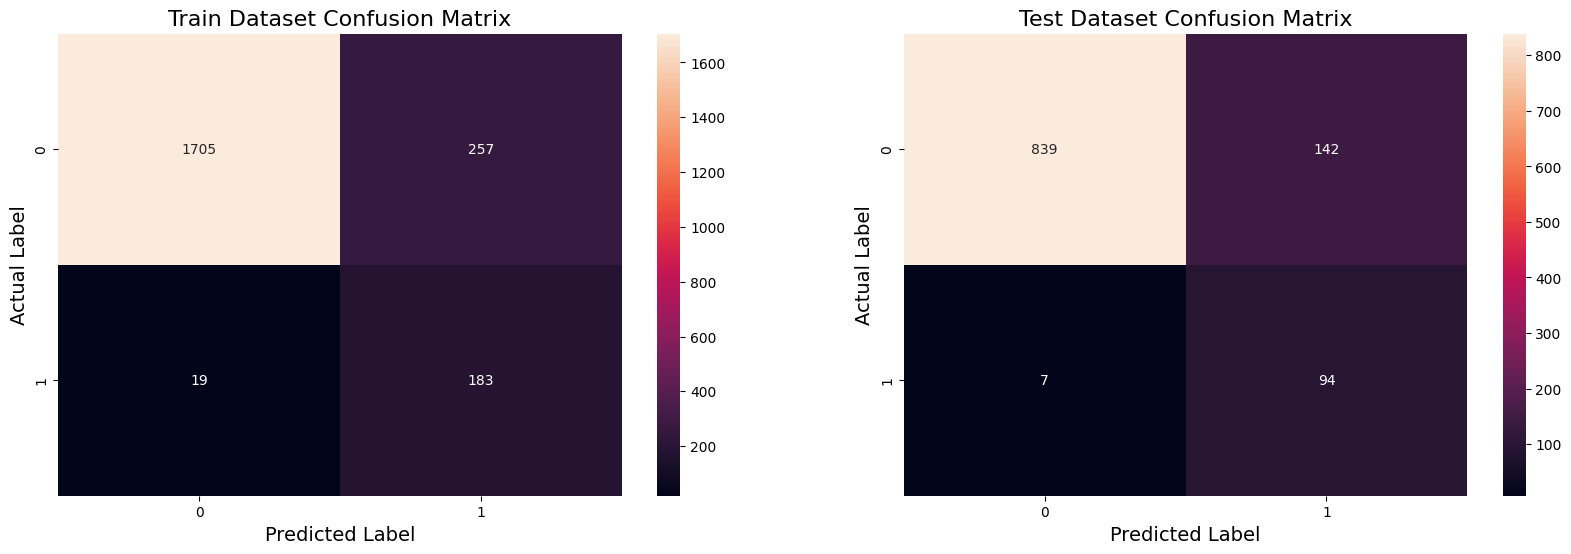

Best Threshold = 0.0828
Model AUC is : 0.9654
Model F1 Score is : 0.5579
						Number of base learners =  100
Train AUC =  0.939753837769098
Test AUC =  0.9636963696369637


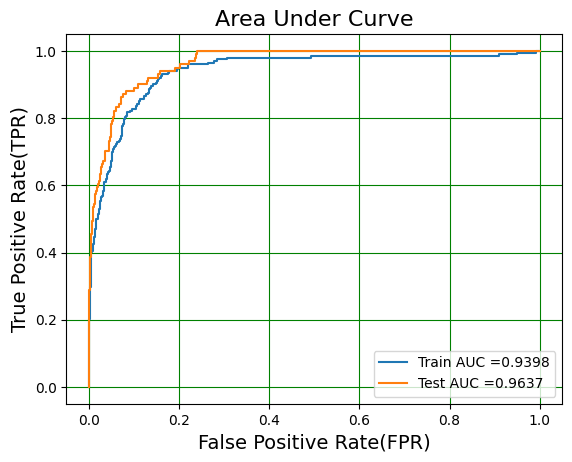

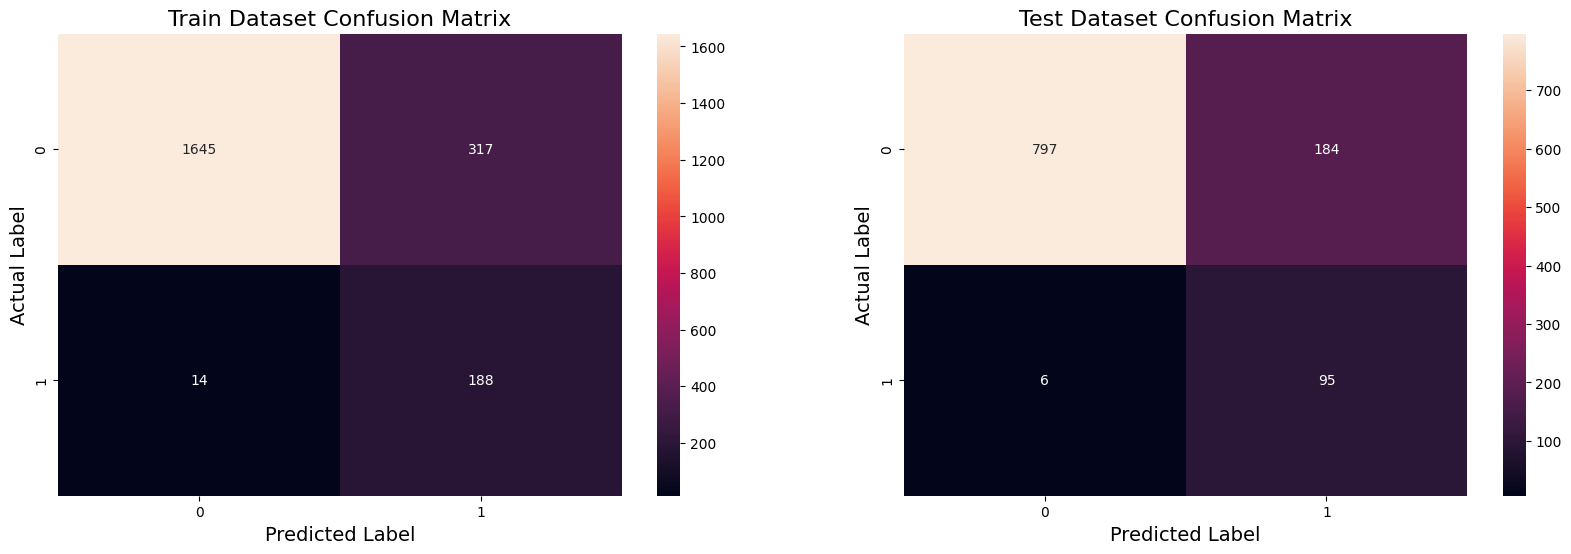

Best Threshold = 0.0786
Model AUC is : 0.9637
Model F1 Score is : 0.5000
						Number of base learners =  150
Train AUC =  0.9401651174291741
Test AUC =  0.963444050827101


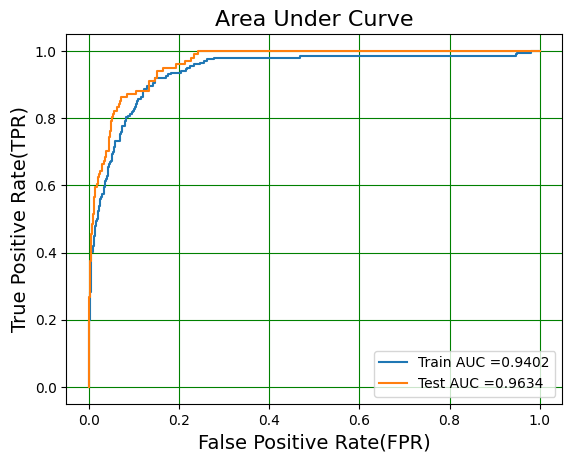

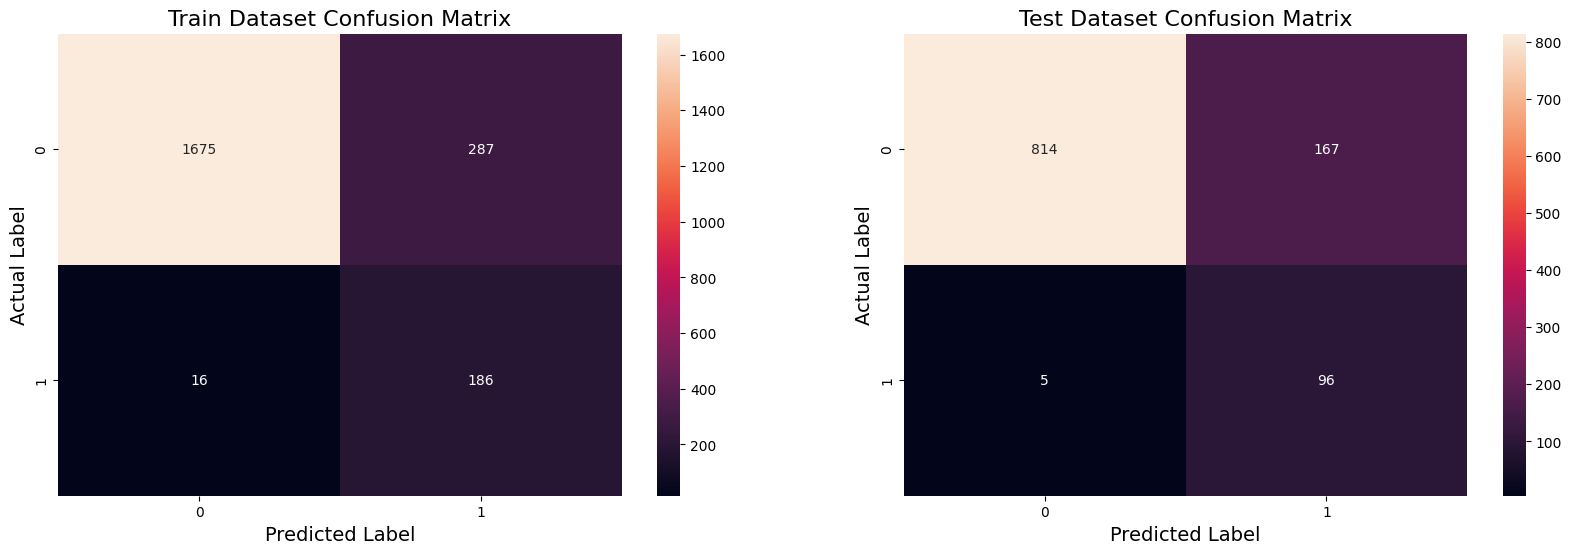

Best Threshold = 0.0752
Model AUC is : 0.9634
Model F1 Score is : 0.5275
						Number of base learners =  175
Train AUC =  0.9392012595754988
Test AUC =  0.9627577436642747


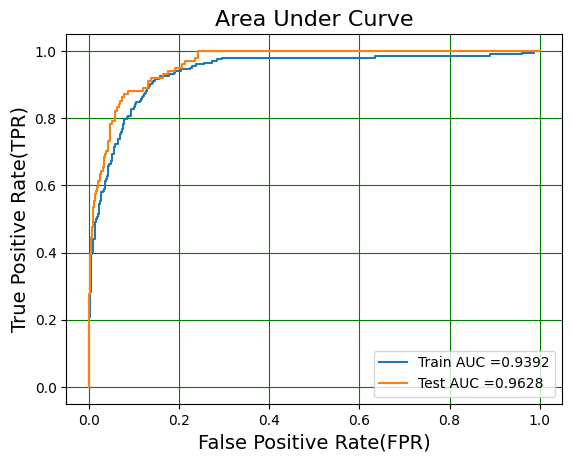

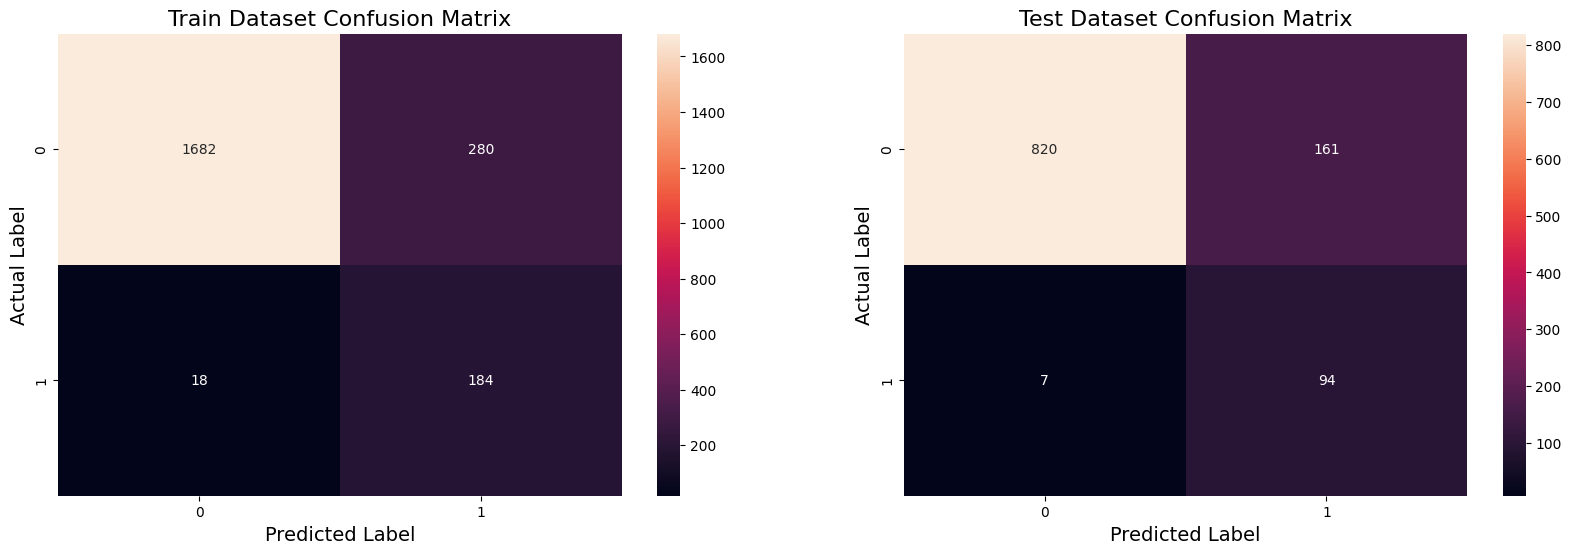

Best Threshold = 0.0741
Model AUC is : 0.9628
Model F1 Score is : 0.5281
						Number of base learners =  200
Train AUC =  0.9390523914776797
Test AUC =  0.9624751465972285


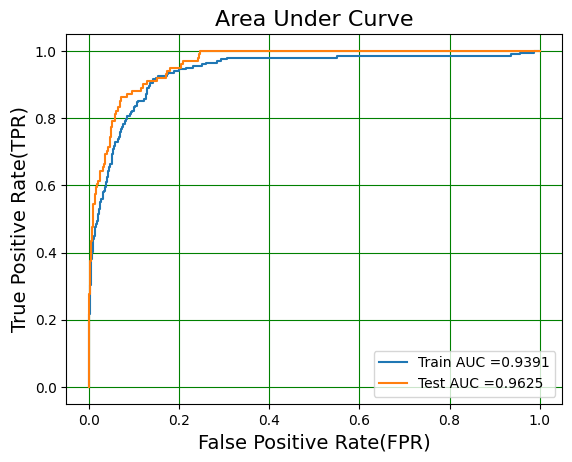

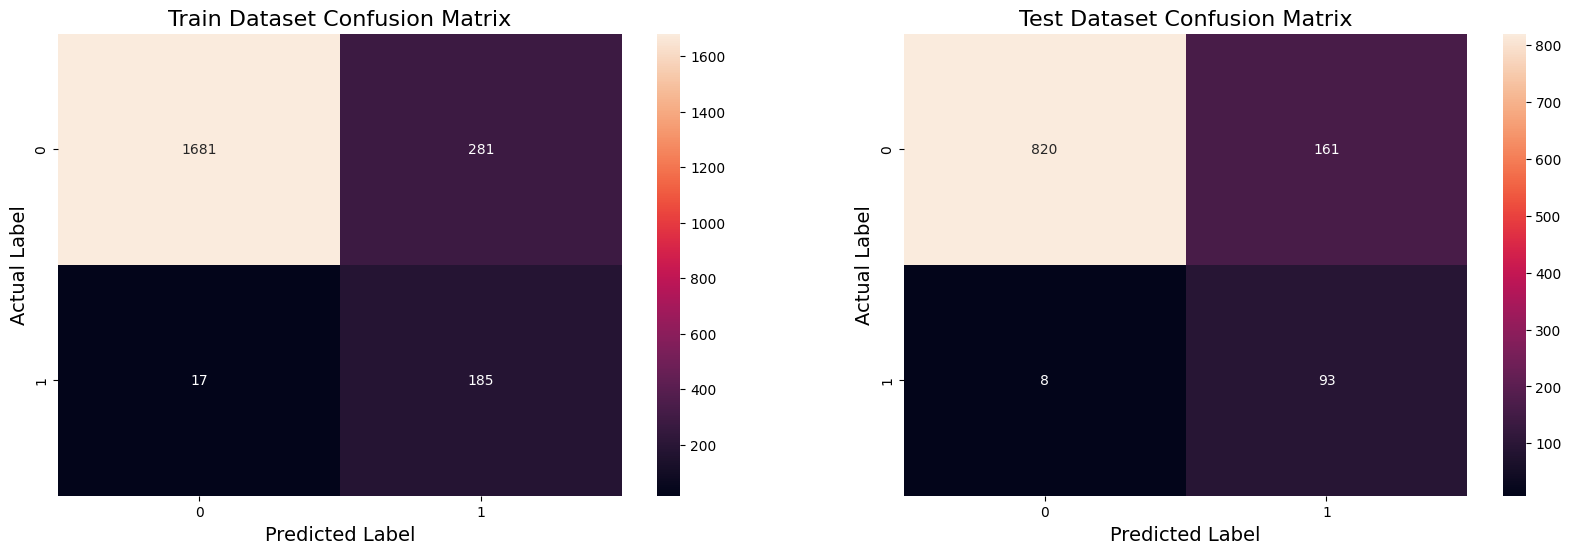

Best Threshold = 0.0724
Model AUC is : 0.9625
Model F1 Score is : 0.5239


In [184]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [186]:
table.column_headers= ["No of DT", "Meta Model", "AUC", "F1 Score"]
table.clear()
table.append_row(["10", "Logistic Regression", "0.9557", "0.5356"])
table.append_row(["20", "Logistic Regression", "0.9631", "0.5292"])
table.append_row(["50", "Logistic Regression", "0.9631", "0.5470"])
table.append_row(["80", "Logistic Regression", "0.9654", "0.5579"])
table.append_row(["100", "Logistic Regression", "0.9637", "0.5000"])
table.append_row(["150", "Logistic Regression", "0.9634", "0.5275"])
table.append_row(["175", "Logistic Regression", "0.9628", " 0.5281"])
table.append_row(["200", "Logistic Regression", "0.9625", "0.5239"])

print(table)

+----------+---------------------+-------+----------+
| No of DT |     Meta Model      |  AUC  | F1 Score |
+----------+---------------------+-------+----------+
|    10    | Logistic Regression | 0.956 |  0.536   |
+----------+---------------------+-------+----------+
|    20    | Logistic Regression | 0.963 |  0.529   |
+----------+---------------------+-------+----------+
|    50    | Logistic Regression | 0.963 |  0.547   |
+----------+---------------------+-------+----------+
|    80    | Logistic Regression | 0.965 |  0.558   |
+----------+---------------------+-------+----------+
|   100    | Logistic Regression | 0.964 |   0.5    |
+----------+---------------------+-------+----------+
|   150    | Logistic Regression | 0.963 |  0.527   |
+----------+---------------------+-------+----------+
|   175    | Logistic Regression | 0.963 |  0.528   |
+----------+---------------------+-------+----------+
|   200    | Logistic Regression | 0.963 |  0.524   |
+----------+----------------

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


Model is working best when k = 80.

#### Meta Model - LogisticRegression

In [151]:
# create 50 sampled dataset
k = 80
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [152]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [153]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kapil\AppDat

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [154]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.001, 'penalty': 'l2'}
roc_auc_score : 0.9353703958775839


Train AUC =  0.9354568484371373
Test AUC =  0.9581049848104076


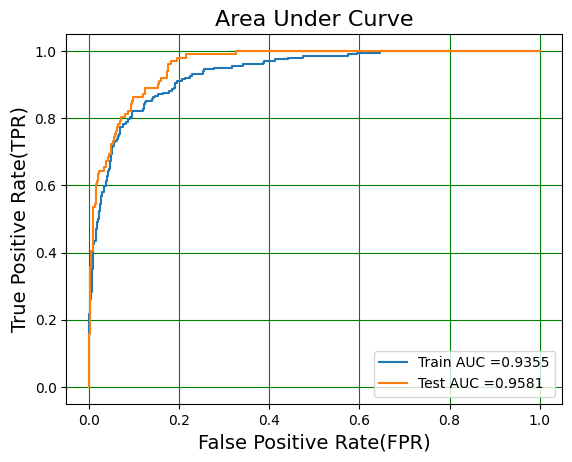

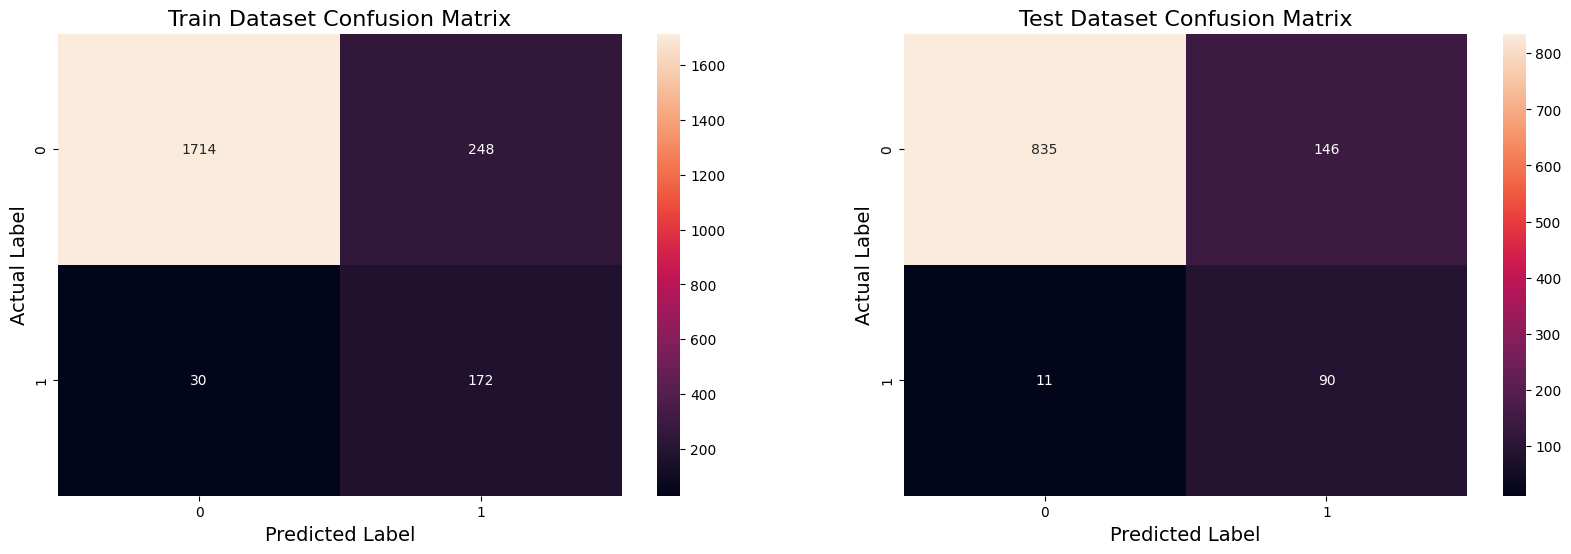

Best Threshold = 0.0507
Model AUC is : 0.9581
Model F1 Score is : 0.5341


In [155]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.01, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [156]:
combined_table.append_row(["XGBClf + LR", "80", "0.9579", "0.5678"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


#### Meta Model - Random Forest

In [157]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py"

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [158]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 5}
roc_auc_score : 0.9364262282831584


In [159]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=400,
                       random_state=42)

Train AUC =  0.978956611257456
Test AUC =  0.9579031297625177


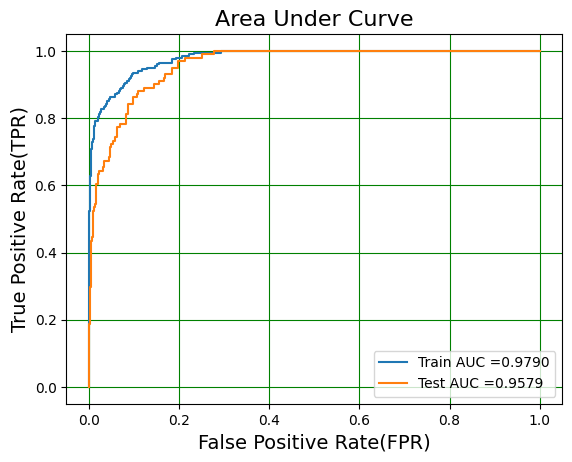

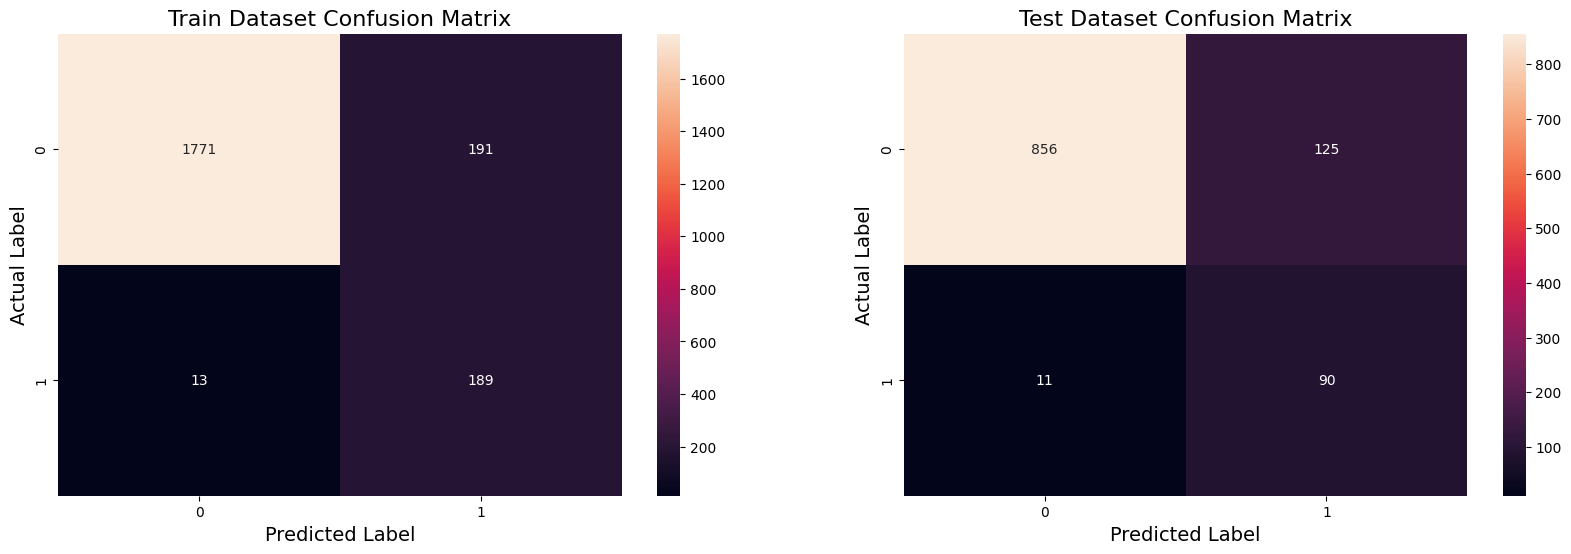

Best Threshold = 0.1138
Model AUC is : 0.9579
Model F1 Score is : 0.5696


In [160]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [161]:
combined_table.append_row(["XGBClf + RF", "80", "0.9594", "0.5663"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


#### Meta Model - SVC

In [162]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [163]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l1'}
roc_auc_score : 0.870340519981964


In [164]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

CalibratedClassifierCV(estimator=LinearSVC(C=0.5))

Train AUC =  0.9202243618857298
Test AUC =  0.9369707612963131


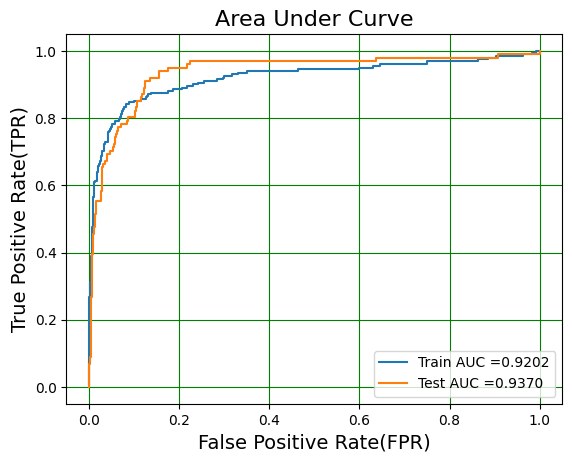

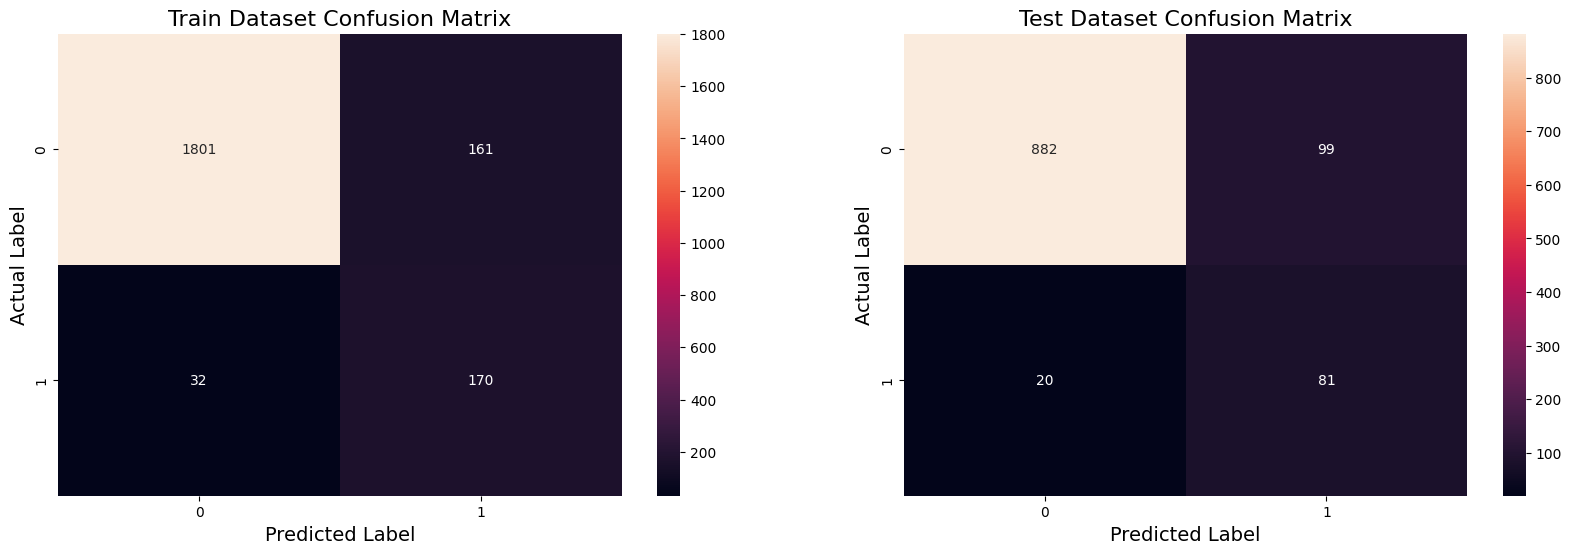

Best Threshold = 0.0717
Model AUC is : 0.9370
Model F1 Score is : 0.5765


In [165]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [166]:
combined_table.append_row(["XGBClf + LinearSVC", "80", "0.9026", "0.5874"])
print(combined_table)

+--------------------+---------------------+-------+----------+
| Model Combination  | No of base Learners |  AUC  | F1 Score |
+--------------------+---------------------+-------+----------+
|      DT + LR       |         50          | 0.953 |  0.544   |
+--------------------+---------------------+-------+----------+
|      DT + DT       |         50          | 0.914 |   0.5    |
+--------------------+---------------------+-------+----------+
|      DT + SVC      |         50          | 0.942 |  0.503   |
+--------------------+---------------------+-------+----------+
|      DT + RF       |         50          | 0.955 |  0.551   |
+--------------------+---------------------+-------+----------+
|      LR + RF       |         80          | 0.945 |  0.623   |
+--------------------+---------------------+-------+----------+
|      LR + SVC      |         80          | 0.949 |   0.53   |
+--------------------+---------------------+-------+----------+
|  SVM(Linear) + LR  |         50       

c:\Users\kapil\AppData\Local\Programs\Python\Python311\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## Observation:
Comparing AUC and F1 score for all the combination tried, SVM with linear kernel with 50 base learner and Random forest meta model working the best. <br> AUC = 0.963 and F1 Score =  0.621 

### Train the model which gave the best result

In [167]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='linear')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

In [168]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [169]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [170]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9811290762103733
Test AUC =  0.9614658713577781


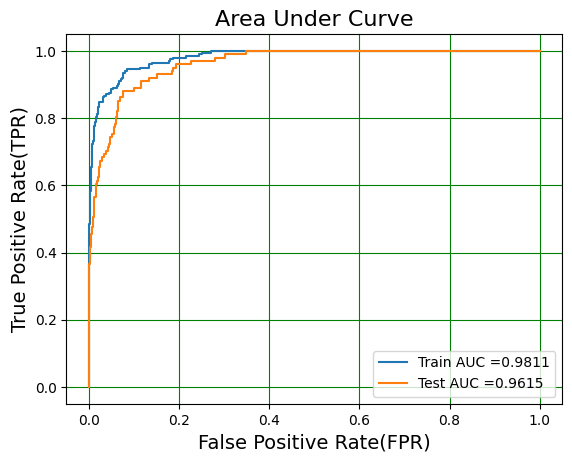

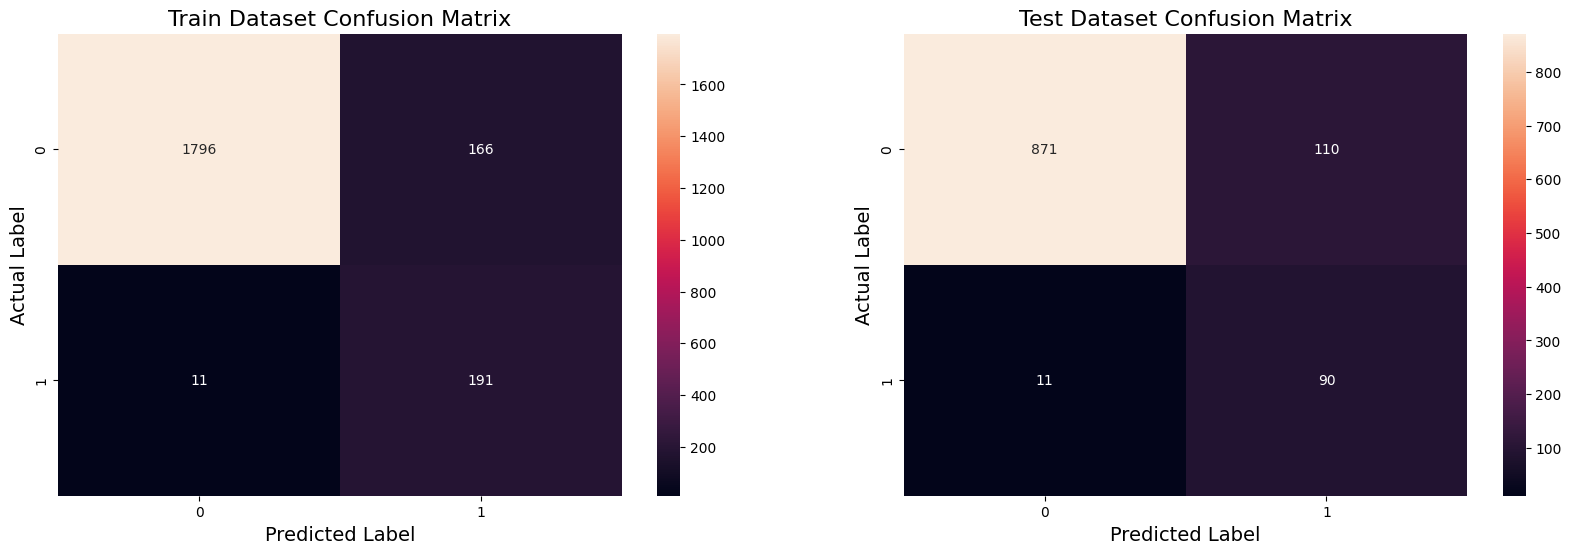

Best Threshold = 0.1556
Model AUC is : 0.9615
Model F1 Score is : 0.5980


In [171]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

# Conclusion:
Model performance is increased in terms of both AUC and F1 score using ensemble model (Linear SVM + RF) than using a single first cut model.

#### Add the predicted labels to the dataframe containing original label

In [172]:
y_val_pred = pred_prob(random_forest, x_val_meta_model)
y_val_prediction = predict_with_best_t(y_val_pred, best_t)
x_validation_provider_labels['Predicted_Label'] = y_val_prediction
x_validation_provider_labels = x_validation_provider_labels.reset_index(drop=True)

C:\Users\kapil\AppData\Local\Temp\ipykernel_24756\118811502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_validation_provider_labels['Predicted_Label'] = y_val_prediction


In [173]:
x_validation_provider_labels.head(10)

Provider  PotentialFraud  Predicted_Label
0  PRV52573               0                0
1  PRV52731               0                0
2  PRV53323               0                0
3  PRV53166               0                0
4  PRV56177               0                0
5  PRV52878               0                0
6  PRV54477               0                0
7  PRV51176               0                0
8  PRV56819               0                1
9  PRV52599               0                0

In [174]:
x_validation_provider_labels.tail(10)

Provider  PotentialFraud  Predicted_Label
1072  PRV53752               0                0
1073  PRV53539               0                0
1074  PRV52417               0                0
1075  PRV56528               0                0
1076  PRV52340               1                1
1077  PRV53129               0                0
1078  PRV51209               0                0
1079  PRV55446               0                0
1080  PRV56346               0                0
1081  PRV56080               0                0